# Si execution sur Colab

In [1]:
from google.colab import drive, files
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

# Définir le chemin vers ton fichier
data_path = '/content/drive/My Drive/data.tar.gz'

# Vérifier si le fichier existe
if os.path.exists(data_path):
    print("Fichier trouvé :", data_path)
else:
    print("Fichier introuvable. Vérifie le chemin.")

Fichier trouvé : /content/drive/My Drive/data.tar.gz


In [3]:
import tarfile

# Chemin où tu veux extraire les données
extract_path = '/content/data'

# Créer le dossier s'il n'existe pas
os.makedirs(extract_path, exist_ok=True)

# Extraire le fichier
with tarfile.open(data_path, 'r:gz') as tar:
    tar.extractall(path=extract_path)
    print("Extraction terminée dans :", extract_path)

Extraction terminée dans : /content/data


Dans les dictionnaire de chemin il faut ajouter au debut /data/

# Self supervised learning for anomaly detection

Ce projet a pour but d'utiliser l'apprentissage auto-supervisé (donc sur des données non labélisées) pour la detection d'anomalies. Nous allons entrainer des modèles de type autoencoder sur des pretexts particuliers qui ont pour but d'apprendre au modèle à reconstruire l'image original, à partir de l'encodage de l'image originale modifiée par le pretext en question, via le decoder.
\
Pour ce projet nous allons utiliser deux jeu de données qui sont :
- MVTecAD dans lequel nous allons récupérer les données des catégories Capsule, Toothbrush, Bottle et Hazelnut,
- AutoVI dans lequel nous allons récupérer les données de la catégorie Engine wiring.

Pour chaque catégorie nous avons un ensemble de train qui ne contient que des images sans anomalies et un ensemble de test qui contient des images avec et sans anomalies. Le but étant d'entrainer le modèle à reconstruire correctement l'image "normale" puis lors du test c'est la perte entre l'image d'entrée et de sortie qui sert de score d'anomalie pour identifier les images "anormales" qui auront une perte supérieure à la normale.\
\
Dans ce projet nous allons nous concentrer uniquement sur la reconstruction des images et évaluer les performances via les courbes ROC et la métrique AUROC (aire sous la courbe ROC), sans se soucier de construire un classifier et determiner un seuil du score d'anomalie pour classer nos images.

# Librairy imports

In [4]:
# Importation des librairies nécessaires

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_curve, auc

import os
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Configuration de l'utilisation d'un GPU si disponible

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Data exploration

In [6]:
# Classe pour faire une rapide analyse de nos données, pour voir les tailles d'images, les statistiques des pixels, etc.

class ImageDataExplorer:
    def __init__(self, data_dirs):
        """
        Initialise l'explorateur de données avec les chemins des répertoires des images.

        Args:
            data_dirs (dict): Dictionnaire {catégorie: chemin_du_dossier}.
        """
        self.data_dirs = data_dirs
        self.transform = transforms.ToTensor()
        self.pixel_stats = {}

    def inspect_image_sizes(self, num_samples=10):
        """
        Inspecte les tailles d'images pour chaque catégorie.

        Args:
            num_samples (int): Nombre d'images à inspecter par catégorie.
        """
        for category, folder in self.data_dirs.items():
            image_sizes = []
            for i, img_name in enumerate(os.listdir(folder)):
                if i >= num_samples:
                    break
                img_path = os.path.join(folder, img_name)
                with Image.open(img_path) as img:
                    image_sizes.append(img.size)  # (width, height)

            print(f"Exemples de tailles d'images pour {category} : {image_sizes}")
        print("\n")

    def compute_pixel_stats(self):
        """
        Calcule les moyennes et écarts-types des valeurs de pixels par canal (R, G, B).
        """
        pixel_sum = np.zeros(3)  # Pour la somme des pixels par canal (R, G, B)
        pixel_square_sum = np.zeros(3)  # Pour la somme des carrés des pixels par canal
        n_pixels = 0

        for category, folder in self.data_dirs.items():
            pixel_values = []
            for img_name in os.listdir(folder):
                img_path = os.path.join(folder, img_name)
                with Image.open(img_path) as img:
                    img_tensor = self.transform(img)
                    n_pixels += img_tensor.size(1) * img_tensor.size(2)  # Ajoute le nombre total de pixels par canal
                    pixel_sum += img_tensor.sum(dim=(1, 2)).numpy()  # Somme des pixels par canal
                    pixel_square_sum += (img_tensor ** 2).sum(dim=(1, 2)).numpy()  # Somme des carrés des pixels par canal

            # Moyenne et écart-type par canal
            mean = pixel_sum / n_pixels
            std = np.sqrt(pixel_square_sum / n_pixels - mean ** 2)

            # Stocker les statistiques dans le dictionnaire
            self.pixel_stats[category] = {"mean": mean, "std": std}

            print(f"Pour {category} :")
            print(f"Moyennes par canal (R, G, B) : {mean}")
            print(f"Écarts-types par canal (R, G, B) : {std}")
            print("\n")


    def get_pixel_stats(self):
        """
        Returns:
            dict: Dictionnaire contenant les moyennes et écarts-types par catégorie.
        """
        return self.pixel_stats


    def visualize_resized_images(self, img_sizes=(32, 64, 128, 256), num_samples=1):
        """
        Visualise les redimensionnements d'images à différentes tailles.

        Args:
            img_sizes (tuple): Tailles des redimensionnements à tester.
            num_samples (int): Nombre d'images à afficher par catégorie.
        """
        resize_transforms = {
            size: transforms.Compose([transforms.Resize((size, size)), transforms.ToTensor()])
            for size in img_sizes
        }

        for category, folder in self.data_dirs.items():
            for i, img_name in enumerate(os.listdir(folder)):
                if i >= num_samples:
                    break
                img_path = os.path.join(folder, img_name)
                with Image.open(img_path) as img:
                    resized_images = {size: transform(img).permute(1, 2, 0) for size, transform in resize_transforms.items()}

                # Tracer les images redimensionnées
                fig, axs = plt.subplots(1, len(img_sizes), figsize=(15, 4))
                for ax, (size, resized_img) in zip(axs, resized_images.items()):
                    ax.imshow(resized_img)
                    ax.set_title(f"{size}x{size}")
                plt.suptitle(f"Redimensionnement des images de {category}")
                plt.show()


Exemples de tailles d'images pour bottle : [(900, 900), (900, 900), (900, 900), (900, 900), (900, 900), (900, 900), (900, 900), (900, 900), (900, 900), (900, 900)]
Exemples de tailles d'images pour capsule : [(1000, 1000), (1000, 1000), (1000, 1000), (1000, 1000), (1000, 1000), (1000, 1000), (1000, 1000), (1000, 1000), (1000, 1000), (1000, 1000)]
Exemples de tailles d'images pour hazelnut : [(1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024)]
Exemples de tailles d'images pour toothbrush : [(1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024), (1024, 1024)]
Exemples de tailles d'images pour engine_wiring : [(400, 400), (400, 400), (400, 400), (400, 400), (400, 400), (400, 400), (400, 400), (400, 400), (400, 400), (400, 400)]


Pour bottle :
Moyennes par canal (R, G, B) : [0.53541012 0.53168199 0.54795864]
Écarts-types par canal (

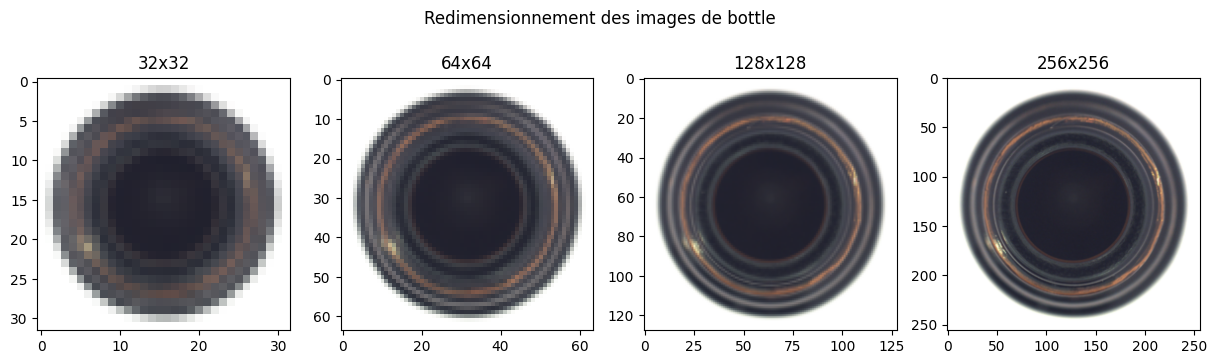

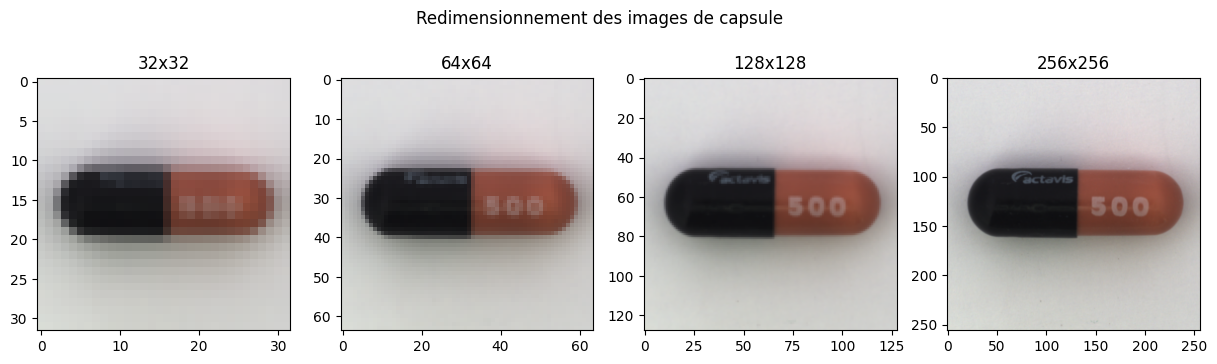

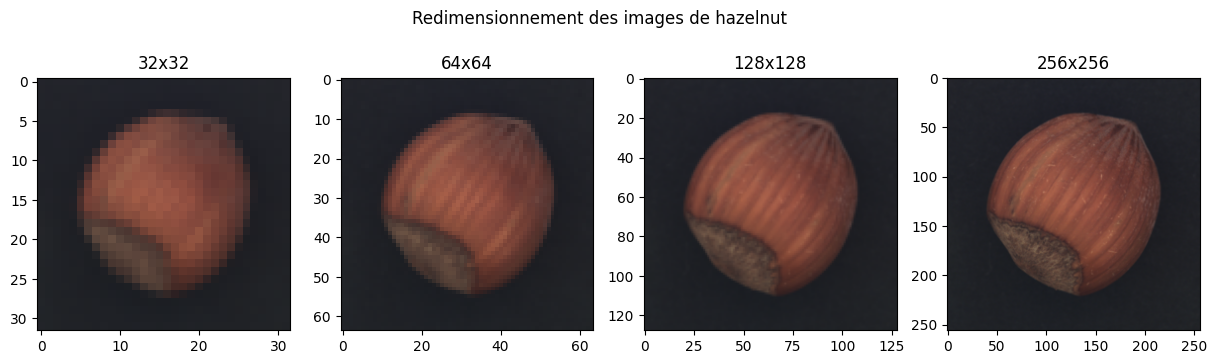

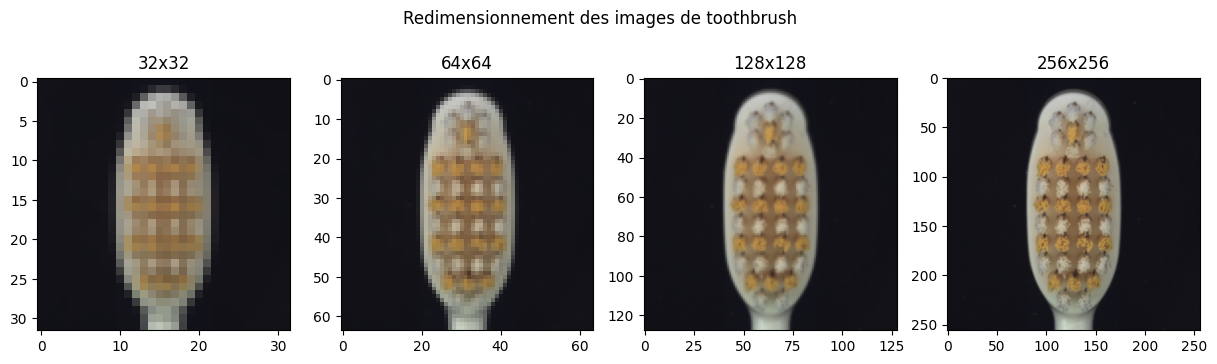

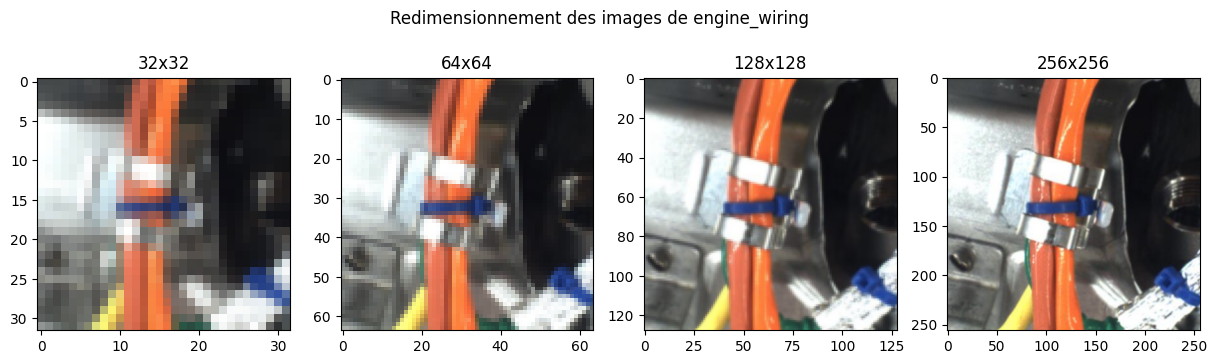

In [7]:
# Dossier racine des données
data_dir_dict = {
    'bottle': 'data/data/bottle/train/good',
    'capsule': 'data/data/capsule/train/good',
    'hazelnut': 'data/data/hazelnut/train/good',
    'toothbrush': 'data/data/toothbrush/train/good',
    'engine_wiring': 'data/data/engine_wiring/train/good'
}

explorer = ImageDataExplorer(data_dirs=data_dir_dict)

# Inspecter les tailles des images
explorer.inspect_image_sizes(num_samples=10)

# Calculer les statistiques des pixels
explorer.compute_pixel_stats()

# On stocke les statistiques des pixels pour la normalisation
pixel_stats = explorer.get_pixel_stats()

# Visualiser les différents redimensionnements
explorer.visualize_resized_images(img_sizes=(32, 64, 128, 256), num_samples=1)

On peut constater qu'un redimensionnement des images en 128x128 donne une qualité d'image accéptable mais afin de garder intact des détails fin pour detecter les anomalies nous faisons le choix d'un redimensionnement 256x256.

# Data preparation

In [8]:
class CategoryDataset(Dataset):
    def __init__(self, root_dir, mean, std, mode="train"):
        """
        Classe pour charger un dataset d'une catégorie spécifique avec normalisation.

        Args:
            root_dir (str): Racine des données pour une catégorie spécifique.
            mean (list): Moyenne par canal (R, G, B).
            std (list): Écart-type par canal (R, G, B).
            mode (str): "train" ou "test".
        """
        self.root_dir = os.path.join(root_dir, mode)
        self.image_paths = []
        self.labels = []  # 0 = normal, 1 = anomalie

        # Transformation avec redimensionnement et normalisation adaptée à la catégorie
        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])

        # Charger les chemins d'images et les labels
        if mode == "train":
            normal_dir = os.path.join(self.root_dir, "good")
            self._add_images_from_dir(normal_dir, label=0)
        elif mode == "test":
            for defect_type in os.listdir(self.root_dir):
                defect_dir = os.path.join(self.root_dir, defect_type)
                label = 0 if defect_type == "good" else 1
                self._add_images_from_dir(defect_dir, label)

    def _add_images_from_dir(self, dir_path, label):
        """
        Ajoute les images d'un répertoire au dataset en filtrant les fichiers non valides.

        Args:
            dir_path (str): Chemin du répertoire contenant les images.
            label (int): Label associé aux images du répertoire.
        """
        if os.path.isdir(dir_path):
            for f in os.listdir(dir_path):
                file_path = os.path.join(dir_path, f)
                if os.path.isfile(file_path) and self._is_valid_image(file_path):
                    self.image_paths.append(file_path)
                    self.labels.append(label)

    @staticmethod
    def _is_valid_image(file_path):
        """
        Vérifie si un fichier est une image valide (en fonction de son extension).

        Args:
            file_path (str): Chemin du fichier.

        Returns:
            bool: True si le fichier est une image valide, False sinon.
        """
        valid_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".tiff")
        return file_path.lower().endswith(valid_extensions)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        try:
            image = Image.open(image_path).convert("RGB")
        except Exception as e:
            raise RuntimeError(f"Erreur lors de l'ouverture de l'image : {image_path}\n{e}")

        if self.transform:
            image = self.transform(image)
        return image, label


In [9]:
def prepare_datasets(data_dir_dict, pixel_stats, mode="train"):
    """
    Crée un dictionnaire avec les datasets pour chaque catégorie en utilisant les statistiques calculées.

    Args:
        data_dir_dict (dict): Dictionnaire {catégorie: chemin_du_dossier}.
        pixel_stats (dict): Dictionnaire {catégorie: {"mean": [...], "std": [...]}}.
        mode (str): "train" ou "test".
    """
    datasets_dict = {}

    for category, folder in data_dir_dict.items():
        mean = pixel_stats[category]["mean"]
        std = pixel_stats[category]["std"]

        # Créer le dataset pour la catégorie
        datasets_dict[category] = CategoryDataset(
            root_dir=folder,
            mean=mean,
            std=std,
            mode=mode
        )

    return datasets_dict


In [10]:
# On verifie qu'on a bien nos statistiques des pixels pour chaque catégorie

print("Statistiques des pixels :")
for category, stats in pixel_stats.items():
    print(f"{category} : Moyenne = {stats['mean']}, Écart-type = {stats['std']}")


Statistiques des pixels :
bottle : Moyenne = [0.53541012 0.53168199 0.54795864], Écart-type = [0.36676049 0.36667316 0.34991978]
capsule : Moyenne = [0.62641897 0.60788297 0.6077917 ], Écart-type = [0.31168132 0.31775514 0.30712102]
hazelnut : Moyenne = [0.42798804 0.3865043  0.38363421], Écart-type = [0.31494227 0.31383207 0.30733228]
toothbrush : Moyenne = [0.41128353 0.37180342 0.36970357], Écart-type = [0.31515439 0.31211631 0.30463895]
engine_wiring : Moyenne = [0.4155514  0.37774341 0.3734649 ], Écart-type = [0.31693172 0.31385003 0.3048015 ]


In [11]:
# dictionnaire de chemins vers les données
data_dir_dict = {
    'bottle': 'data/data/bottle',
    'capsule': 'data/data/capsule',
    'hazelnut': 'data/data/hazelnut',
    'toothbrush': 'data/data/toothbrush',
    'engine_wiring': 'data/data/engine_wiring'
}

# Créer les datasets
train_datasets_dict = prepare_datasets(data_dir_dict, pixel_stats, mode="train")
test_datasets_dict = prepare_datasets(data_dir_dict, pixel_stats, mode="test")

# Vérification
print(f"Datasets de train créés pour les catégories : {list(train_datasets_dict.keys())}")
print(f"Datasets de test créés pour les catégories : {list(test_datasets_dict.keys())}")


Datasets de train créés pour les catégories : ['bottle', 'capsule', 'hazelnut', 'toothbrush', 'engine_wiring']
Datasets de test créés pour les catégories : ['bottle', 'capsule', 'hazelnut', 'toothbrush', 'engine_wiring']


In [12]:
batch_size = 32 # ou 16

# On crée les data loaders pour chaque catégorie

train_bottle_loader = DataLoader(train_datasets_dict['bottle'], batch_size=batch_size, shuffle=True)
test_bottle_loader = DataLoader(test_datasets_dict['bottle'], batch_size=batch_size, shuffle=False)

train_capsule_loader = DataLoader(train_datasets_dict['capsule'], batch_size=batch_size, shuffle=True)
test_capsule_loader = DataLoader(test_datasets_dict['capsule'], batch_size=batch_size, shuffle=False)

train_hazelnut_loader = DataLoader(train_datasets_dict['hazelnut'], batch_size=batch_size, shuffle=True)
test_hazelnut_loader = DataLoader(test_datasets_dict['hazelnut'], batch_size=batch_size, shuffle=False)

train_toothbrush_loader = DataLoader(train_datasets_dict['toothbrush'], batch_size=batch_size, shuffle=True)
test_toothbrush_loader = DataLoader(test_datasets_dict['toothbrush'], batch_size=batch_size, shuffle=False)

train_engine_wiring_loader = DataLoader(train_datasets_dict['engine_wiring'], batch_size=batch_size, shuffle=True)
test_engine_wiring_loader = DataLoader(test_datasets_dict['engine_wiring'], batch_size=batch_size, shuffle=False)


# On vérifie un batch
images, labels = next(iter(test_bottle_loader))
print(f"Taille du batch : {images.shape}, Labels : {labels}")


Taille du batch : torch.Size([16, 3, 256, 256]), Labels : tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [13]:
# On vérifie qu'on a bien les données good et défectueuses dans les test_loader

total_good = sum(1 for label in test_engine_wiring_loader.dataset.labels if label == 0)
total_defective = sum(1 for label in test_engine_wiring_loader.dataset.labels if label == 1)
print(f"Total images normales : {total_good}, Total images défectueuses : {total_defective}")


Total images normales : 285, Total images défectueuses : 322


In [ ]:
# Dictionnaire des DataLoaders

data_loaders_dict = {
    'bottle': {
        'train_loader': train_bottle_loader,
        'test_loader': test_bottle_loader
    },
    'capsule': {
        'train_loader': train_capsule_loader,
        'test_loader': test_capsule_loader
    },
    'hazelnut': {
        'train_loader': train_hazelnut_loader,
        'test_loader': test_hazelnut_loader
    },
    'toothbrush': {
        'train_loader': train_toothbrush_loader,
        'test_loader': test_toothbrush_loader
    },
    'engine_wiring': {
        'train_loader': train_engine_wiring_loader,
        'test_loader': test_engine_wiring_loader
    }
}

# Premier test naïf en reproduisant le ce qui a été vu en TP

## Architecture partagée

In [ ]:
# Notre autoencodeur qui prend en entrée une image et la reconstruit à partir de la représentation latente obtenue

# Encoder architecture
class Encoder(nn.Module):
    def __init__(self, in_channels=3, latent_dim=128):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128,out_channels=latent_dim, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
        )
    def forward(self, x):
        return self.encoder(x)



# Decoder architecture
class Decoder(nn.Module):
    def __init__(self, out_channels=3, latent_dim=128):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=latent_dim, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=out_channels, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
        )
    def forward(self, x):
        return self.decoder(x)

## Fonction d'entrainement

In [ ]:
def train_ssl_model(model, train_loader, test_loader, criterion, optimizer, device=device, epochs=10):
    """
    Entraine un modèle SSL sur les données de train et plot les courbes de loss.

    Args:
        model (nn.Module): Modèle SSL entraîné.
        train_loader (DataLoader): DataLoader pour les données de train.
        test_loader (DataLoader): DataLoader pour les données de test qui seront utilisées comme données de validation.
        criterion (callable): Fonction de perte pour l'entraînement.
        device (str): Périphérique pour l'évaluation.
    """

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.to(device)
        model.train()
        total_train_loss = 0

        for images, _ in train_loader: # On ignore les labels
            images = images.to(device)
            optimizer.zero_grad()
            output, _ = model(images)
            loss = criterion(output, images)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for images, _ in test_loader:
                images = images.to(device)
                output, _ = model(images)
                val_loss = criterion(output, images)
                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(test_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Avg Val Loss: {avg_val_loss:.4f}")

    # Tracer les pertes d'entraînement et de validation
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs+1), train_losses, label='Train Loss', color='blue')
    plt.plot(range(1, epochs+1), val_losses, label='Val Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

    return model

On utilise les données de test pour la validation ce qui n'est pas très conventionnel mais nous avons peu de données et cela permettra de vérifier si le modèle apprend ou non.

## Fonction d'evaluation

In [ ]:
def evaluate_ssl_model(model, test_loader, criterion=nn.MSELoss(reduction='none'), device="cuda"):
    """
    Évalue un modèle SSL sur les données de test et retourne l'AUROC.

    Args:
        model (nn.Module): Modèle SSL entraîné.
        test_loader (DataLoader): DataLoader pour les données de test.
        criterion (callable): Fonction de perte utilisée pour calculer le score d'anomalie.
        device (str): Périphérique pour l'évaluation.

    Returns:
        float: AUROC pour le modèle sur les données de test.
    """
    model.to(device)
    model.eval()

    anomaly_scores = []
    true_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)

            # Calcul de la sortie du modèle
            outputs, _ = model(images)

            # Calcul de la perte entre l'image reconstruite et l'image originale (pour la MSE utiliser le paramètre reduction='none')
            loss = criterion(outputs, images)  # Perte par pixel
            per_image_loss = loss.mean(dim=(1, 2, 3))  # Moyenne spatiale pour chaque image

            anomaly_scores.extend(per_image_loss.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Calcul des métriques ROC
    fpr, tpr, _ = roc_curve(true_labels, anomaly_scores)
    roc_auc = auc(fpr, tpr)

    # Traçage de la courbe ROC
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc



## Pretext : Colorization

In [ ]:
class ColorizationModel(nn.Module):
    def __init__(self, latent_dim=128):
        super(ColorizationModel, self).__init__()
        self.encoder = Encoder(latent_dim=latent_dim, in_channels=1)
        self.decoder = Decoder(latent_dim=latent_dim, out_channels=3)

    def forward(self, x):
        grayscale_x = transforms.Grayscale()(x)  # On transforme l'image en noir et blanc
        z = self.encoder(grayscale_x)            # On donne une image en noir et blanc en entrée
        return self.decoder(z), grayscale_x      # Le modèle reconstruit une image en couleur

## Pretext : Inpainting

In [ ]:
class InpaintingModel(nn.Module):
    def __init__(self, latent_dim=128, mask_size=64):
        super(InpaintingModel, self).__init__()
        self.encoder = Encoder(latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim)
        self.mask_size = mask_size

    def forward(self, x):
        x_masked = self.apply_mask(x)        # On masque une partie de l'image
        z = self.encoder(x_masked)           # On donne l'image masquée au modèle
        return self.decoder(z), x_masked     # Le modèle reconstruit l'image complète

    def apply_mask(self, x):
        masked_x = x.clone()

        for i in range(masked_x.size(0)):
            ul_x = np.random.randint(0, x.size(2) - self.mask_size + 1)
            ul_y = np.random.randint(0, x.size(3) - self.mask_size + 1)
            masked_x[i, :, ul_x:ul_x+self.mask_size, ul_y:ul_y+self.mask_size] = 0  # On masque une partie de l'image (patch noir sur l'image de taille mask_size x mask_size)

        return masked_x

## Pretext : Masked Autoencoder

In [ ]:
class MaskedAutoencoderModel(nn.Module):
    def __init__(self, latent_dim=128, mask_ratio=1/16):
        super(MaskedAutoencoderModel, self).__init__()
        self.encoder = Encoder(latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim)
        self.mask_ratio = mask_ratio

    def forward(self, x):
        x_masked = self.apply_mask(x)            # On masque une partie de l'image
        z = self.encoder(x_masked)               # On donne l'image masquée au modèle
        return self.decoder(z), x_masked         # Le modèle reconstruit l'image complète

    def apply_mask(self, x):
        x_masked = x.clone()
        mask = torch.rand_like(x[:, 0, :, :]) < self.mask_ratio
        mask = mask.unsqueeze(1).repeat(1, x.size(1), 1, 1)
        x_masked[mask] = 0                                            # On masque une proportion mask_ratio des pixels de l'image
        return x_masked

## Pipeline d'entrainement et d'evaluation

In [ ]:
def run_pipeline_multiple_pretexts(data_loaders_dict, pretexts=["colorization", "inpainting", "maskedautoencoder"], num_epochs=10, latent_dim=128, device=device):
    """
        Réalise l'ensemble des entraînements et évaluations pour plusieurs prétextes pour toute les catégories présentent dans le data_loaders_dict.

        Args:
            data_loaders_dict (dict): Dictionnaire de dataloader.
            pretexts (list): Liste des prétextes à tester.
            num_epochs (int): Nombre d'époques pour l'entraînement.
            latent_dim (int): Dimension de la représentation latente.
            device (str): Périphérique pour l'entraînement.

        Returns (dict) : dictionnaire contenant les résultats pour chaque catégorie et chaque prétexte.
    """
    results = {}

    for category in data_loaders_dict.keys():
        print(f"=== Entraînement pour la catégorie {category} ===")
        category_results = {}

        for pretext in pretexts:
            print(f"Entraînement pour le prétexte : {pretext}")

            # Créer le modèle et définir la perte
            if pretext == "colorization":
                model = ColorizationModel(latent_dim=latent_dim)
                criterion = nn.MSELoss()
            elif pretext == "inpainting":
                model = InpaintingModel(latent_dim=latent_dim)
                criterion = nn.MSELoss()
            elif pretext == "maskedautoencoder":
                model = MaskedAutoencoderModel(latent_dim=latent_dim)
                criterion = nn.MSELoss()

            optimizer = optim.Adam(model.parameters(), lr=0.001)

            # Entraîner le modèle
            train_loader = data_loaders_dict[category]["train_loader"]
            test_loader = data_loaders_dict[category]["test_loader"]
            train_ssl_model(model, train_loader, test_loader, criterion, optimizer,
                                       device=device, epochs=num_epochs)

            # Sauvegarder le modèle
            model_path = f"{category}_{pretext}_model.pth"
            torch.save(model.state_dict(), model_path)
            print(f"Modèle sauvegardé : {model_path}")

            # Télécharger le modèle sur Colab (optionnel)
            try:
                files.download(model_path)
            except Exception as e:
                print(f"Erreur lors du téléchargement : {e}")


            # Évaluer le modèle
            print(f"=== Évaluation pour le prétexte {pretext} - Catégorie {category} ===")
            roc_auc = evaluate_ssl_model(model, test_loader, device=device)

            # Stocker les résultats
            category_results[pretext] = {"model": model, "roc_auc": roc_auc}

        results[category] = category_results

    return results



=== Entraînement pour la catégorie bottle ===
Entraînement pour le prétexte : colorization
Epoch 1/10, Train Loss: 0.8501, Avg Val Loss: 0.6331
Epoch 2/10, Train Loss: 0.6375, Avg Val Loss: 0.6033
Epoch 3/10, Train Loss: 0.6069, Avg Val Loss: 0.5674
Epoch 4/10, Train Loss: 0.5651, Avg Val Loss: 0.5265
Epoch 5/10, Train Loss: 0.5276, Avg Val Loss: 0.4808
Epoch 6/10, Train Loss: 0.4733, Avg Val Loss: 0.4373
Epoch 7/10, Train Loss: 0.4420, Avg Val Loss: 0.4107
Epoch 8/10, Train Loss: 0.4207, Avg Val Loss: 0.3993
Epoch 9/10, Train Loss: 0.4143, Avg Val Loss: 0.3957
Epoch 10/10, Train Loss: 0.4110, Avg Val Loss: 0.3935


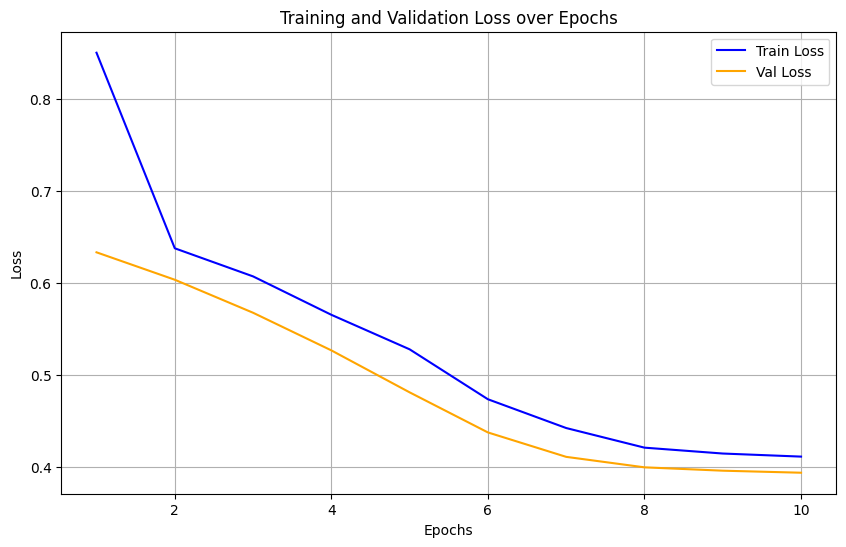

Modèle sauvegardé : bottle_colorization_model.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

=== Évaluation pour le prétexte colorization - Catégorie bottle ===


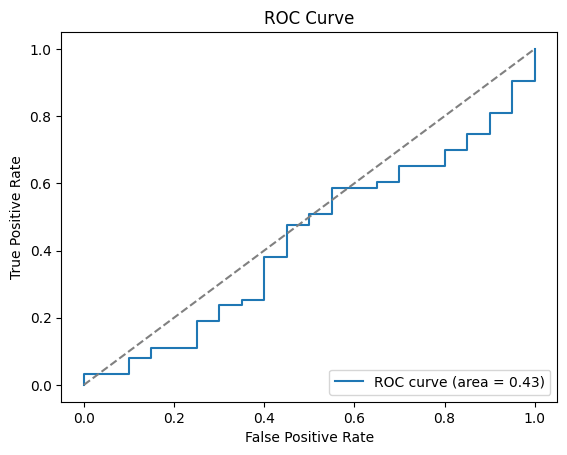

Entraînement pour le prétexte : inpainting
Epoch 1/10, Train Loss: 0.8369, Avg Val Loss: 0.6757
Epoch 2/10, Train Loss: 0.6243, Avg Val Loss: 0.5219
Epoch 3/10, Train Loss: 0.5216, Avg Val Loss: 0.4864
Epoch 4/10, Train Loss: 0.4902, Avg Val Loss: 0.4576
Epoch 5/10, Train Loss: 0.4633, Avg Val Loss: 0.4379
Epoch 6/10, Train Loss: 0.4487, Avg Val Loss: 0.4287
Epoch 7/10, Train Loss: 0.4410, Avg Val Loss: 0.4191
Epoch 8/10, Train Loss: 0.4345, Avg Val Loss: 0.4145
Epoch 9/10, Train Loss: 0.4326, Avg Val Loss: 0.4126
Epoch 10/10, Train Loss: 0.4295, Avg Val Loss: 0.4145


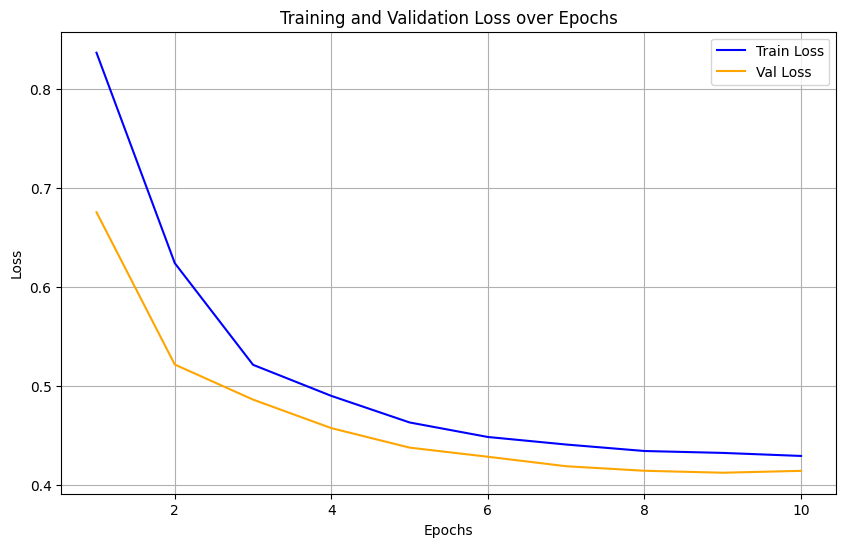

Modèle sauvegardé : bottle_inpainting_model.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

=== Évaluation pour le prétexte inpainting - Catégorie bottle ===


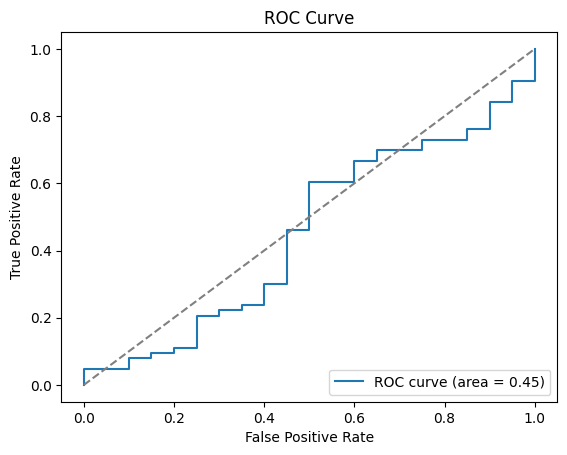

Entraînement pour le prétexte : maskedautoencoder
Epoch 1/10, Train Loss: 0.9953, Avg Val Loss: 0.9791
Epoch 2/10, Train Loss: 0.9957, Avg Val Loss: 0.9791
Epoch 3/10, Train Loss: 0.9951, Avg Val Loss: 0.9791
Epoch 4/10, Train Loss: 0.9955, Avg Val Loss: 0.9791
Epoch 5/10, Train Loss: 0.9953, Avg Val Loss: 0.9791
Epoch 6/10, Train Loss: 0.9952, Avg Val Loss: 0.9791
Epoch 7/10, Train Loss: 0.9953, Avg Val Loss: 0.9791
Epoch 8/10, Train Loss: 0.9955, Avg Val Loss: 0.9791
Epoch 9/10, Train Loss: 0.9956, Avg Val Loss: 0.9791
Epoch 10/10, Train Loss: 0.9954, Avg Val Loss: 0.9791


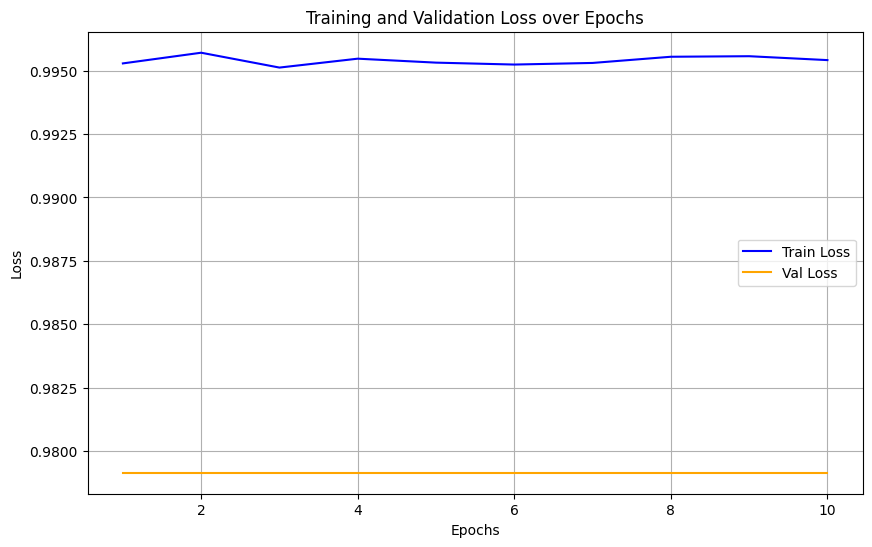

Modèle sauvegardé : bottle_maskedautoencoder_model.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

=== Évaluation pour le prétexte maskedautoencoder - Catégorie bottle ===


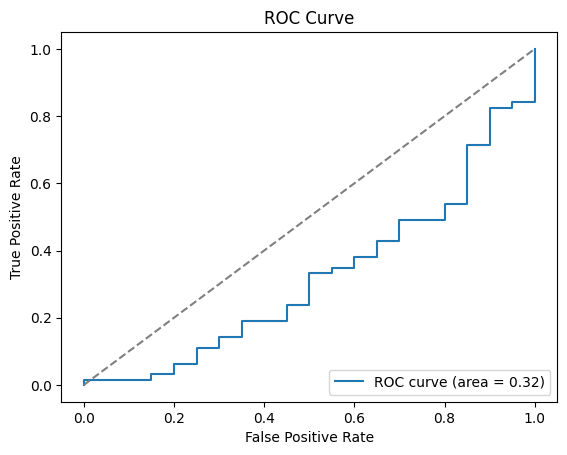

=== Entraînement pour la catégorie capsule ===
Entraînement pour le prétexte : colorization
Epoch 1/10, Train Loss: 0.6047, Avg Val Loss: 0.4751
Epoch 2/10, Train Loss: 0.4618, Avg Val Loss: 0.4367
Epoch 3/10, Train Loss: 0.4394, Avg Val Loss: 0.4302
Epoch 4/10, Train Loss: 0.4328, Avg Val Loss: 0.4236
Epoch 5/10, Train Loss: 0.4252, Avg Val Loss: 0.4115
Epoch 6/10, Train Loss: 0.4088, Avg Val Loss: 0.3987
Epoch 7/10, Train Loss: 0.4030, Avg Val Loss: 0.3973
Epoch 8/10, Train Loss: 0.4011, Avg Val Loss: 0.3954
Epoch 9/10, Train Loss: 0.3996, Avg Val Loss: 0.3948
Epoch 10/10, Train Loss: 0.3985, Avg Val Loss: 0.3902


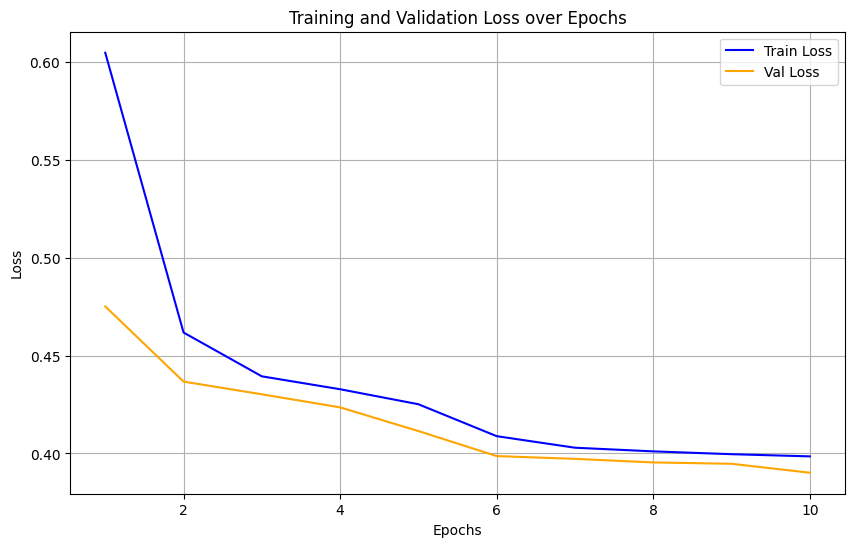

Modèle sauvegardé : capsule_colorization_model.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

=== Évaluation pour le prétexte colorization - Catégorie capsule ===


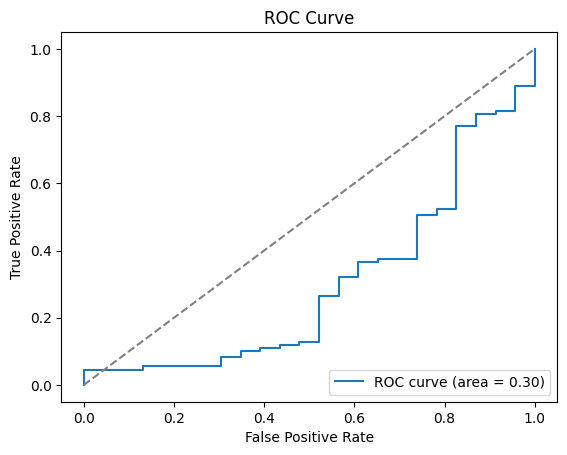

Entraînement pour le prétexte : inpainting
Epoch 1/10, Train Loss: 0.6436, Avg Val Loss: 0.5644
Epoch 2/10, Train Loss: 0.5798, Avg Val Loss: 0.5509
Epoch 3/10, Train Loss: 0.5411, Avg Val Loss: 0.5185
Epoch 4/10, Train Loss: 0.5162, Avg Val Loss: 0.5009
Epoch 5/10, Train Loss: 0.4968, Avg Val Loss: 0.4838
Epoch 6/10, Train Loss: 0.4795, Avg Val Loss: 0.4631
Epoch 7/10, Train Loss: 0.4576, Avg Val Loss: 0.4408
Epoch 8/10, Train Loss: 0.4405, Avg Val Loss: 0.4285
Epoch 9/10, Train Loss: 0.4306, Avg Val Loss: 0.4243
Epoch 10/10, Train Loss: 0.4183, Avg Val Loss: 0.3982


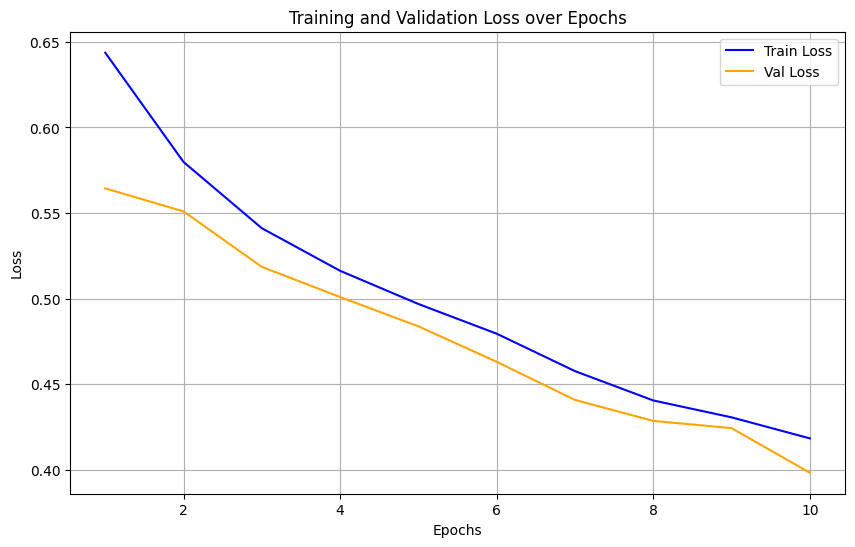

Modèle sauvegardé : capsule_inpainting_model.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

=== Évaluation pour le prétexte inpainting - Catégorie capsule ===


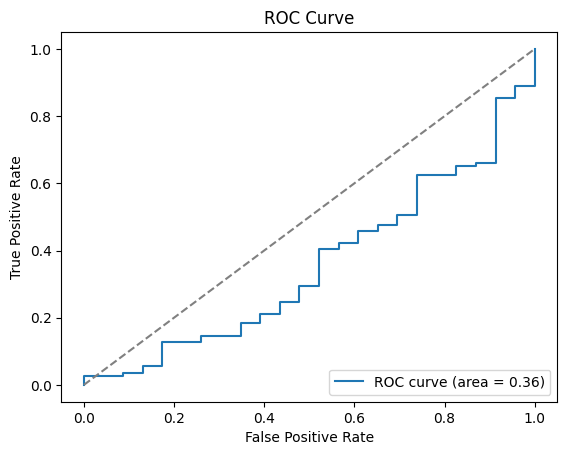

Entraînement pour le prétexte : maskedautoencoder
Epoch 1/10, Train Loss: 0.6901, Avg Val Loss: 0.6831
Epoch 2/10, Train Loss: 0.6905, Avg Val Loss: 0.6831
Epoch 3/10, Train Loss: 0.6901, Avg Val Loss: 0.6831
Epoch 4/10, Train Loss: 0.6897, Avg Val Loss: 0.6831
Epoch 5/10, Train Loss: 0.6898, Avg Val Loss: 0.6831
Epoch 6/10, Train Loss: 0.6901, Avg Val Loss: 0.6831
Epoch 7/10, Train Loss: 0.6901, Avg Val Loss: 0.6831
Epoch 8/10, Train Loss: 0.6902, Avg Val Loss: 0.6831
Epoch 9/10, Train Loss: 0.6902, Avg Val Loss: 0.6831
Epoch 10/10, Train Loss: 0.6899, Avg Val Loss: 0.6831


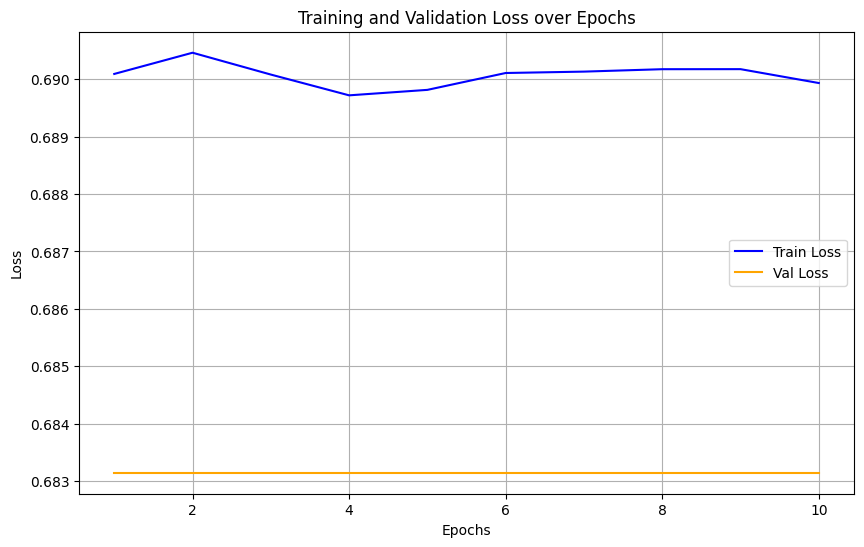

Modèle sauvegardé : capsule_maskedautoencoder_model.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

=== Évaluation pour le prétexte maskedautoencoder - Catégorie capsule ===


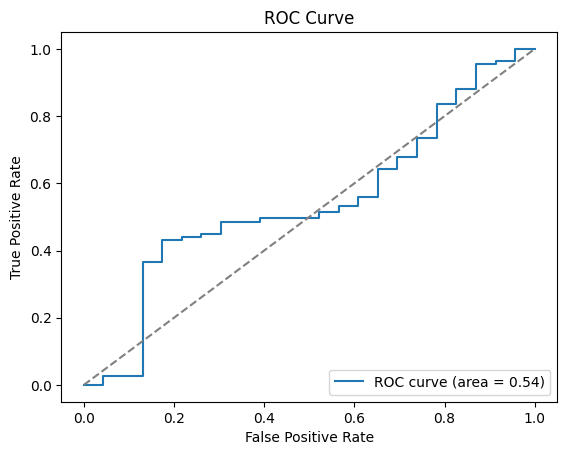

=== Entraînement pour la catégorie hazelnut ===
Entraînement pour le prétexte : colorization
Epoch 1/10, Train Loss: 0.5470, Avg Val Loss: 0.4956
Epoch 2/10, Train Loss: 0.5471, Avg Val Loss: 0.4956
Epoch 3/10, Train Loss: 0.5445, Avg Val Loss: 0.4956
Epoch 4/10, Train Loss: 0.5463, Avg Val Loss: 0.4956
Epoch 5/10, Train Loss: 0.5468, Avg Val Loss: 0.4956
Epoch 6/10, Train Loss: 0.5472, Avg Val Loss: 0.4956
Epoch 7/10, Train Loss: 0.5463, Avg Val Loss: 0.4956
Epoch 8/10, Train Loss: 0.5467, Avg Val Loss: 0.4956
Epoch 9/10, Train Loss: 0.5471, Avg Val Loss: 0.4956
Epoch 10/10, Train Loss: 0.5479, Avg Val Loss: 0.4956


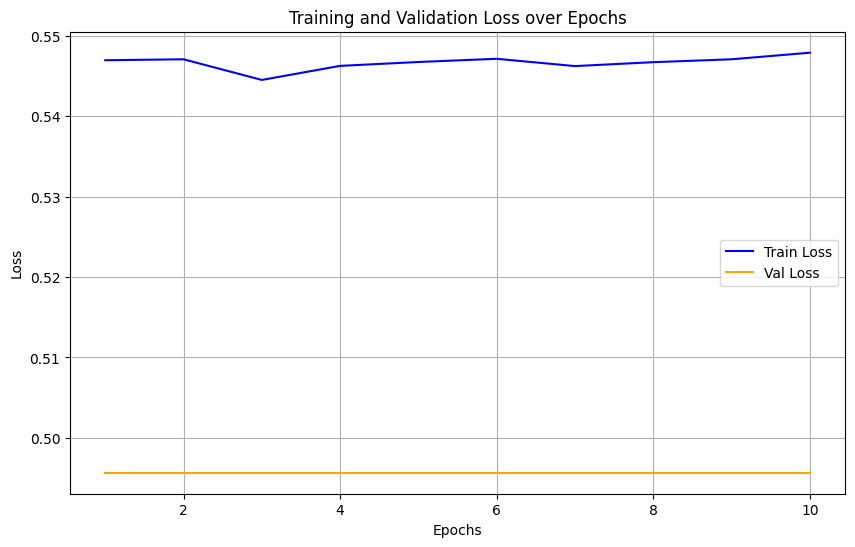

Modèle sauvegardé : hazelnut_colorization_model.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

=== Évaluation pour le prétexte colorization - Catégorie hazelnut ===


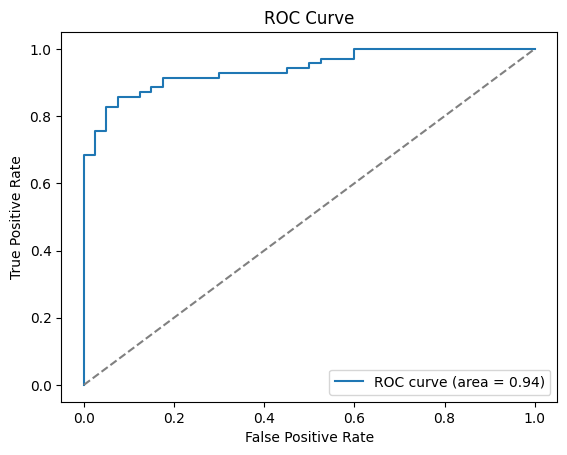

Entraînement pour le prétexte : inpainting
Epoch 1/10, Train Loss: 0.5575, Avg Val Loss: 0.4950
Epoch 2/10, Train Loss: 0.5442, Avg Val Loss: 0.4876
Epoch 3/10, Train Loss: 0.5363, Avg Val Loss: 0.4861
Epoch 4/10, Train Loss: 0.5370, Avg Val Loss: 0.4860
Epoch 5/10, Train Loss: 0.5364, Avg Val Loss: 0.4860
Epoch 6/10, Train Loss: 0.5342, Avg Val Loss: 0.4861
Epoch 7/10, Train Loss: 0.5356, Avg Val Loss: 0.4860
Epoch 8/10, Train Loss: 0.5371, Avg Val Loss: 0.4862
Epoch 9/10, Train Loss: 0.5348, Avg Val Loss: 0.4859
Epoch 10/10, Train Loss: 0.5356, Avg Val Loss: 0.4869


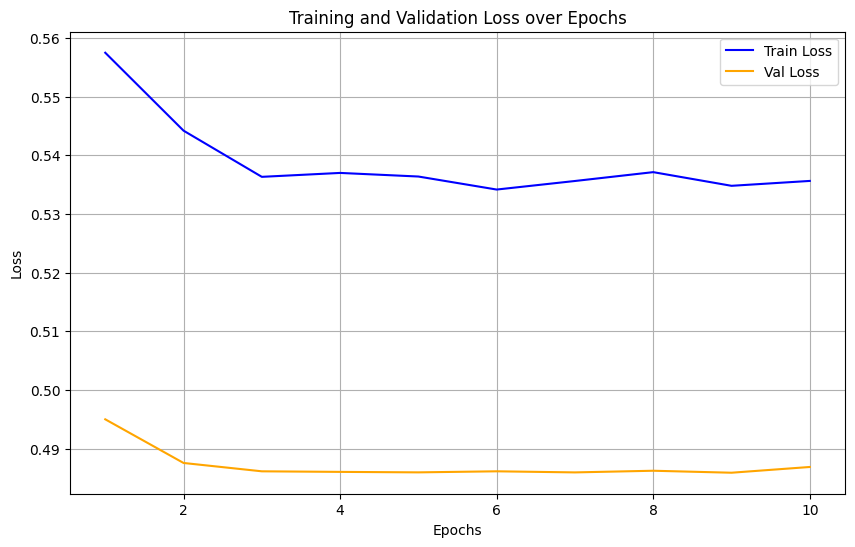

Modèle sauvegardé : hazelnut_inpainting_model.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

=== Évaluation pour le prétexte inpainting - Catégorie hazelnut ===


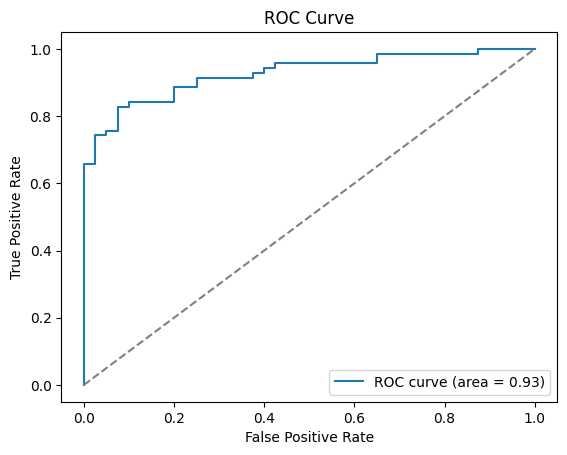

Entraînement pour le prétexte : maskedautoencoder
Epoch 1/10, Train Loss: 0.5478, Avg Val Loss: 0.4957
Epoch 2/10, Train Loss: 0.5459, Avg Val Loss: 0.4956
Epoch 3/10, Train Loss: 0.5476, Avg Val Loss: 0.4956
Epoch 4/10, Train Loss: 0.5470, Avg Val Loss: 0.4956
Epoch 5/10, Train Loss: 0.5469, Avg Val Loss: 0.4956
Epoch 6/10, Train Loss: 0.5463, Avg Val Loss: 0.4956
Epoch 7/10, Train Loss: 0.5477, Avg Val Loss: 0.4956
Epoch 8/10, Train Loss: 0.5483, Avg Val Loss: 0.4956
Epoch 9/10, Train Loss: 0.5463, Avg Val Loss: 0.4956
Epoch 10/10, Train Loss: 0.5455, Avg Val Loss: 0.4956


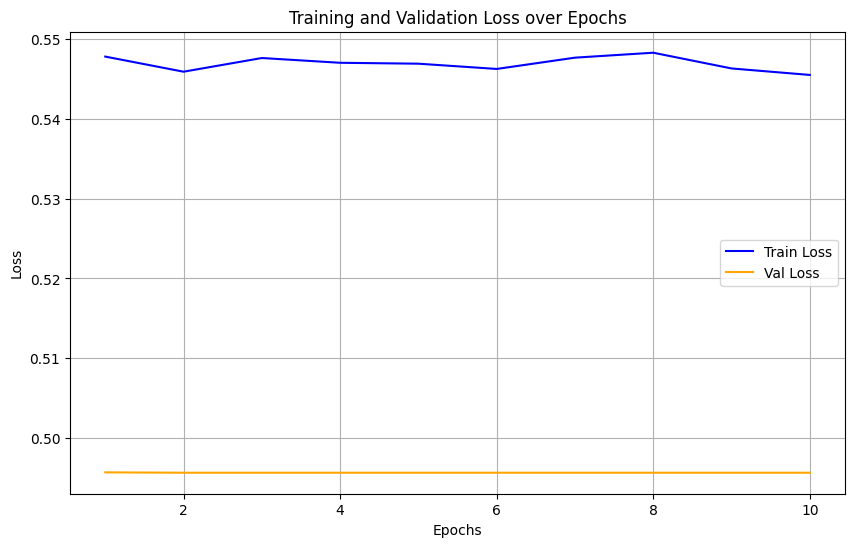

Modèle sauvegardé : hazelnut_maskedautoencoder_model.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

=== Évaluation pour le prétexte maskedautoencoder - Catégorie hazelnut ===


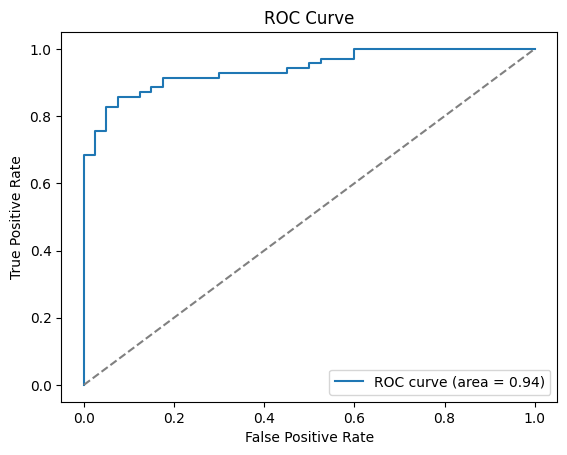

=== Entraînement pour la catégorie toothbrush ===
Entraînement pour le prétexte : colorization
Epoch 1/10, Train Loss: 0.8485, Avg Val Loss: 0.8413
Epoch 2/10, Train Loss: 0.8490, Avg Val Loss: 0.8413
Epoch 3/10, Train Loss: 0.8487, Avg Val Loss: 0.8413
Epoch 4/10, Train Loss: 0.8486, Avg Val Loss: 0.8413
Epoch 5/10, Train Loss: 0.8488, Avg Val Loss: 0.8413
Epoch 6/10, Train Loss: 0.8484, Avg Val Loss: 0.8413
Epoch 7/10, Train Loss: 0.8481, Avg Val Loss: 0.8413
Epoch 8/10, Train Loss: 0.8486, Avg Val Loss: 0.8413
Epoch 9/10, Train Loss: 0.8484, Avg Val Loss: 0.8413
Epoch 10/10, Train Loss: 0.8487, Avg Val Loss: 0.8413


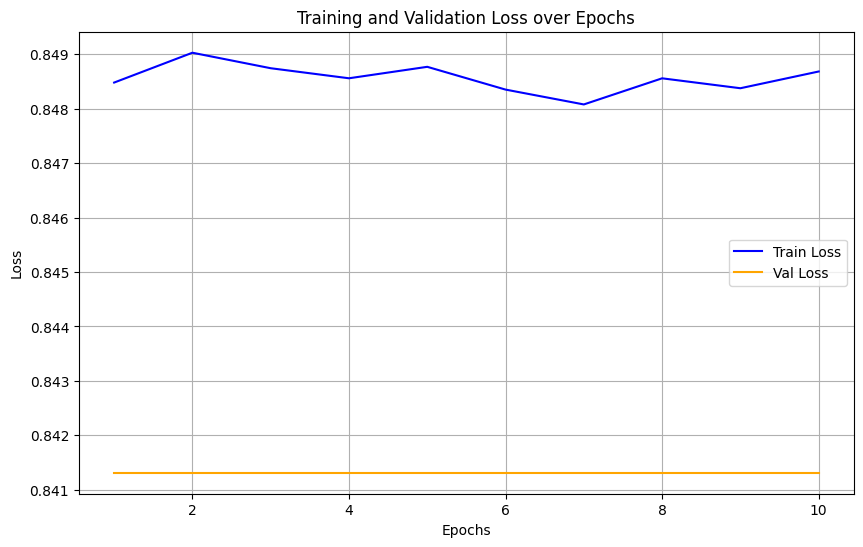

Modèle sauvegardé : toothbrush_colorization_model.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

=== Évaluation pour le prétexte colorization - Catégorie toothbrush ===


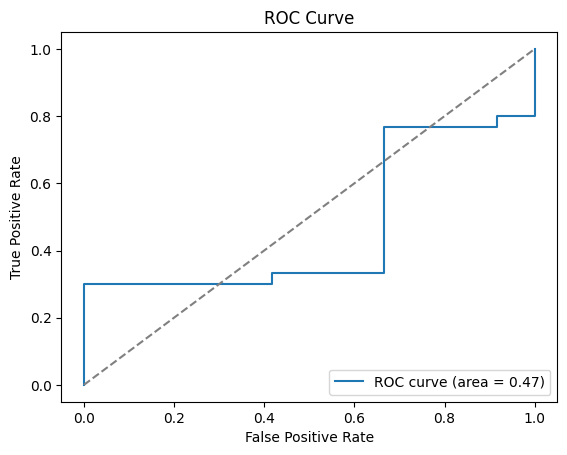

Entraînement pour le prétexte : inpainting
Epoch 1/10, Train Loss: 0.8492, Avg Val Loss: 0.8401
Epoch 2/10, Train Loss: 0.8442, Avg Val Loss: 0.8312
Epoch 3/10, Train Loss: 0.8331, Avg Val Loss: 0.8168
Epoch 4/10, Train Loss: 0.8204, Avg Val Loss: 0.8098
Epoch 5/10, Train Loss: 0.8133, Avg Val Loss: 0.8026
Epoch 6/10, Train Loss: 0.8062, Avg Val Loss: 0.8012
Epoch 7/10, Train Loss: 0.8031, Avg Val Loss: 0.7952
Epoch 8/10, Train Loss: 0.7988, Avg Val Loss: 0.7926
Epoch 9/10, Train Loss: 0.7954, Avg Val Loss: 0.7889
Epoch 10/10, Train Loss: 0.7923, Avg Val Loss: 0.7838


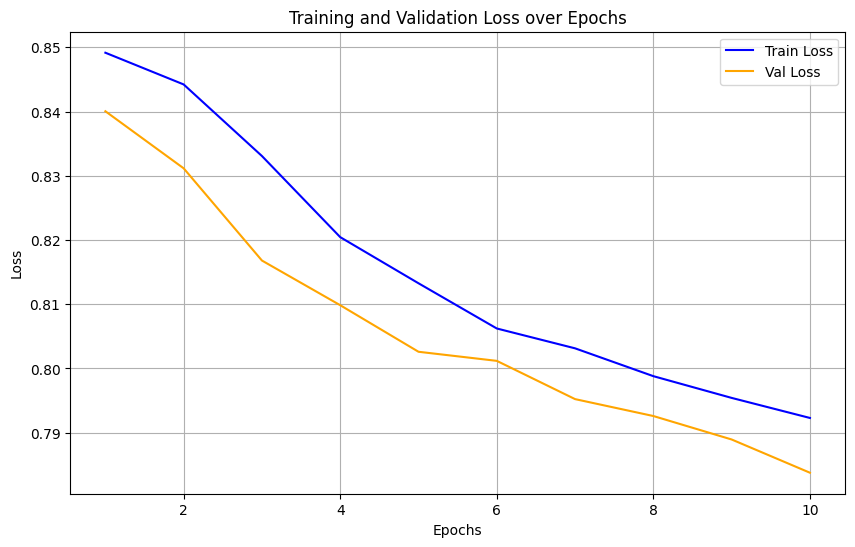

Modèle sauvegardé : toothbrush_inpainting_model.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

=== Évaluation pour le prétexte inpainting - Catégorie toothbrush ===


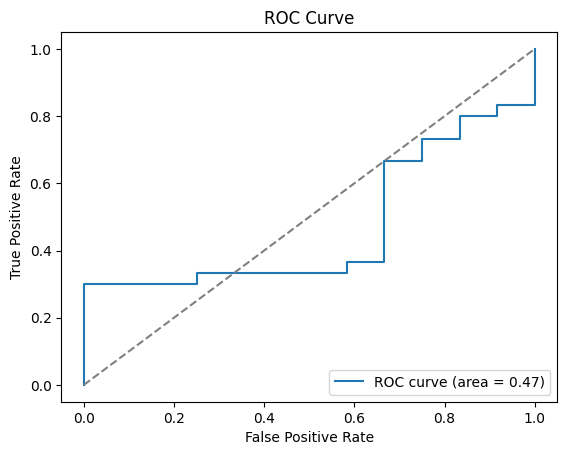

Entraînement pour le prétexte : maskedautoencoder
Epoch 1/10, Train Loss: 0.8768, Avg Val Loss: 0.8552
Epoch 2/10, Train Loss: 0.8544, Avg Val Loss: 0.8376
Epoch 3/10, Train Loss: 0.8445, Avg Val Loss: 0.8362
Epoch 4/10, Train Loss: 0.8430, Avg Val Loss: 0.8321
Epoch 5/10, Train Loss: 0.8375, Avg Val Loss: 0.8220
Epoch 6/10, Train Loss: 0.8274, Avg Val Loss: 0.8140
Epoch 7/10, Train Loss: 0.8175, Avg Val Loss: 0.8078
Epoch 8/10, Train Loss: 0.8105, Avg Val Loss: 0.8031
Epoch 9/10, Train Loss: 0.8051, Avg Val Loss: 0.7965
Epoch 10/10, Train Loss: 0.7978, Avg Val Loss: 0.7913


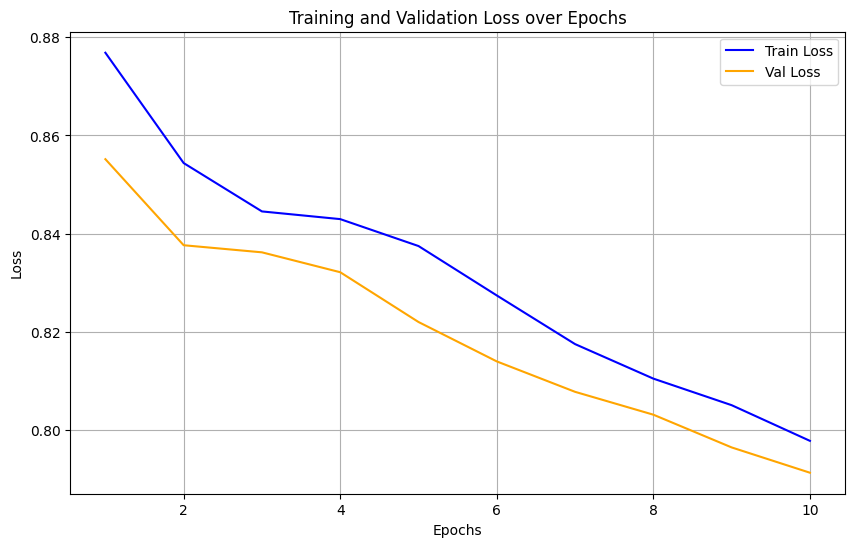

Modèle sauvegardé : toothbrush_maskedautoencoder_model.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

=== Évaluation pour le prétexte maskedautoencoder - Catégorie toothbrush ===


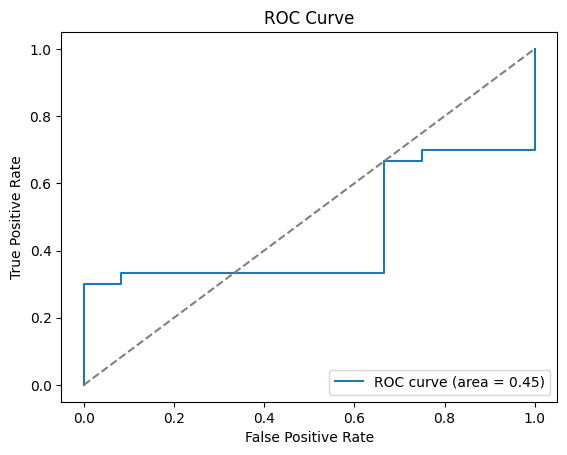

=== Entraînement pour la catégorie engine_wiring ===
Entraînement pour le prétexte : colorization
Epoch 1/10, Train Loss: 0.9471, Avg Val Loss: 0.8931
Epoch 2/10, Train Loss: 0.7967, Avg Val Loss: 0.6810
Epoch 3/10, Train Loss: 0.5511, Avg Val Loss: 0.4896
Epoch 4/10, Train Loss: 0.4566, Avg Val Loss: 0.4281
Epoch 5/10, Train Loss: 0.4075, Avg Val Loss: 0.4005
Epoch 6/10, Train Loss: 0.3859, Avg Val Loss: 0.3836
Epoch 7/10, Train Loss: 0.3731, Avg Val Loss: 0.3743
Epoch 8/10, Train Loss: 0.3638, Avg Val Loss: 0.3651
Epoch 9/10, Train Loss: 0.3567, Avg Val Loss: 0.3603
Epoch 10/10, Train Loss: 0.3519, Avg Val Loss: 0.3566


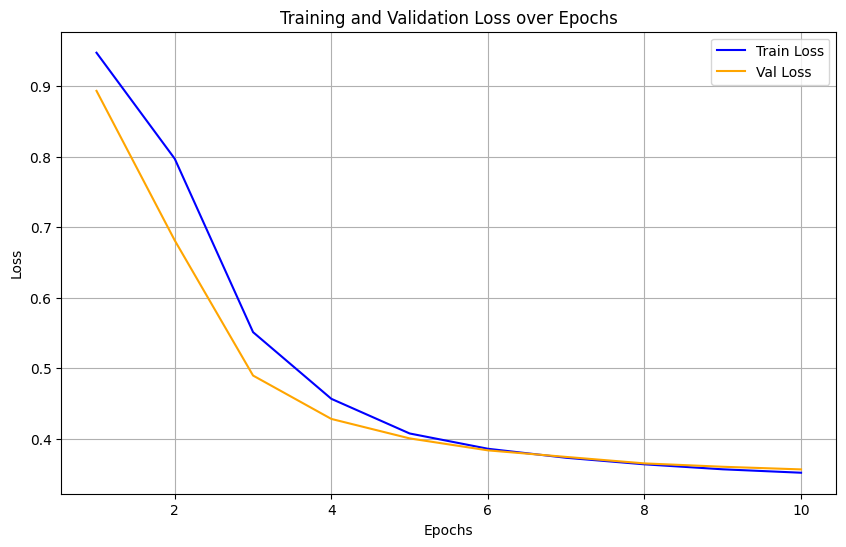

Modèle sauvegardé : engine_wiring_colorization_model.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

=== Évaluation pour le prétexte colorization - Catégorie engine_wiring ===


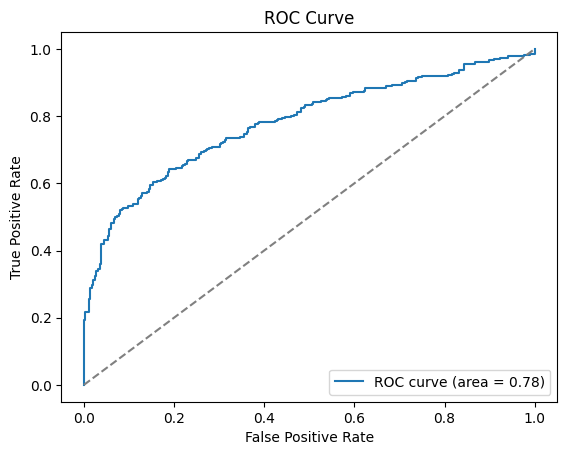

Entraînement pour le prétexte : inpainting
Epoch 1/10, Train Loss: 0.8780, Avg Val Loss: 0.8012
Epoch 2/10, Train Loss: 0.6323, Avg Val Loss: 0.5121
Epoch 3/10, Train Loss: 0.4820, Avg Val Loss: 0.4639
Epoch 4/10, Train Loss: 0.4429, Avg Val Loss: 0.4343
Epoch 5/10, Train Loss: 0.4170, Avg Val Loss: 0.4081
Epoch 6/10, Train Loss: 0.3952, Avg Val Loss: 0.3900
Epoch 7/10, Train Loss: 0.3766, Avg Val Loss: 0.3640
Epoch 8/10, Train Loss: 0.3467, Avg Val Loss: 0.3494
Epoch 9/10, Train Loss: 0.3355, Avg Val Loss: 0.3352
Epoch 10/10, Train Loss: 0.3236, Avg Val Loss: 0.3243


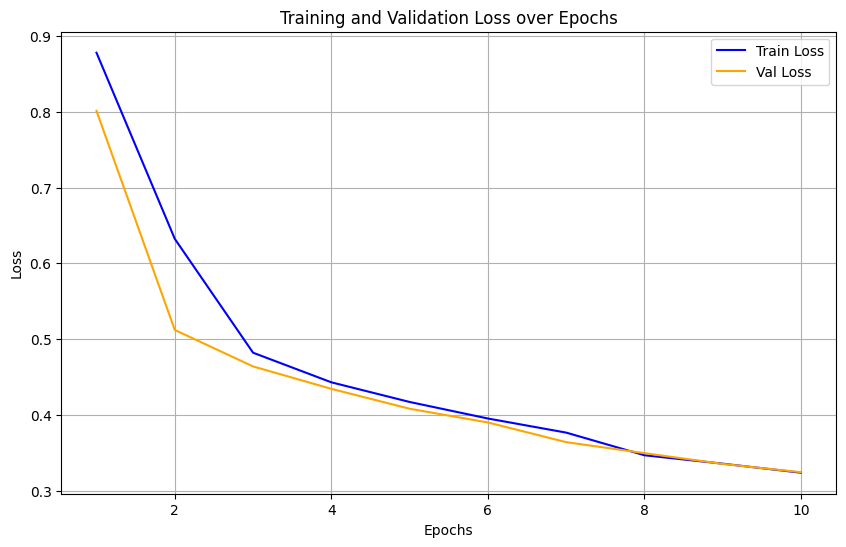

Modèle sauvegardé : engine_wiring_inpainting_model.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

=== Évaluation pour le prétexte inpainting - Catégorie engine_wiring ===


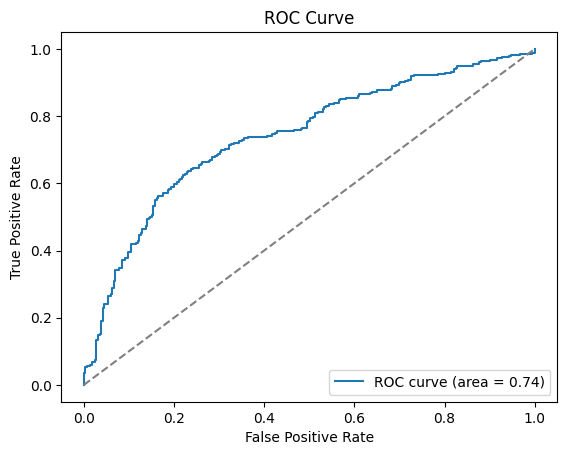

Entraînement pour le prétexte : maskedautoencoder
Epoch 1/10, Train Loss: 0.9418, Avg Val Loss: 0.7062
Epoch 2/10, Train Loss: 0.6123, Avg Val Loss: 0.5043
Epoch 3/10, Train Loss: 0.4565, Avg Val Loss: 0.4187
Epoch 4/10, Train Loss: 0.3903, Avg Val Loss: 0.3772
Epoch 5/10, Train Loss: 0.3567, Avg Val Loss: 0.3427
Epoch 6/10, Train Loss: 0.3208, Avg Val Loss: 0.3140
Epoch 7/10, Train Loss: 0.3051, Avg Val Loss: 0.3046
Epoch 8/10, Train Loss: 0.2963, Avg Val Loss: 0.2990
Epoch 9/10, Train Loss: 0.2890, Avg Val Loss: 0.2932
Epoch 10/10, Train Loss: 0.2834, Avg Val Loss: 0.2886


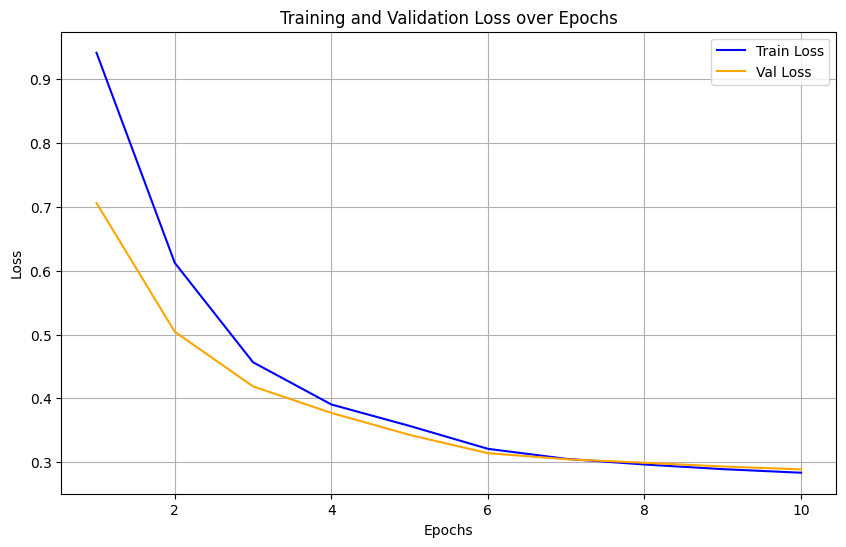

Modèle sauvegardé : engine_wiring_maskedautoencoder_model.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

=== Évaluation pour le prétexte maskedautoencoder - Catégorie engine_wiring ===


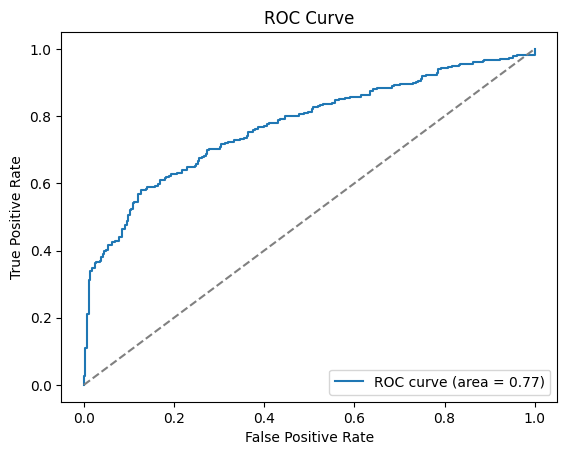

bottle - colorization: AUROC = 0.43
bottle - inpainting: AUROC = 0.45
bottle - maskedautoencoder: AUROC = 0.32
capsule - colorization: AUROC = 0.30
capsule - inpainting: AUROC = 0.36
capsule - maskedautoencoder: AUROC = 0.54
hazelnut - colorization: AUROC = 0.94
hazelnut - inpainting: AUROC = 0.93
hazelnut - maskedautoencoder: AUROC = 0.94
toothbrush - colorization: AUROC = 0.47
toothbrush - inpainting: AUROC = 0.47
toothbrush - maskedautoencoder: AUROC = 0.45
engine_wiring - colorization: AUROC = 0.78
engine_wiring - inpainting: AUROC = 0.74
engine_wiring - maskedautoencoder: AUROC = 0.77


In [ ]:
# Lancer le pipeline pour tout les prétextes et toutes les catégories de données
results = run_pipeline_multiple_pretexts(data_loaders_dict, pretexts=["colorization", "inpainting", "maskedautoencoder"], num_epochs=10)

# Afficher les résultats
for category, pretext_results in results.items():
    for pretext, result in pretext_results.items():
        print(f"{category} - {pretext}: AUROC = {result['roc_auc']:.2f}")


Analyse des résultats du premier essai naïf :
- **Catégorie bottle** : les modèles colorization et inpainting apprennent correctement lors de l'entrainement, en revanche le modèle MAE n'apprend pas et aucuns des modèles n'est performant pour la detection d'anomalies.
- **Catégorie capsule** : résultats similaires à la catégorie bottle mais le modèle inpainting n'as encore convergé à la fin des 10 epochs.
- **Catégorie hazelnut** : ici les résultats sont étranges, aucun des modèles ne fait un réel apprentissage en revanche ils sont tous performants pour la detection d'anomalies.
- **Catégorie toothbrush** : le colorization modèle n'apprend pas, les deux autres apprennent mais n'ont pas encore convergé à la fin des epochs, aucuns n'est performant pour la detection d'anomalies.
- **Catégorie engine_wiring** : ici tous les modèles apprennent (même si l'apprentissage peut être poursuivi avec plus d'epochs) et obtiennent des performances relativement bonnes sur la detection d'anomalies.

# Affichage des anomalies pour adpater les modèles à chaque catégorie d'image

In [ ]:
def calculate_mse(img1, img2):
    """
    Calcule la Mean Squared Error (MSE) entre deux images.

    Args:
        img1 (PIL.Image): Première image.
        img2 (PIL.Image): Deuxième image.

    Returns:
        float: La MSE entre les deux images.
    """
    img1 = torch.tensor(np.array(img1).astype(np.float32)).permute(2, 0, 1).unsqueeze(0)  # Convertir en tenseur PyTorch
    img2 = torch.tensor(np.array(img2).astype(np.float32)).permute(2, 0, 1).unsqueeze(0)  # Convertir en tenseur PyTorch

    loss = F.mse_loss(img1, img2, reduction='none')  # Perte par pixel
    per_image_loss = loss.mean(dim=(1, 2, 3))  # Moyenne spatiale pour chaque image
    return per_image_loss.item()

def display_anomalies(data_dir):
    """
    Affiche une image pour chaque type d'anomalie dans les données de test et calcule la MSE entre une image "good" et une image d'anomalie.

    Args:
        data_dir (str): Chemin racine du dataset.
    """
    categories = os.listdir(data_dir)  # Liste des catégories

    for category in categories:
        category_path = os.path.join(data_dir, category, "test")
        good_path = os.path.join(data_dir, category, "train", "good")
        if not os.path.exists(category_path) or not os.path.exists(good_path):
            continue  # Ignorer si le dossier n'existe pas

        print(f"Catégorie : {category}")
        anomaly_types = [d for d in os.listdir(category_path) if os.path.isdir(os.path.join(category_path, d))]

        # Charger une image "good"
        good_images = [os.path.join(good_path, img) for img in os.listdir(good_path) if img.endswith(('.png', '.jpg', '.jpeg'))]
        if not good_images:
            print(f"  Aucun fichier 'good' trouvé pour la catégorie : {category}")
            continue
        good_image = Image.open(good_images[0])

        fig, axs = plt.subplots(1, len(anomaly_types), figsize=(15, 5))
        if len(anomaly_types) == 1:
            axs = [axs]  # Si une seule anomalie, convertir en liste

        for ax, anomaly in zip(axs, anomaly_types):
            anomaly_path = os.path.join(category_path, anomaly)
            images = os.listdir(anomaly_path)

            if not images:
                print(f"  Aucun fichier pour l'anomalie : {anomaly}")
                continue

            # Charger jusqu'à 5 images d'anomalie
            anomaly_images = [os.path.join(anomaly_path, img) for img in images[:5]]
            mse_values = []

            for img_path in anomaly_images:
                with Image.open(img_path) as img:
                    mse = calculate_mse(good_image, img)
                    mse_values.append(mse)

            avg_mse = np.mean(mse_values)
            print(f"  MSE moyenne pour l'anomalie {anomaly} : {avg_mse:.2f}")

            # Afficher la première image d'anomalie
            with Image.open(anomaly_images[0]) as img:
                ax.imshow(img)
                ax.set_title(anomaly)
                ax.axis("off")

        plt.suptitle(f"Catégorie : {category}")
        plt.show()

Catégorie : capsule
  MSE moyenne pour l'anomalie crack : 69.54
  MSE moyenne pour l'anomalie scratch : 72.32
  MSE moyenne pour l'anomalie poke : 78.95
  MSE moyenne pour l'anomalie good : 65.57
  MSE moyenne pour l'anomalie faulty_imprint : 62.40
  MSE moyenne pour l'anomalie squeeze : 159.61


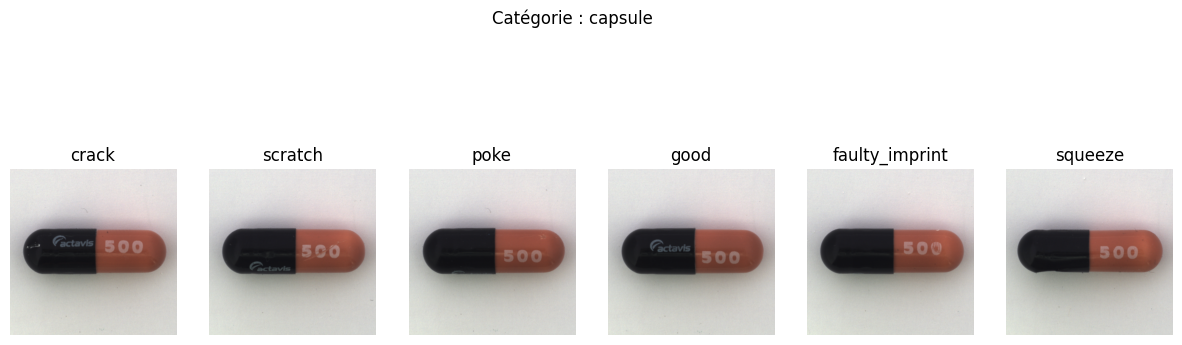

Catégorie : hazelnut
  MSE moyenne pour l'anomalie crack : 247.64
  MSE moyenne pour l'anomalie print : 514.72
  MSE moyenne pour l'anomalie good : 202.17
  MSE moyenne pour l'anomalie cut : 238.68
  MSE moyenne pour l'anomalie hole : 212.20


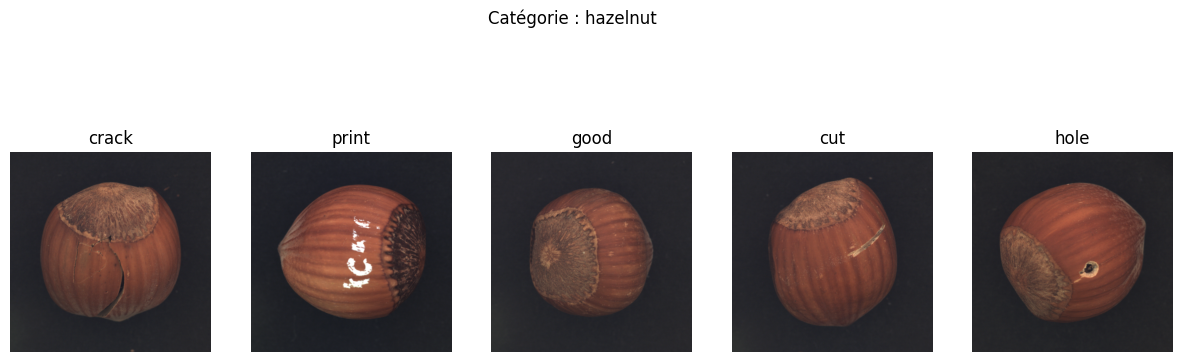

Catégorie : engine_wiring
  MSE moyenne pour l'anomalie fastening : 3335.79
  MSE moyenne pour l'anomalie multiple : 5061.35
  MSE moyenne pour l'anomalie cardboard : 21525.07
  MSE moyenne pour l'anomalie blue_hoop : 3884.03
  MSE moyenne pour l'anomalie good : 3452.24
  MSE moyenne pour l'anomalie obstruction : 5172.66


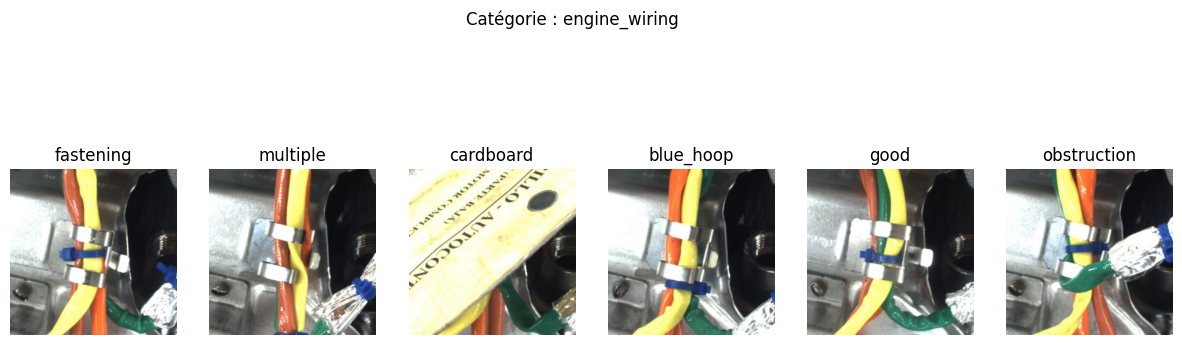

Catégorie : toothbrush
  MSE moyenne pour l'anomalie defective : 421.52
  MSE moyenne pour l'anomalie good : 213.50


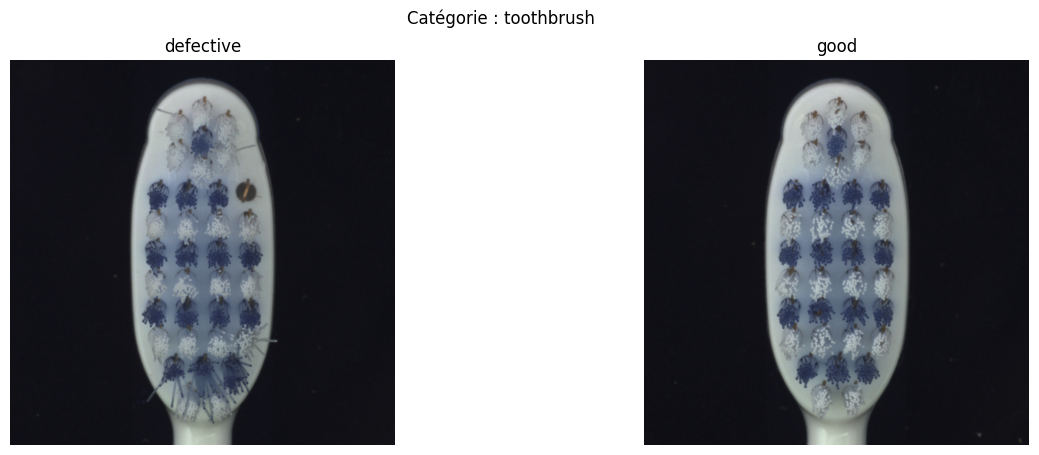

Catégorie : bottle
  MSE moyenne pour l'anomalie broken_small : 391.09
  MSE moyenne pour l'anomalie broken_large : 436.08
  MSE moyenne pour l'anomalie good : 242.99
  MSE moyenne pour l'anomalie contamination : 545.82


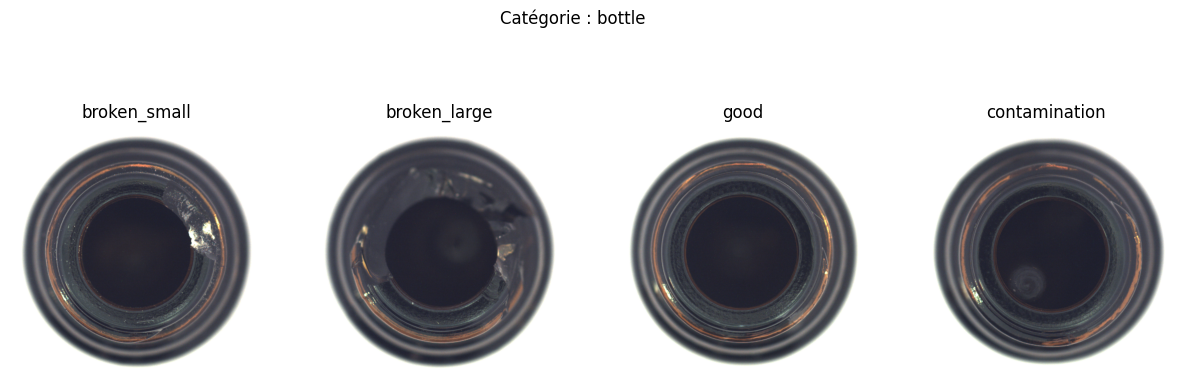

In [ ]:
display_anomalies("data/")

Les anomalies sont le plus souvent basées sur des détails fin. Il faut donc réfléchir pour les catégories qui en ont besoin à baisser le masking ratio du MAE pour faciliter l'apprentissage des structures plus fines des images, à adpater les tailles de masques pour l'inpainting (masques plus fins pour les anomalies complexes et fines).

Afin de capturer plus de détails fin on peut aussi réflechir à une architecture plus sensible : une plus grande dimension latente, des tailles de filtres plus petites, voir un modèle de type Unet avec des skip connexions pour une meilleure reconstruction des détails fin de l'image.

Pour les catégories complexes avec beaucoup de détails fin on peut aussi abaisser le taux d'apprentissage.

## Inspection des tailles de masques et des mask_ratio

In [ ]:
def create_test_batch(data_dirs, transform, device='cpu'):
    """
    Crée un mini-batch de test contenant une image "good" par catégorie.

    Args:
        data_dir (str): Chemin vers le répertoire contenant les données.
        categories (list): Liste des noms des catégories (ex. ['capsule', 'hazelnuts']).
        transform (torchvision.transforms.Compose): Transformations à appliquer aux images.
        device (str): Appareil sur lequel charger les données ('cpu' ou 'cuda').

    Returns:
        torch.Tensor: Batch d'images (Tensor de taille (batch_size, channels, H, W)).
    """
    images = []
    for category, good_dir in data_dirs.items():
        # Liste des images dans le répertoire "good"
        image_files = [f for f in os.listdir(good_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        if not image_files:
            raise FileNotFoundError(f"Aucune image trouvée dans {good_dir}")

        # Charger la première image "good" trouvée
        image_path = os.path.join(good_dir, image_files[0])
        image = Image.open(image_path).convert('RGB')
        image = transform(image)  # Appliquer les transformations
        images.append(image)

    # Empiler les images pour créer un batch
    batch = torch.stack(images).to(device)
    return batch


# Transformations pour les images
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),         # Pas besoin de renormaliser on veut visualiser les masques
])

# Dossier racine des données
data_dir_dict = {
    'bottle': 'data/bottle/train/good',
    'capsule': 'data/capsule/train/good',
    'hazelnut': 'data/hazelnut/train/good',
    'toothbrush': 'data/toothbrush/train/good',
    'engine_wiring': 'data/engine_wiring/train/good'
}

# Créer le batch de test
test_batch = create_test_batch(data_dir_dict, transform, device)

print(f"Batch size : {test_batch.shape}")  # Affiche la forme du batch

Batch size : torch.Size([5, 3, 256, 256])


In [ ]:
# Fonction pour tester différents niveaux de mask_ratio
def test_MAE(x, mask_ratio):
        x_masked = x.clone()
        mask = torch.rand_like(x[0, :, :]) < mask_ratio
        mask = mask.unsqueeze(0).repeat(x.size(0), 1, 1)
        x_masked[mask] = 0
        return x_masked

# Fonction pour tester différentes tailles de mask
def test_inpainting(x, mask_size, num_mask = 2, categorie="bottle"):
        masked_x = x.clone()
        for _ in range(num_mask):
                if categorie == "bottle":
                        ul_x = np.random.randint(10, x.size(1) - mask_size + 1 -10)
                        ul_y = np.random.randint(10, x.size(2) - mask_size + 1 - 10)
                elif categorie == "capsule":
                        ul_x = np.random.randint(90, 160)
                        ul_y = np.random.randint(15, x.size(2) - mask_size + 1 -15)
                elif categorie == "hazelnut":
                        ul_x = np.random.randint(25, x.size(1) - mask_size + 1 -25)            # On force (de manière approximative) le mask à être au niveau de l'objet
                        ul_y = np.random.randint(25, x.size(2) - mask_size + 1 -25)
                elif categorie == "toothbrush":
                        ul_x = np.random.randint(0, x.size(1) - mask_size + 1)
                        ul_y = np.random.randint(90, 160)
                elif categorie == "engine_wiring":
                        ul_x = np.random.randint(0, x.size(1) - mask_size + 1)
                        ul_y = np.random.randint(0, x.size(2) - mask_size + 1)
                masked_x[:, ul_x:ul_x+mask_size, ul_y:ul_y+mask_size] = 0

        return masked_x

In [ ]:
def visualize_masks(test_batch, mask_sizes, mask_ratios,category):
    """
    Test différentes tailles de masques (mask_size) pour InpaintingModel et
    ratios de masques (mask_ratio) pour MaskedAutoencoderModel, puis affiche les résultats.

    Args:
        x: Batch d'images d'entrée (Tensor PyTorch de taille (batch_size, channels, H, W)).
        mask_sizes: Liste des tailles de masques pour InpaintingModel.
        mask_ratios: Liste des ratios de masques pour MaskedAutoencoderModel.
    """

    fig, axes = plt.subplots(len(mask_sizes) + len(mask_ratios), 5, figsize=(10, 3 * (len(mask_sizes) + len(mask_ratios))))
    fig.tight_layout()

    # Tester différentes tailles de masques pour InpaintingModel
    for i, mask_size in enumerate(mask_sizes):
        for j, im in enumerate(test_batch):
            x_masked = test_inpainting(im, mask_size, num_mask = 2, categorie=category[j])

            # Afficher l'original, masqué et reconstruit
            axes[i, j].imshow(x_masked.permute(1, 2, 0).cpu().numpy())
            axes[i, j].set_title(f"{mask_size}")
            #axes[i, j].axis("off")

    # Tester différents ratios de masques pour MaskedAutoencoderModel
    for h, mask_ratio in enumerate(mask_ratios):
        for g, im in enumerate(test_batch):
            x_masked = test_MAE(im, mask_ratio=mask_ratio)
            # Afficher l'original, masqué et reconstruit
            axes[h+len(mask_sizes), g].imshow(x_masked.permute(1, 2, 0).cpu().numpy())
            axes[h+len(mask_sizes), g].set_title(f"{mask_ratio:.2f}")
            axes[h+len(mask_sizes), g].axis("off")

    plt.show()


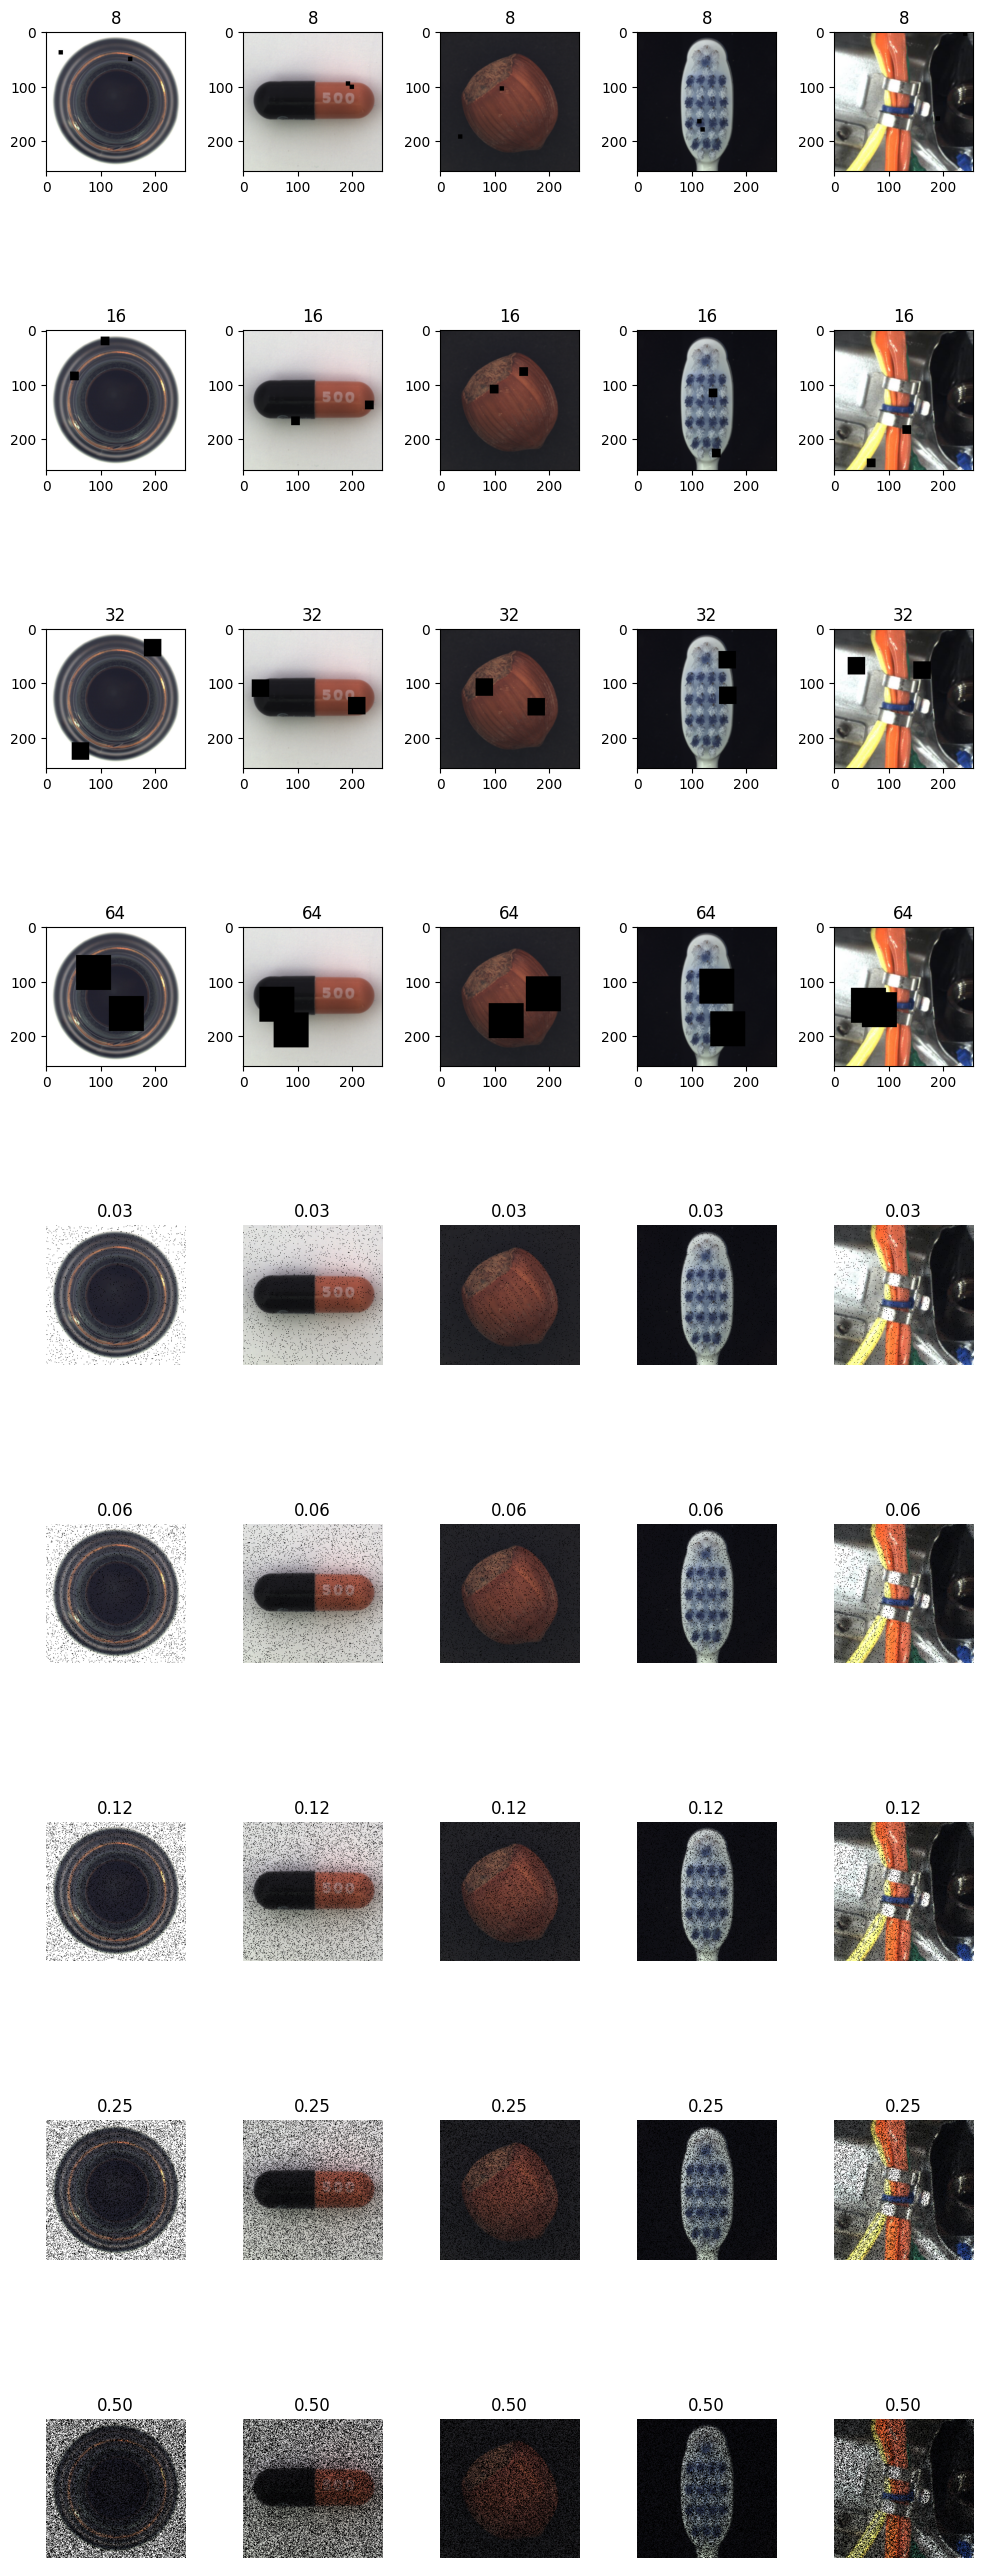

In [ ]:
mask_sizes = [8, 16, 32, 64]
mask_ratios = [1/32, 1/16, 1/8, 1/4, 1/2]
category = ["bottle", "capsule", "hazelnut", "toothbrush", "engine_wiring"]
visualize_masks(test_batch, mask_sizes, mask_ratios, category)

Au vu des résultats sur les mask_sizes, pour les catégories avec des détails très fins comme capsule et toothbrush il faudrait utiliser des masques plus petits (taille 16) et en plus grand nombre (3 ou 4), pour les autres catégories on peut utiliser des masques un plus grands de taille 32 et en plus petit nombre (2 ou 3).

Pour le mask_ratio il faut rester en à 1/16 ou en dessous, sinon la tâche de reconstruction va devenir trop complexe pour les modèles que nous utilisons et le temps d'entrainement que nous pouvons nous permettre.

# Architecture Unet et adaptation des pretext aux catégories

## Architecture Unet

Le modèle UNet est une architecture de réseau convolutif. Il se caractérise par une structure encodeur-décodeur avec des skip-connexions qui permettent au modèle de capturer efficacement les caractéristiques de bas niveau et de haut niveau.

![](https://github.com/wikistat/AI-Frameworks/blob/website/docs/img/AU_UNet.png?raw=true)

<img src="https://github.com/manonlcvp/Projet-HDDL/blob/main/Notebooks/Projet%203/Unet_schema.png?raw=1" alt="Schéma du modèle Unet implémenté" width="900">

Crédits : Ces images ont été récupérées du TP d'image de Mr David Bertoin

In [25]:
def double_conv(in_channels, out_channels):
    # renvoie un bloc composé de deux couches de convolution avec la fonction d'activation ReLU
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU()
    )

class DownSampleBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_block = double_conv(in_channels, out_channels)
        self.maxpool = nn.MaxPool2d(2)

    def forward(self, x):
        x_skip = self.conv_block(x)
        x = self.maxpool(x_skip)

        return x , x_skip

class UpSampleBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_block = double_conv(in_channels, out_channels)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x, x_skip):
        x = self.upsample(x)
        x = torch.cat([x, x_skip], dim=1)
        x = self.conv_block(x)

        return x


class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()

        self.downsample_block_1 = DownSampleBlock(in_channels, 64)
        self.downsample_block_2 = DownSampleBlock(64, 128)
        self.middle_conv_block = double_conv(128, 256)


        self.upsample_block_2 = UpSampleBlock(128 + 256, 128)
        self.upsample_block_1 = UpSampleBlock(128 + 64, 64)

        self.last_conv = nn.Conv2d(64, out_channels, 1)


    def forward(self, x):
        x, x_skip1 = self.downsample_block_1(x)
        x, x_skip2 = self.downsample_block_2(x)

        x = self.middle_conv_block(x)

        x = self.upsample_block_2(x, x_skip2)
        x = self.upsample_block_1(x, x_skip1)

        out = self.last_conv(x)

        return out

## Pretext

In [26]:
# Même modèle que lors du premier essai
class ColorizationModel(nn.Module):
    def __init__(self):
        super(ColorizationModel, self).__init__()
        self.Model = UNet(in_channels=1, out_channels=3)

    def forward(self, x):
        grayscale_x = transforms.Grayscale()(x)
        x_hat = self.Model(grayscale_x)
        return x_hat, grayscale_x


# Modèle d'inpainting avec la taille et le nombre de masques ajustable
class InpaintingModel(nn.Module):
    def __init__(self, mask_size=32, num_mask=2, category="bottle"):
        super(InpaintingModel, self).__init__()
        self.Model = UNet()
        self.mask_size = mask_size
        self.category = category
        self.num_mask = num_mask

    def apply_mask(self, x):
        masked_x = x.clone()

        for i in range(masked_x.size(0)):

          for _ in range(self.num_mask):

            if self.category == "bottle":
                ul_x = np.random.randint(10, x.size(2) - self.mask_size + 1 -10)
                ul_y = np.random.randint(10, x.size(3) - self.mask_size + 1 - 10)
            elif self.category == "capsule":
                ul_x = np.random.randint(90, 160)
                ul_y = np.random.randint(15, x.size(3) - self.mask_size + 1 -15)
            elif self.category == "hazelnut":
                ul_x = np.random.randint(25, x.size(2) - self.mask_size + 1 -25)
                ul_y = np.random.randint(25, x.size(3) - self.mask_size + 1 -25)
            elif self.category == "toothbrush":
                ul_x = np.random.randint(0, x.size(2) - self.mask_size + 1)
                ul_y = np.random.randint(90, 160)
            elif self.category == "engine_wiring":
                ul_x = np.random.randint(0, x.size(2) - self.mask_size + 1)
                ul_y = np.random.randint(0, x.size(3) - self.mask_size + 1)

            masked_x[i, :, ul_x:ul_x+self.mask_size, ul_y:ul_y+self.mask_size] = 0

        return masked_x

    def forward(self, x):
        x_masked = self.apply_mask(x)
        x_hat = self.Model(x_masked)
        return x_hat, x_masked



# Même modèle que lors du premier essai
class MaskedAutoencoderModel(nn.Module):
    def __init__(self, mask_ratio=1/16):
        super(MaskedAutoencoderModel, self).__init__()
        self.Model = UNet()
        self.mask_ratio = mask_ratio

    def apply_mask(self, x):
        x_masked = x.clone()
        mask = torch.rand_like(x[:, 0, :, :]) < self.mask_ratio
        mask = mask.unsqueeze(1).repeat(1, x.size(1), 1, 1)
        x_masked[mask] = 0
        return x_masked

    def forward(self, x):
        x_masked = self.apply_mask(x)
        x_hat = self.Model(x_masked)
        return x_hat, x_masked

## Définition d'une nouvelle perte qui prend en compte les similarités structurelles

In [16]:
from torchmetrics.functional import multiscale_structural_similarity_index_measure as ms_ssim

La mesure de l'indice de similarité structurelle multi-échelle (MS-SSIM) est une fonction de perte perceptuelle utilisée pour mesurer la similarité structurelle entre deux images à plusieurs échelles. Elle étend la mesure SSIM traditionnelle en incorporant les détails de l'image à différentes résolutions, ce qui la rend plus robuste pour évaluer la qualité de l'image.

Combinée à la MSE, elle permet d'équilibrer la précision au niveau des pixels et la qualité perceptuelle / la reconstruction des structures.

In [17]:
# Définition de la perte combinée MSE + MS-SSIM
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5, reduction='mean', reduction2='elementwise_mean'):
        """
        Initialise une perte combinée de MSE et MS-SSIM.

        Args:
            alpha (float): Poids de la MSE dans la combinaison (0 <= alpha <= 1).
            reduction (str): Méthode de réduction pour la MSE ('mean', 'sum', 'none').
            reduction2 (str): Si elementwise_mean, moyenne sur le batch pour MS-SSIM. Si None, applique par image.
        """
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.reduction = reduction
        self.reduction2 = reduction2
        self.mse_loss = nn.MSELoss(reduction=self.reduction)

    def forward(self, output, target):
        """
        Calcule la perte combinée MSE + MS-SSIM.

        Args:
            output (torch.Tensor): Prédictions du modèle.
            target (torch.Tensor): Données cibles.

        Returns:
            torch.Tensor: Valeur de la perte combinée.
        """
        # Calcul de la perte MSE
        if self.reduction=='none': # perte par image pour l'evaluation
          mse = self.mse_loss(output, target)
          mse = mse.mean(dim=(1, 2, 3))
        else:
          mse = self.mse_loss(output, target) # perte pour le batch pour l'entrainement

        # Calcul de la perte MS-SSIM
        ms_ssim_value = ms_ssim(output,target,
            data_range=1.0,       # Plage des données d'entrée (1.0 pour données normalisées, 255 pour valeurs non normalisées).
            reduction=self.reduction2)  # Moyenne sur le batch ou par image

        ms_ssim_loss = 1 - ms_ssim_value  # Transformer MS-SSIM en une perte

        # Combinaison des deux pertes
        combined_loss = self.alpha * mse + (1 - self.alpha) * ms_ssim_loss
        return combined_loss


## Fonction d'entrainement avec une nouvelle perte

In [27]:
def train_ssl_model(model, train_loader, test_loader, optimizer, criterion=CombinedLoss(alpha=0.5, reduction='mean', reduction2='elementwise_mean'), device="cuda", epochs=20, accumulation_steps=2):
    """
    Entraîne un modèle SSL sur les données d'entraînement et trace les courbes de perte.

    Args:
        model (nn.Module): Modèle SSL à entraîner.
        train_loader (DataLoader): DataLoader pour les données d'entraînement.
        test_loader (DataLoader): DataLoader pour les données de validation.
        criterion (CombinedLoss): Fonction de perte combinée (MSE + MS-SSIM).
        optimizer (Optimizer): Optimiseur pour la mise à jour des poids.
        device (str): Périphérique (e.g., "cuda" ou "cpu").
        epochs (int): Nombre d'époques.
        accumulation_steps: The number of batches to accumulate gradients over.
    """
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.to(device)
        model.train()
        total_train_loss = 0

        i = 0
        for images, _ in train_loader:  # Ignore les labels
            images = images.to(device)
            optimizer.zero_grad()

            # Passage avant
            outputs, _ = model(images)

            # Calcul de la perte
            loss = criterion(outputs, images)
            loss = loss / accumulation_steps
            loss.backward()

            # Mise à jour des poids un batch sur 2 à cause des capacités limitées en VRAM de la version gratuite des GPU de google colab
            if (i + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            total_train_loss += loss.item()
            i += 1

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Évaluation sur le jeu de validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for images, _ in test_loader:
                images = images.to(device)

                # Passage avant
                outputs, _ = model(images)

                # Calcul de la perte
                val_loss = criterion(outputs, images)
                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(test_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Trace les pertes
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs+1), train_losses, label='Train Loss', color='blue')
    plt.plot(range(1, epochs+1), val_losses, label='Val Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

    return model

## Fonction d'evaluation avec une nouvelle perte

In [28]:
def evaluate_ssl_model(model, test_loader, criterion= CombinedLoss(alpha=0.5, reduction='none', reduction2='none'), device="cuda"):
    """
    Évalue un modèle SSL sur les données de test et retourne l'AUROC.

    Args:
        model (nn.Module): Modèle SSL entraîné.
        test_loader (DataLoader): DataLoader pour les données de test.
        criterion (CombinedLoss): Fonction de perte combinée utilisée pour calculer le score d'anomalie.
        device (str): Périphérique pour l'évaluation.

    Returns:
        float: AUROC pour le modèle sur les données de test.
    """
    model.to(device)
    model.eval()

    anomaly_scores = []
    true_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)

            # Prédictions et reconstruction
            outputs, _ = model(images)

            # Calcul de la perte entre l'image reconstruite et l'image originale
            loss = criterion(outputs, images)

            anomaly_scores.extend(loss.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Calcul des métriques ROC
    fpr, tpr, _ = roc_curve(true_labels, anomaly_scores)
    roc_auc = auc(fpr, tpr)

    # Trace la courbe ROC
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc

## Pipeline d'entraînement et d'évaluation

In [30]:
# Dictionnaire des différents paramètres ajustables pour chaque catégorie
param_dict = {
    'bottle': {
        'mask_size': 32,
        'num_mask' : 2,
        'mask_ratio': 1/16,
        'lr' : 5e-4,
        'num_epochs' : 20
    },
    'capsule': {
        'mask_size': 16,
        'num_mask' : 4,
        'mask_ratio': 1/32,
        'lr' : 1e-4,
        'num_epochs' : 20
    },
    'hazelnut': {
        'mask_size': 32,
        'num_mask' : 2,
        'mask_ratio': 1/16,
        'lr' : 5e-4,
        'num_epochs' : 20
    },
    'toothbrush': {
        'mask_size': 16,
        'num_mask' : 4,
        'mask_ratio': 1/32,
        'lr' : 1e-4,
        'num_epochs' : 20
    },
    'engine_wiring': {
        'mask_size': 32,
        'num_mask' : 2,
        'mask_ratio': 1/16,
        'lr' : 5e-4,
        'num_epochs' : 20
    }
}

In [31]:
def run_pipeline_multiple_pretexts(data_loaders_dict, param_dict, pretexts=["colorization", "inpainting", "maskedautoencoder"], device="cuda"):
    """
    Exécute un pipeline pour plusieurs tâches prétextes (SSL) et évalue les modèles.

    Args:
        data_loaders_dict (dict): Dictionnaire contenant les DataLoaders pour les catégories.
        param_dict (dict): Dictionnaire contenant les paramètres pour chaque catégorie.
        pretexts (list): Liste des tâches prétextes.
        device (str): Périphérique à utiliser (e.g., "cuda" ou "cpu").

    Returns:
        dict: Résultats des modèles entraînés et leurs métriques d'évaluation.
    """
    results = {}

    for category in data_loaders_dict.keys():
        print(f"=== Entraînement pour la catégorie {category} ===")
        category_results = {}

        # Récupération des hyperparamètres spécifiques à la catégorie
        mask_size = param_dict[category]['mask_size']
        num_mask = param_dict[category]['num_mask']
        mask_ratio = param_dict[category]['mask_ratio']
        lr = param_dict[category]['lr']
        num_epochs = param_dict[category]['num_epochs']

        for pretext in pretexts:
            print(f"Entraînement pour le prétexte : {pretext}")

            # Créer le modèle et définir la perte
            if pretext == "colorization":
                model = ColorizationModel()
                criterion = CombinedLoss(alpha=0.5, reduction='mean', reduction2='elementwise_mean')
            elif pretext == "inpainting":
                model = InpaintingModel(mask_size=mask_size, num_mask=num_mask)
                criterion = CombinedLoss(alpha=0.5, reduction='mean', reduction2='elementwise_mean')
            elif pretext == "maskedautoencoder":
                model = MaskedAutoencoderModel(mask_ratio=mask_ratio)
                criterion = CombinedLoss(alpha=0.5, reduction='mean', reduction2='elementwise_mean')

            # Configuration de l'optimiseur
            optimizer = optim.Adam(model.parameters(), lr=lr)

            # Récupérer les DataLoaders pour cette catégorie
            train_loader = data_loaders_dict[category]["train_loader"]
            test_loader = data_loaders_dict[category]["test_loader"]

            # Entraîner le modèle
            print(f"--- Début de l'entraînement pour {pretext} ---")
            trained_model = train_ssl_model(
                model,
                train_loader,
                test_loader,
                optimizer,
                criterion,
                device=device,
                epochs=num_epochs,
            )

            # Sauvegarder le modèle entraîné
            model_path = f"{category}_{pretext}_model.pth"
            torch.save(trained_model.state_dict(), model_path)
            print(f"Modèle sauvegardé : {model_path}")

            # Évaluer le modèle
            print(f"=== Évaluation pour le prétexte {pretext} - Catégorie {category} ===")
            roc_auc = evaluate_ssl_model(trained_model, test_loader, criterion=CombinedLoss(alpha=0.5, reduction='none', reduction2='none'), device=device)

            # Stocker les résultats
            category_results[pretext] = {"model": trained_model, "roc_auc": roc_auc}

        results[category] = category_results

    return results

=== Entraînement pour la catégorie bottle ===
Entraînement pour le prétexte : colorization
--- Début de l'entraînement pour colorization ---
Epoch 1/20, Train Loss: 0.3599, Val Loss: 0.1587
Epoch 2/20, Train Loss: 0.1627, Val Loss: 0.1148
Epoch 3/20, Train Loss: 0.0557, Val Loss: 0.0769
Epoch 4/20, Train Loss: 0.0281, Val Loss: 0.0590
Epoch 5/20, Train Loss: 0.0233, Val Loss: 0.0422
Epoch 6/20, Train Loss: 0.0194, Val Loss: 0.0335
Epoch 7/20, Train Loss: 0.0169, Val Loss: 0.0317
Epoch 8/20, Train Loss: 0.0154, Val Loss: 0.0302
Epoch 9/20, Train Loss: 0.0144, Val Loss: 0.0283
Epoch 10/20, Train Loss: 0.0135, Val Loss: 0.0259
Epoch 11/20, Train Loss: 0.0124, Val Loss: 0.0241
Epoch 12/20, Train Loss: 0.0115, Val Loss: 0.0228
Epoch 13/20, Train Loss: 0.0109, Val Loss: 0.0210
Epoch 14/20, Train Loss: 0.0101, Val Loss: 0.0201
Epoch 15/20, Train Loss: 0.0096, Val Loss: 0.0191
Epoch 16/20, Train Loss: 0.0091, Val Loss: 0.0183
Epoch 17/20, Train Loss: 0.0083, Val Loss: 0.0160
Epoch 18/20, Train

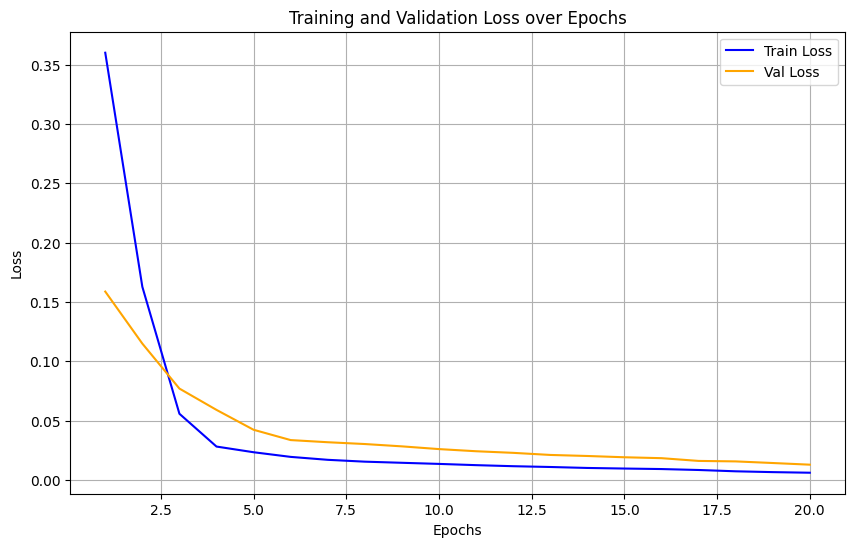

Modèle sauvegardé : bottle_colorization_model.pth
=== Évaluation pour le prétexte colorization - Catégorie bottle ===


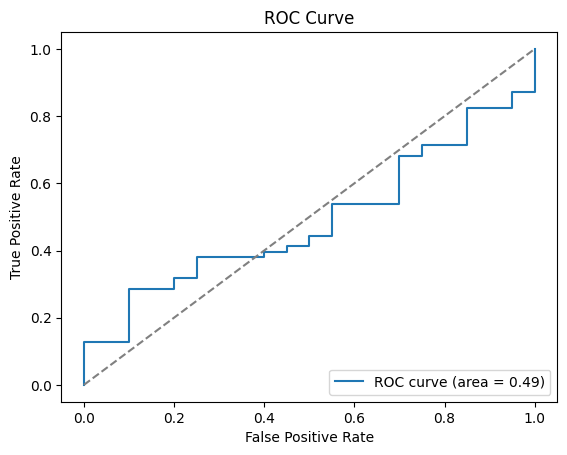

Entraînement pour le prétexte : inpainting
--- Début de l'entraînement pour inpainting ---


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `multiscale_structural_similarity_index_measure` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `multiscale_structural_similarity_index_measure` from `torchmetrics.image` instead.
  _future_warning(


Epoch 1/20, Train Loss: 0.4333, Val Loss: 0.4169
Epoch 2/20, Train Loss: 0.2272, Val Loss: 0.3522
Epoch 3/20, Train Loss: 0.1445, Val Loss: 0.1344
Epoch 4/20, Train Loss: 0.0685, Val Loss: 0.1254
Epoch 5/20, Train Loss: 0.0481, Val Loss: 0.0950
Epoch 6/20, Train Loss: 0.0441, Val Loss: 0.0719
Epoch 7/20, Train Loss: 0.0384, Val Loss: 0.0747
Epoch 8/20, Train Loss: 0.0379, Val Loss: 0.0750
Epoch 9/20, Train Loss: 0.0371, Val Loss: 0.0665
Epoch 10/20, Train Loss: 0.0348, Val Loss: 0.0637
Epoch 11/20, Train Loss: 0.0318, Val Loss: 0.0613
Epoch 12/20, Train Loss: 0.0291, Val Loss: 0.0580
Epoch 13/20, Train Loss: 0.0278, Val Loss: 0.0498
Epoch 14/20, Train Loss: 0.0240, Val Loss: 0.0479
Epoch 15/20, Train Loss: 0.0229, Val Loss: 0.0438
Epoch 16/20, Train Loss: 0.0229, Val Loss: 0.0418
Epoch 17/20, Train Loss: 0.0201, Val Loss: 0.0364
Epoch 18/20, Train Loss: 0.0189, Val Loss: 0.0493
Epoch 19/20, Train Loss: 0.0202, Val Loss: 0.0339
Epoch 20/20, Train Loss: 0.0183, Val Loss: 0.0350


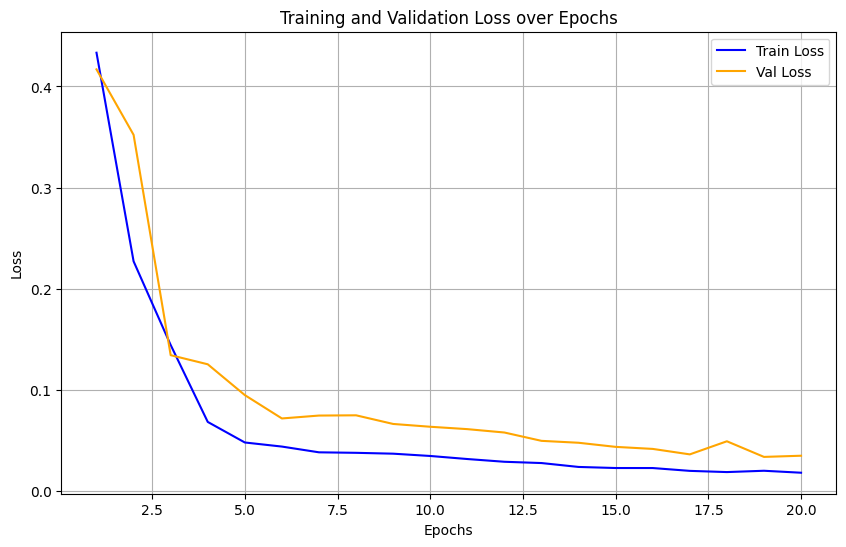

Modèle sauvegardé : bottle_inpainting_model.pth
=== Évaluation pour le prétexte inpainting - Catégorie bottle ===


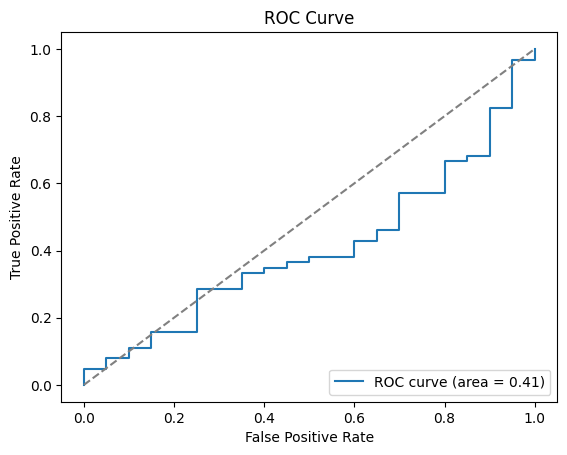

Entraînement pour le prétexte : maskedautoencoder
--- Début de l'entraînement pour maskedautoencoder ---


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `multiscale_structural_similarity_index_measure` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `multiscale_structural_similarity_index_measure` from `torchmetrics.image` instead.
  _future_warning(


Epoch 1/20, Train Loss: 0.3835, Val Loss: 0.4862
Epoch 2/20, Train Loss: 0.1487, Val Loss: 0.1356
Epoch 3/20, Train Loss: 0.0555, Val Loss: 0.0927
Epoch 4/20, Train Loss: 0.0418, Val Loss: 0.0633
Epoch 5/20, Train Loss: 0.0307, Val Loss: 0.0528
Epoch 6/20, Train Loss: 0.0245, Val Loss: 0.0421
Epoch 7/20, Train Loss: 0.0191, Val Loss: 0.0348
Epoch 8/20, Train Loss: 0.0169, Val Loss: 0.0321
Epoch 9/20, Train Loss: 0.0154, Val Loss: 0.0297
Epoch 10/20, Train Loss: 0.0147, Val Loss: 0.0277
Epoch 11/20, Train Loss: 0.0136, Val Loss: 0.0268
Epoch 12/20, Train Loss: 0.0125, Val Loss: 0.0269
Epoch 13/20, Train Loss: 0.0123, Val Loss: 0.0237
Epoch 14/20, Train Loss: 0.0112, Val Loss: 0.0236
Epoch 15/20, Train Loss: 0.0107, Val Loss: 0.0217
Epoch 16/20, Train Loss: 0.0100, Val Loss: 0.0227
Epoch 17/20, Train Loss: 0.0106, Val Loss: 0.0216
Epoch 18/20, Train Loss: 0.0105, Val Loss: 0.0213
Epoch 19/20, Train Loss: 0.0094, Val Loss: 0.0182
Epoch 20/20, Train Loss: 0.0090, Val Loss: 0.0192


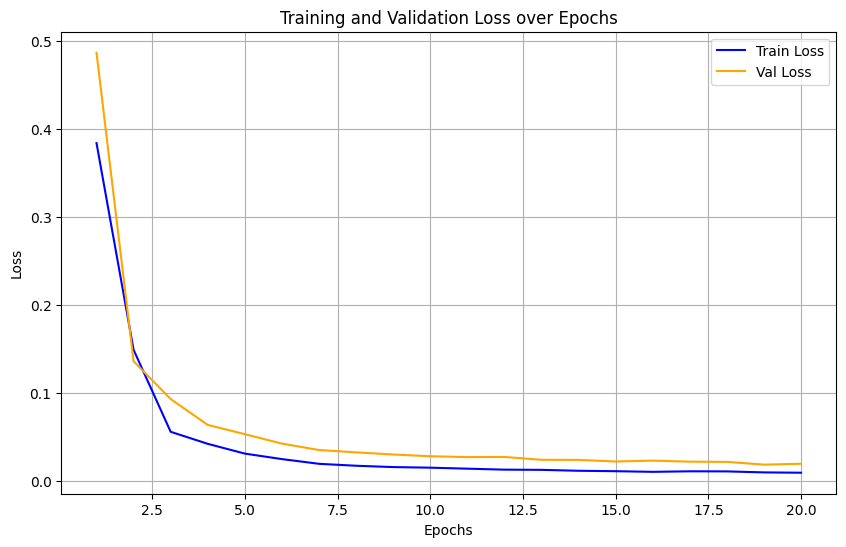

Modèle sauvegardé : bottle_maskedautoencoder_model.pth
=== Évaluation pour le prétexte maskedautoencoder - Catégorie bottle ===


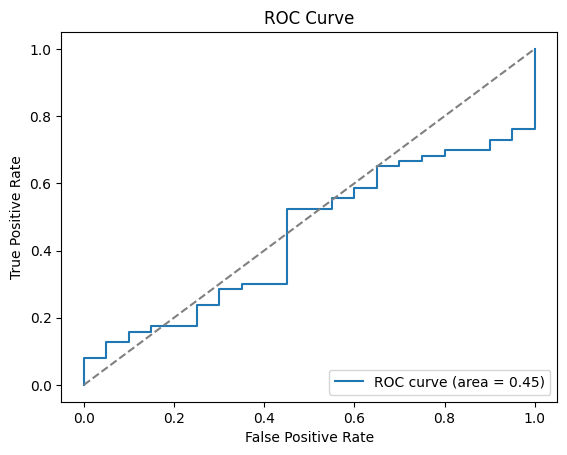

=== Entraînement pour la catégorie capsule ===
Entraînement pour le prétexte : colorization
--- Début de l'entraînement pour colorization ---


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `multiscale_structural_similarity_index_measure` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `multiscale_structural_similarity_index_measure` from `torchmetrics.image` instead.
  _future_warning(


Epoch 1/20, Train Loss: 0.4295, Val Loss: 0.8427
Epoch 2/20, Train Loss: 0.4167, Val Loss: 0.7166
Epoch 3/20, Train Loss: 0.3161, Val Loss: 0.4686
Epoch 4/20, Train Loss: 0.2024, Val Loss: 0.2767
Epoch 5/20, Train Loss: 0.0819, Val Loss: 0.1247
Epoch 6/20, Train Loss: 0.0433, Val Loss: 0.0744
Epoch 7/20, Train Loss: 0.0332, Val Loss: 0.0608
Epoch 8/20, Train Loss: 0.0266, Val Loss: 0.0476
Epoch 9/20, Train Loss: 0.0232, Val Loss: 0.0436
Epoch 10/20, Train Loss: 0.0215, Val Loss: 0.0403
Epoch 11/20, Train Loss: 0.0202, Val Loss: 0.0383
Epoch 12/20, Train Loss: 0.0192, Val Loss: 0.0367
Epoch 13/20, Train Loss: 0.0184, Val Loss: 0.0352
Epoch 14/20, Train Loss: 0.0177, Val Loss: 0.0340
Epoch 15/20, Train Loss: 0.0172, Val Loss: 0.0358
Epoch 16/20, Train Loss: 0.0178, Val Loss: 0.0323
Epoch 17/20, Train Loss: 0.0169, Val Loss: 0.0316
Epoch 18/20, Train Loss: 0.0162, Val Loss: 0.0313
Epoch 19/20, Train Loss: 0.0155, Val Loss: 0.0299
Epoch 20/20, Train Loss: 0.0149, Val Loss: 0.0286


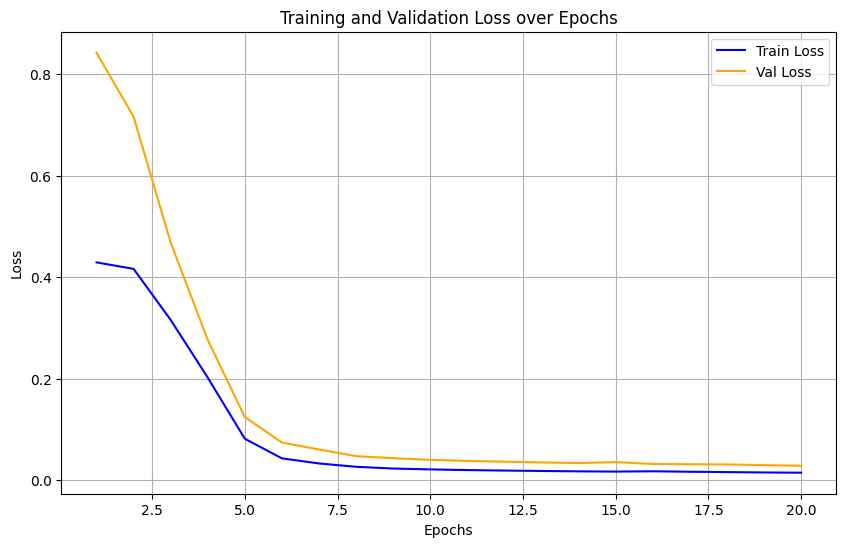

Modèle sauvegardé : capsule_colorization_model.pth
=== Évaluation pour le prétexte colorization - Catégorie capsule ===


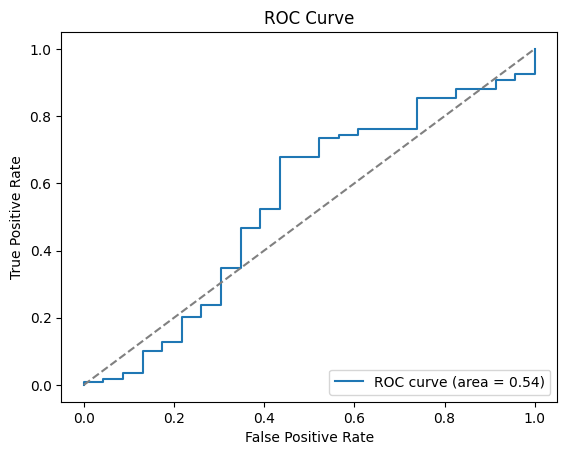

Entraînement pour le prétexte : inpainting
--- Début de l'entraînement pour inpainting ---


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `multiscale_structural_similarity_index_measure` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `multiscale_structural_similarity_index_measure` from `torchmetrics.image` instead.
  _future_warning(


Epoch 1/20, Train Loss: 0.4056, Val Loss: 0.7347
Epoch 2/20, Train Loss: 0.3464, Val Loss: 0.5859
Epoch 3/20, Train Loss: 0.2132, Val Loss: 0.2640
Epoch 4/20, Train Loss: 0.0826, Val Loss: 0.1293
Epoch 5/20, Train Loss: 0.0499, Val Loss: 0.0916
Epoch 6/20, Train Loss: 0.0405, Val Loss: 0.0732
Epoch 7/20, Train Loss: 0.0358, Val Loss: 0.0679
Epoch 8/20, Train Loss: 0.0340, Val Loss: 0.0668
Epoch 9/20, Train Loss: 0.0322, Val Loss: 0.0634
Epoch 10/20, Train Loss: 0.0312, Val Loss: 0.0588
Epoch 11/20, Train Loss: 0.0303, Val Loss: 0.0576
Epoch 12/20, Train Loss: 0.0290, Val Loss: 0.0559
Epoch 13/20, Train Loss: 0.0276, Val Loss: 0.0550
Epoch 14/20, Train Loss: 0.0265, Val Loss: 0.0499
Epoch 15/20, Train Loss: 0.0240, Val Loss: 0.0456
Epoch 16/20, Train Loss: 0.0216, Val Loss: 0.0415
Epoch 17/20, Train Loss: 0.0203, Val Loss: 0.0371
Epoch 18/20, Train Loss: 0.0189, Val Loss: 0.0351
Epoch 19/20, Train Loss: 0.0172, Val Loss: 0.0312
Epoch 20/20, Train Loss: 0.0156, Val Loss: 0.0306


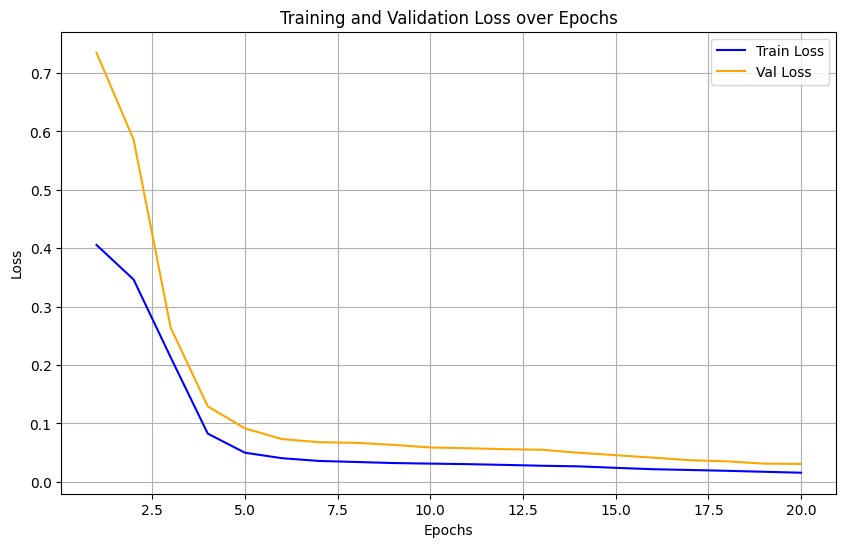

Modèle sauvegardé : capsule_inpainting_model.pth
=== Évaluation pour le prétexte inpainting - Catégorie capsule ===


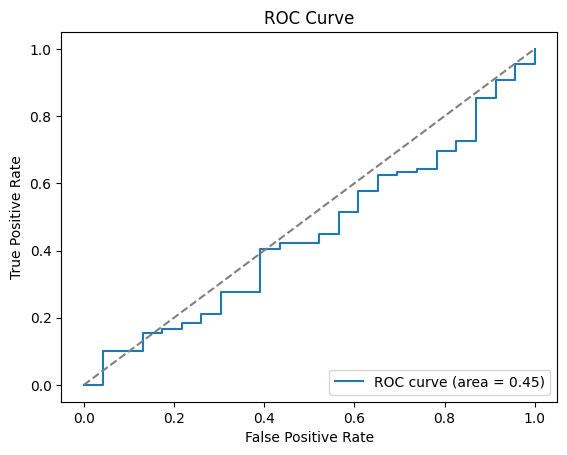

Entraînement pour le prétexte : maskedautoencoder
--- Début de l'entraînement pour maskedautoencoder ---


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `multiscale_structural_similarity_index_measure` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `multiscale_structural_similarity_index_measure` from `torchmetrics.image` instead.
  _future_warning(


Epoch 1/20, Train Loss: 0.4224, Val Loss: 0.8030
Epoch 2/20, Train Loss: 0.3559, Val Loss: 0.5821
Epoch 3/20, Train Loss: 0.1986, Val Loss: 0.1737
Epoch 4/20, Train Loss: 0.0637, Val Loss: 0.1087
Epoch 5/20, Train Loss: 0.0427, Val Loss: 0.0708
Epoch 6/20, Train Loss: 0.0324, Val Loss: 0.0610
Epoch 7/20, Train Loss: 0.0281, Val Loss: 0.0509
Epoch 8/20, Train Loss: 0.0250, Val Loss: 0.0471
Epoch 9/20, Train Loss: 0.0231, Val Loss: 0.0436
Epoch 10/20, Train Loss: 0.0215, Val Loss: 0.0410
Epoch 11/20, Train Loss: 0.0200, Val Loss: 0.0377
Epoch 12/20, Train Loss: 0.0185, Val Loss: 0.0347
Epoch 13/20, Train Loss: 0.0168, Val Loss: 0.0311
Epoch 14/20, Train Loss: 0.0152, Val Loss: 0.0280
Epoch 15/20, Train Loss: 0.0139, Val Loss: 0.0263
Epoch 16/20, Train Loss: 0.0129, Val Loss: 0.0250
Epoch 17/20, Train Loss: 0.0124, Val Loss: 0.0266
Epoch 18/20, Train Loss: 0.0124, Val Loss: 0.0237
Epoch 19/20, Train Loss: 0.0115, Val Loss: 0.0213
Epoch 20/20, Train Loss: 0.0108, Val Loss: 0.0208


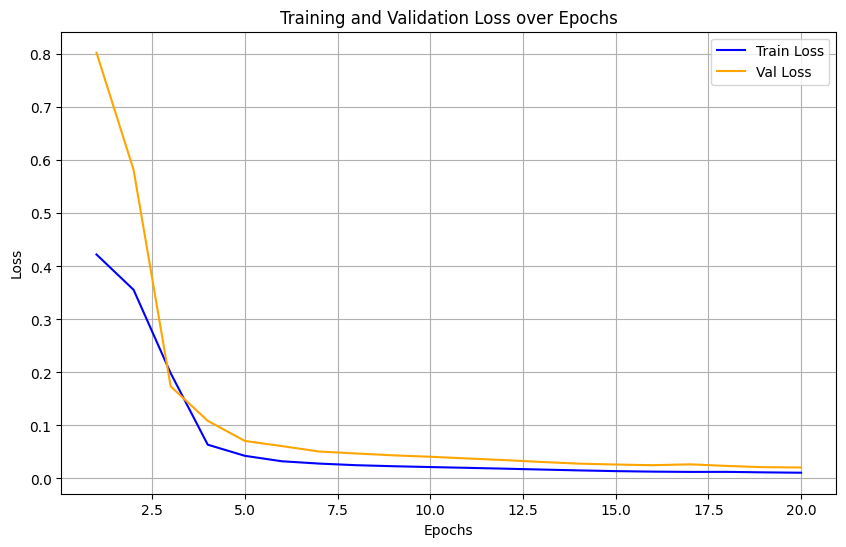

Modèle sauvegardé : capsule_maskedautoencoder_model.pth
=== Évaluation pour le prétexte maskedautoencoder - Catégorie capsule ===


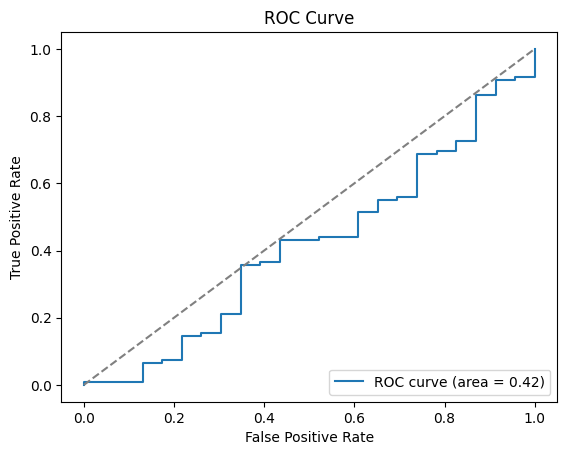

=== Entraînement pour la catégorie hazelnut ===
Entraînement pour le prétexte : colorization
--- Début de l'entraînement pour colorization ---


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `multiscale_structural_similarity_index_measure` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `multiscale_structural_similarity_index_measure` from `torchmetrics.image` instead.
  _future_warning(


Epoch 1/20, Train Loss: 0.1747, Val Loss: 0.1803
Epoch 2/20, Train Loss: 0.0468, Val Loss: 0.0502
Epoch 3/20, Train Loss: 0.0188, Val Loss: 0.0355
Epoch 4/20, Train Loss: 0.0136, Val Loss: 0.0267
Epoch 5/20, Train Loss: 0.0113, Val Loss: 0.0234
Epoch 6/20, Train Loss: 0.0097, Val Loss: 0.0215
Epoch 7/20, Train Loss: 0.0088, Val Loss: 0.0226
Epoch 8/20, Train Loss: 0.0084, Val Loss: 0.0180
Epoch 9/20, Train Loss: 0.0079, Val Loss: 0.0164
Epoch 10/20, Train Loss: 0.0075, Val Loss: 0.0160
Epoch 11/20, Train Loss: 0.0075, Val Loss: 0.0161
Epoch 12/20, Train Loss: 0.0073, Val Loss: 0.0149
Epoch 13/20, Train Loss: 0.0071, Val Loss: 0.0161
Epoch 14/20, Train Loss: 0.0066, Val Loss: 0.0168
Epoch 15/20, Train Loss: 0.0062, Val Loss: 0.0134
Epoch 16/20, Train Loss: 0.0067, Val Loss: 0.0157
Epoch 17/20, Train Loss: 0.0064, Val Loss: 0.0128
Epoch 18/20, Train Loss: 0.0060, Val Loss: 0.0125
Epoch 19/20, Train Loss: 0.0058, Val Loss: 0.0139
Epoch 20/20, Train Loss: 0.0057, Val Loss: 0.0124


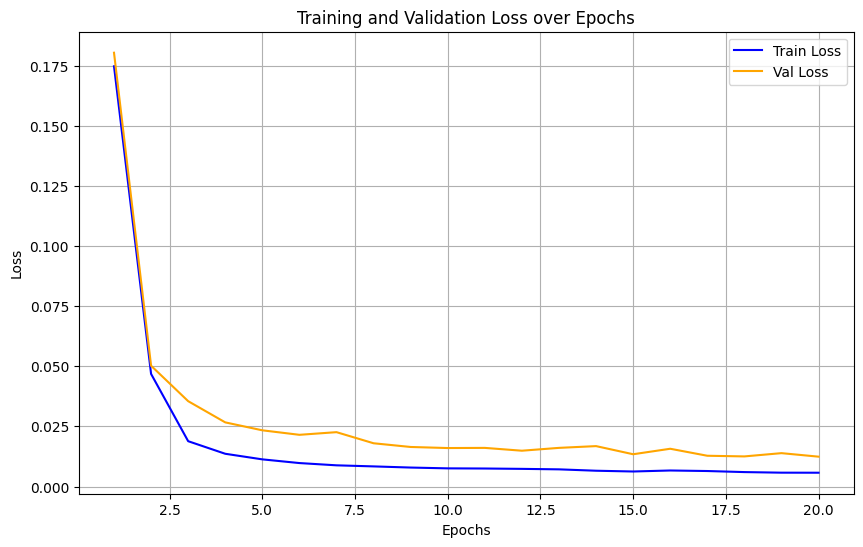

Modèle sauvegardé : hazelnut_colorization_model.pth
=== Évaluation pour le prétexte colorization - Catégorie hazelnut ===


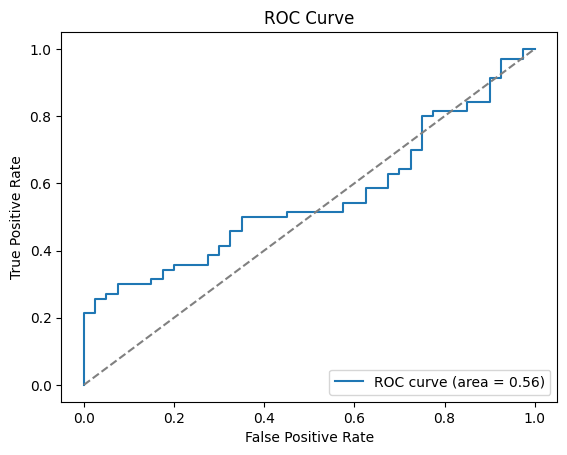

Entraînement pour le prétexte : inpainting
--- Début de l'entraînement pour inpainting ---


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `multiscale_structural_similarity_index_measure` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `multiscale_structural_similarity_index_measure` from `torchmetrics.image` instead.
  _future_warning(


Epoch 1/20, Train Loss: 0.1621, Val Loss: 0.1465
Epoch 2/20, Train Loss: 0.0552, Val Loss: 0.0738
Epoch 3/20, Train Loss: 0.0280, Val Loss: 0.0496
Epoch 4/20, Train Loss: 0.0213, Val Loss: 0.0427
Epoch 5/20, Train Loss: 0.0185, Val Loss: 0.0390
Epoch 6/20, Train Loss: 0.0172, Val Loss: 0.0359
Epoch 7/20, Train Loss: 0.0165, Val Loss: 0.0348
Epoch 8/20, Train Loss: 0.0157, Val Loss: 0.0310
Epoch 9/20, Train Loss: 0.0146, Val Loss: 0.0293
Epoch 10/20, Train Loss: 0.0133, Val Loss: 0.0247
Epoch 11/20, Train Loss: 0.0118, Val Loss: 0.0270
Epoch 12/20, Train Loss: 0.0108, Val Loss: 0.0193
Epoch 13/20, Train Loss: 0.0093, Val Loss: 0.0186
Epoch 14/20, Train Loss: 0.0091, Val Loss: 0.0201
Epoch 15/20, Train Loss: 0.0080, Val Loss: 0.0158
Epoch 16/20, Train Loss: 0.0073, Val Loss: 0.0160
Epoch 17/20, Train Loss: 0.0068, Val Loss: 0.0175
Epoch 18/20, Train Loss: 0.0063, Val Loss: 0.0139
Epoch 19/20, Train Loss: 0.0062, Val Loss: 0.0137
Epoch 20/20, Train Loss: 0.0061, Val Loss: 0.0132


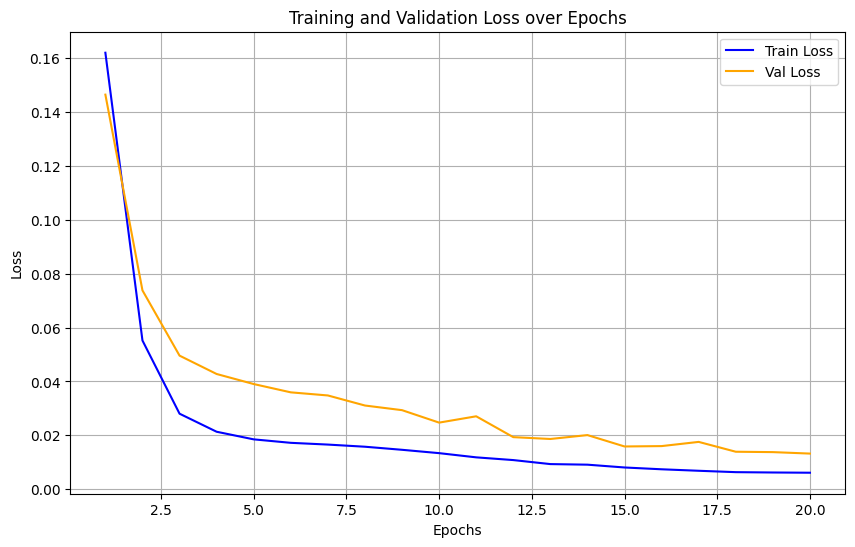

Modèle sauvegardé : hazelnut_inpainting_model.pth
=== Évaluation pour le prétexte inpainting - Catégorie hazelnut ===


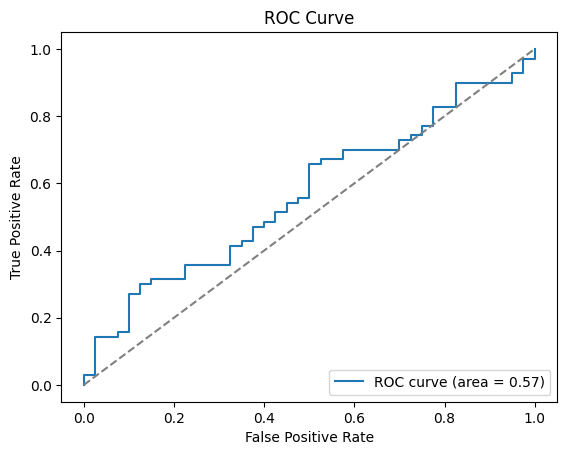

Entraînement pour le prétexte : maskedautoencoder
--- Début de l'entraînement pour maskedautoencoder ---


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `multiscale_structural_similarity_index_measure` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `multiscale_structural_similarity_index_measure` from `torchmetrics.image` instead.
  _future_warning(


Epoch 1/20, Train Loss: 0.1982, Val Loss: 0.1543
Epoch 2/20, Train Loss: 0.0609, Val Loss: 0.1027
Epoch 3/20, Train Loss: 0.0442, Val Loss: 0.0730
Epoch 4/20, Train Loss: 0.0214, Val Loss: 0.0329
Epoch 5/20, Train Loss: 0.0133, Val Loss: 0.0263
Epoch 6/20, Train Loss: 0.0110, Val Loss: 0.0227
Epoch 7/20, Train Loss: 0.0094, Val Loss: 0.0192
Epoch 8/20, Train Loss: 0.0081, Val Loss: 0.0162
Epoch 9/20, Train Loss: 0.0070, Val Loss: 0.0142
Epoch 10/20, Train Loss: 0.0068, Val Loss: 0.0150
Epoch 11/20, Train Loss: 0.0061, Val Loss: 0.0123
Epoch 12/20, Train Loss: 0.0050, Val Loss: 0.0107
Epoch 13/20, Train Loss: 0.0046, Val Loss: 0.0099
Epoch 14/20, Train Loss: 0.0046, Val Loss: 0.0097
Epoch 15/20, Train Loss: 0.0039, Val Loss: 0.0088
Epoch 16/20, Train Loss: 0.0040, Val Loss: 0.0090
Epoch 17/20, Train Loss: 0.0037, Val Loss: 0.0087
Epoch 18/20, Train Loss: 0.0035, Val Loss: 0.0086
Epoch 19/20, Train Loss: 0.0035, Val Loss: 0.0085
Epoch 20/20, Train Loss: 0.0033, Val Loss: 0.0077


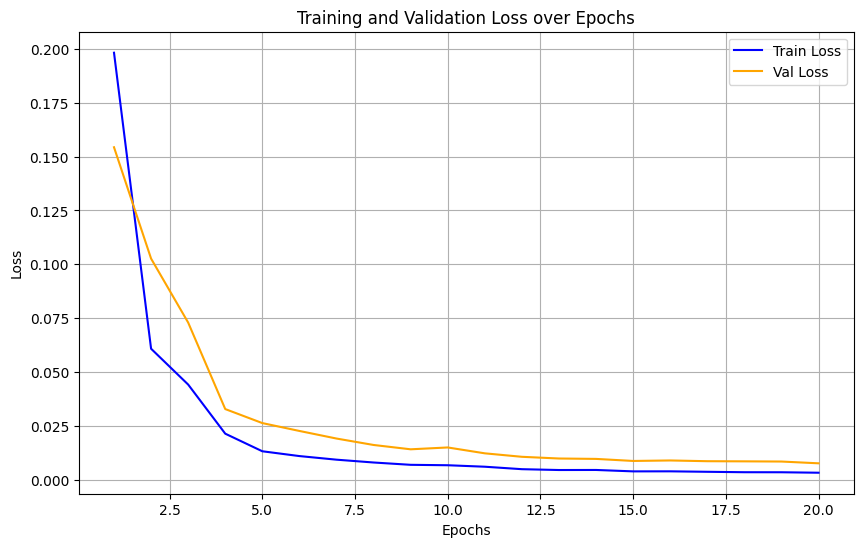

Modèle sauvegardé : hazelnut_maskedautoencoder_model.pth
=== Évaluation pour le prétexte maskedautoencoder - Catégorie hazelnut ===


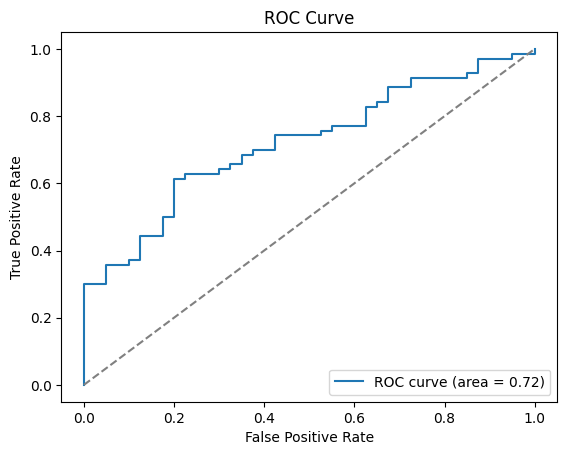

=== Entraînement pour la catégorie toothbrush ===
Entraînement pour le prétexte : colorization
--- Début de l'entraînement pour colorization ---


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `multiscale_structural_similarity_index_measure` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `multiscale_structural_similarity_index_measure` from `torchmetrics.image` instead.
  _future_warning(


Epoch 1/20, Train Loss: 0.4755, Val Loss: 0.9355
Epoch 2/20, Train Loss: 0.4618, Val Loss: 0.8921
Epoch 3/20, Train Loss: 0.4347, Val Loss: 0.8053
Epoch 4/20, Train Loss: 0.3981, Val Loss: 0.7627
Epoch 5/20, Train Loss: 0.3767, Val Loss: 0.7116
Epoch 6/20, Train Loss: 0.3489, Val Loss: 0.6365
Epoch 7/20, Train Loss: 0.3069, Val Loss: 0.5180
Epoch 8/20, Train Loss: 0.2415, Val Loss: 0.3481
Epoch 9/20, Train Loss: 0.1572, Val Loss: 0.2398
Epoch 10/20, Train Loss: 0.1393, Val Loss: 0.3121
Epoch 11/20, Train Loss: 0.1459, Val Loss: 0.2125
Epoch 12/20, Train Loss: 0.1058, Val Loss: 0.2040
Epoch 13/20, Train Loss: 0.1088, Val Loss: 0.2210
Epoch 14/20, Train Loss: 0.1130, Val Loss: 0.2047
Epoch 15/20, Train Loss: 0.1020, Val Loss: 0.1750
Epoch 16/20, Train Loss: 0.0888, Val Loss: 0.1656
Epoch 17/20, Train Loss: 0.0861, Val Loss: 0.1638
Epoch 18/20, Train Loss: 0.0816, Val Loss: 0.1401
Epoch 19/20, Train Loss: 0.0688, Val Loss: 0.1167
Epoch 20/20, Train Loss: 0.0571, Val Loss: 0.0960


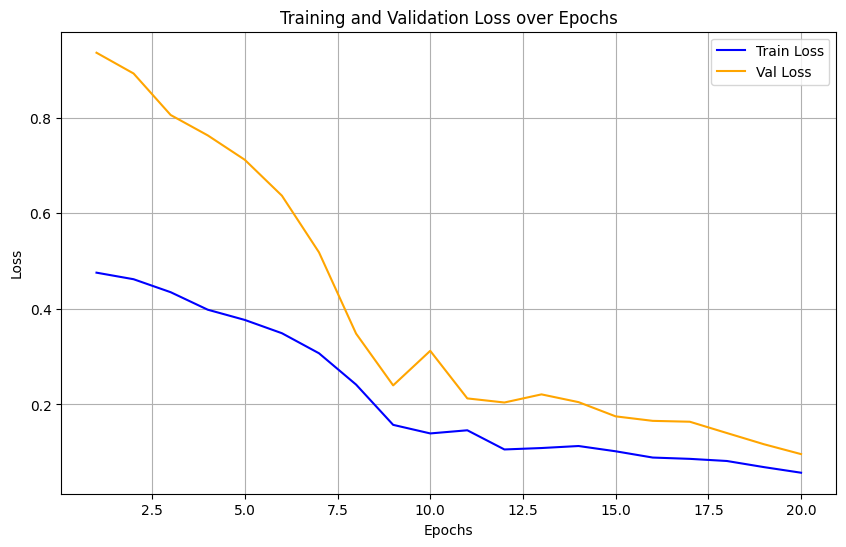

Modèle sauvegardé : toothbrush_colorization_model.pth
=== Évaluation pour le prétexte colorization - Catégorie toothbrush ===


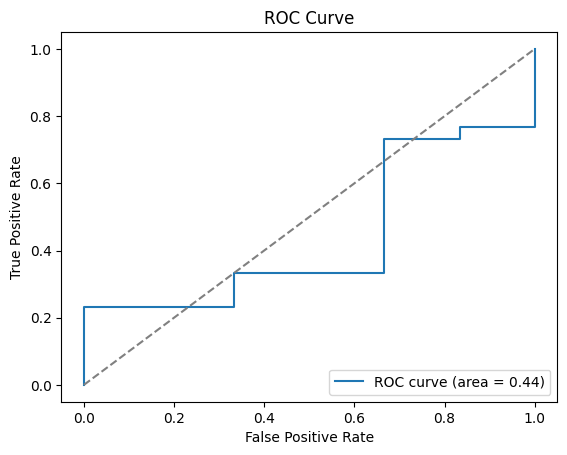

Entraînement pour le prétexte : inpainting
--- Début de l'entraînement pour inpainting ---


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `multiscale_structural_similarity_index_measure` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `multiscale_structural_similarity_index_measure` from `torchmetrics.image` instead.
  _future_warning(


Epoch 1/20, Train Loss: 0.4564, Val Loss: 0.8792
Epoch 2/20, Train Loss: 0.4388, Val Loss: 0.8367
Epoch 3/20, Train Loss: 0.4157, Val Loss: 0.8154
Epoch 4/20, Train Loss: 0.4071, Val Loss: 0.7999
Epoch 5/20, Train Loss: 0.3991, Val Loss: 0.7822
Epoch 6/20, Train Loss: 0.3899, Val Loss: 0.7580
Epoch 7/20, Train Loss: 0.3762, Val Loss: 0.7204
Epoch 8/20, Train Loss: 0.3554, Val Loss: 0.6628
Epoch 9/20, Train Loss: 0.3229, Val Loss: 0.5767
Epoch 10/20, Train Loss: 0.2801, Val Loss: 0.5025
Epoch 11/20, Train Loss: 0.2513, Val Loss: 0.4654
Epoch 12/20, Train Loss: 0.2247, Val Loss: 0.3747
Epoch 13/20, Train Loss: 0.1810, Val Loss: 0.3096
Epoch 14/20, Train Loss: 0.1502, Val Loss: 0.2439
Epoch 15/20, Train Loss: 0.1168, Val Loss: 0.1936
Epoch 16/20, Train Loss: 0.0961, Val Loss: 0.1709
Epoch 17/20, Train Loss: 0.0841, Val Loss: 0.1436
Epoch 18/20, Train Loss: 0.0681, Val Loss: 0.1244
Epoch 19/20, Train Loss: 0.0611, Val Loss: 0.1147
Epoch 20/20, Train Loss: 0.0570, Val Loss: 0.1229


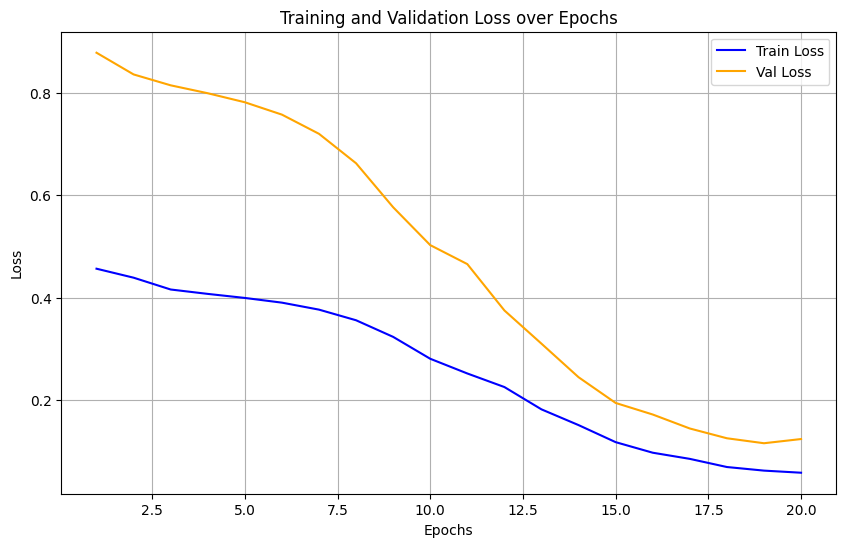

Modèle sauvegardé : toothbrush_inpainting_model.pth
=== Évaluation pour le prétexte inpainting - Catégorie toothbrush ===


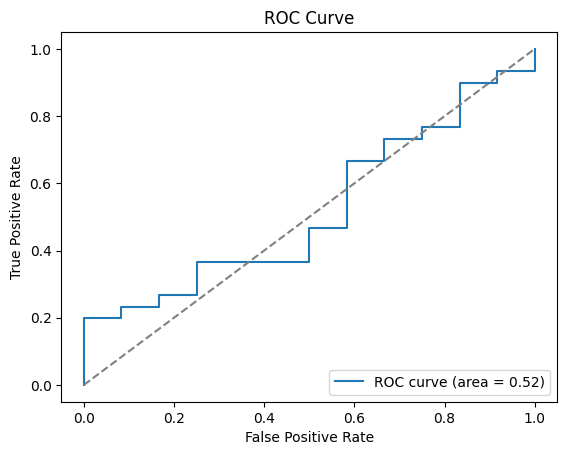

Entraînement pour le prétexte : maskedautoencoder
--- Début de l'entraînement pour maskedautoencoder ---


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `multiscale_structural_similarity_index_measure` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `multiscale_structural_similarity_index_measure` from `torchmetrics.image` instead.
  _future_warning(


Epoch 1/20, Train Loss: 0.3923, Val Loss: 0.7687
Epoch 2/20, Train Loss: 0.3841, Val Loss: 0.7533
Epoch 3/20, Train Loss: 0.3763, Val Loss: 0.7355
Epoch 4/20, Train Loss: 0.3665, Val Loss: 0.7112
Epoch 5/20, Train Loss: 0.3534, Val Loss: 0.6769
Epoch 6/20, Train Loss: 0.3342, Val Loss: 0.6185
Epoch 7/20, Train Loss: 0.3005, Val Loss: 0.5191
Epoch 8/20, Train Loss: 0.2449, Val Loss: 0.3708
Epoch 9/20, Train Loss: 0.1708, Val Loss: 0.2822
Epoch 10/20, Train Loss: 0.1517, Val Loss: 0.2804
Epoch 11/20, Train Loss: 0.1314, Val Loss: 0.2166
Epoch 12/20, Train Loss: 0.1155, Val Loss: 0.2339
Epoch 13/20, Train Loss: 0.1177, Val Loss: 0.2044
Epoch 14/20, Train Loss: 0.1042, Val Loss: 0.1983
Epoch 15/20, Train Loss: 0.1024, Val Loss: 0.1882
Epoch 16/20, Train Loss: 0.0938, Val Loss: 0.1653
Epoch 17/20, Train Loss: 0.0835, Val Loss: 0.1512
Epoch 18/20, Train Loss: 0.0754, Val Loss: 0.1287
Epoch 19/20, Train Loss: 0.0621, Val Loss: 0.1012
Epoch 20/20, Train Loss: 0.0481, Val Loss: 0.0774


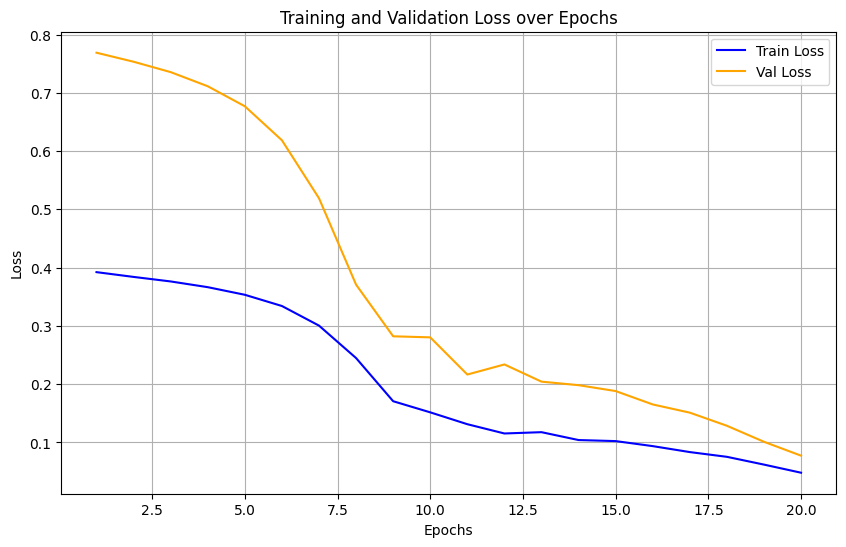

Modèle sauvegardé : toothbrush_maskedautoencoder_model.pth
=== Évaluation pour le prétexte maskedautoencoder - Catégorie toothbrush ===


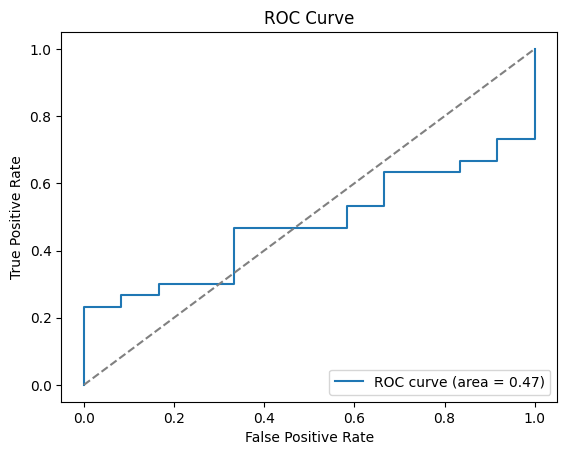

=== Entraînement pour la catégorie engine_wiring ===
Entraînement pour le prétexte : colorization
--- Début de l'entraînement pour colorization ---


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `multiscale_structural_similarity_index_measure` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `multiscale_structural_similarity_index_measure` from `torchmetrics.image` instead.
  _future_warning(


Epoch 1/20, Train Loss: 0.3630, Val Loss: 0.2637
Epoch 2/20, Train Loss: 0.0738, Val Loss: 0.1102
Epoch 3/20, Train Loss: 0.0524, Val Loss: 0.0986
Epoch 4/20, Train Loss: 0.0478, Val Loss: 0.0940
Epoch 5/20, Train Loss: 0.0451, Val Loss: 0.0891
Epoch 6/20, Train Loss: 0.0429, Val Loss: 0.0857
Epoch 7/20, Train Loss: 0.0412, Val Loss: 0.0813
Epoch 8/20, Train Loss: 0.0402, Val Loss: 0.0822
Epoch 9/20, Train Loss: 0.0399, Val Loss: 0.0777
Epoch 10/20, Train Loss: 0.0370, Val Loss: 0.0749
Epoch 11/20, Train Loss: 0.0345, Val Loss: 0.0722
Epoch 12/20, Train Loss: 0.0323, Val Loss: 0.0713
Epoch 13/20, Train Loss: 0.0319, Val Loss: 0.0628
Epoch 14/20, Train Loss: 0.0291, Val Loss: 0.0572
Epoch 15/20, Train Loss: 0.0278, Val Loss: 0.0662
Epoch 16/20, Train Loss: 0.0296, Val Loss: 0.0569
Epoch 17/20, Train Loss: 0.0263, Val Loss: 0.0654
Epoch 18/20, Train Loss: 0.0289, Val Loss: 0.0577
Epoch 19/20, Train Loss: 0.0257, Val Loss: 0.0515
Epoch 20/20, Train Loss: 0.0231, Val Loss: 0.0478


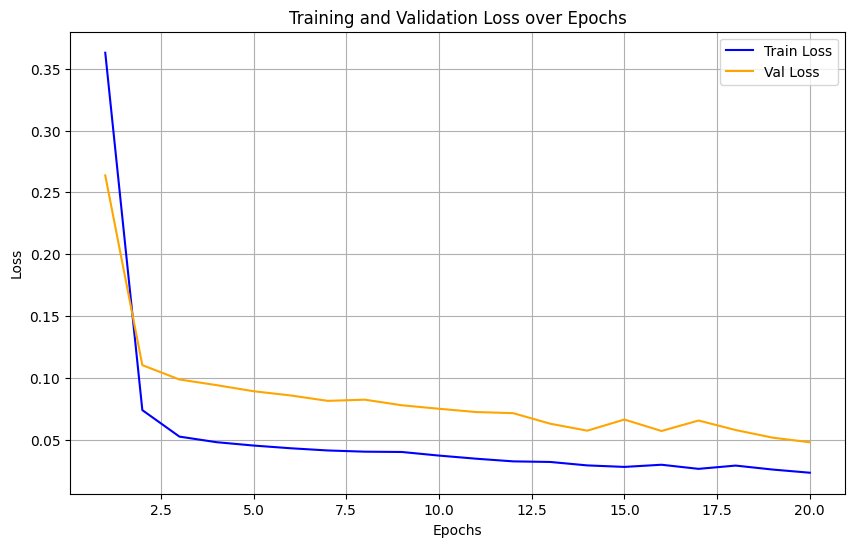

Modèle sauvegardé : engine_wiring_colorization_model.pth
=== Évaluation pour le prétexte colorization - Catégorie engine_wiring ===


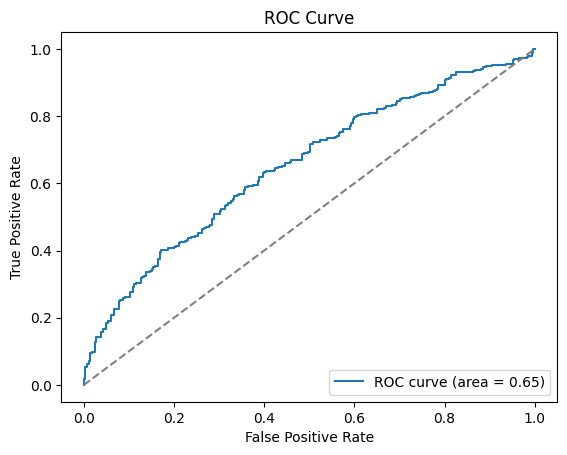

Entraînement pour le prétexte : inpainting
--- Début de l'entraînement pour inpainting ---


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `multiscale_structural_similarity_index_measure` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `multiscale_structural_similarity_index_measure` from `torchmetrics.image` instead.
  _future_warning(


Epoch 1/20, Train Loss: 0.3941, Val Loss: 0.5595
Epoch 2/20, Train Loss: 0.1945, Val Loss: 0.1732
Epoch 3/20, Train Loss: 0.0768, Val Loss: 0.1123
Epoch 4/20, Train Loss: 0.0539, Val Loss: 0.0956
Epoch 5/20, Train Loss: 0.0450, Val Loss: 0.0838
Epoch 6/20, Train Loss: 0.0407, Val Loss: 0.0768
Epoch 7/20, Train Loss: 0.0370, Val Loss: 0.0692
Epoch 8/20, Train Loss: 0.0332, Val Loss: 0.0653
Epoch 9/20, Train Loss: 0.0312, Val Loss: 0.0602
Epoch 10/20, Train Loss: 0.0278, Val Loss: 0.0488
Epoch 11/20, Train Loss: 0.0226, Val Loss: 0.0452
Epoch 12/20, Train Loss: 0.0213, Val Loss: 0.0413
Epoch 13/20, Train Loss: 0.0196, Val Loss: 0.0364
Epoch 14/20, Train Loss: 0.0163, Val Loss: 0.0309
Epoch 15/20, Train Loss: 0.0146, Val Loss: 0.0283
Epoch 16/20, Train Loss: 0.0138, Val Loss: 0.0274
Epoch 17/20, Train Loss: 0.0131, Val Loss: 0.0258
Epoch 18/20, Train Loss: 0.0129, Val Loss: 0.0274
Epoch 19/20, Train Loss: 0.0127, Val Loss: 0.0249
Epoch 20/20, Train Loss: 0.0116, Val Loss: 0.0230


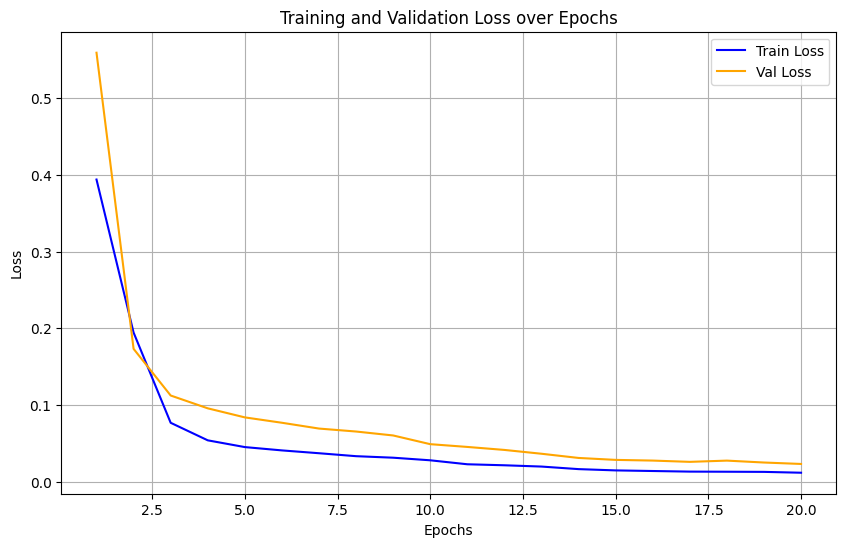

Modèle sauvegardé : engine_wiring_inpainting_model.pth
=== Évaluation pour le prétexte inpainting - Catégorie engine_wiring ===


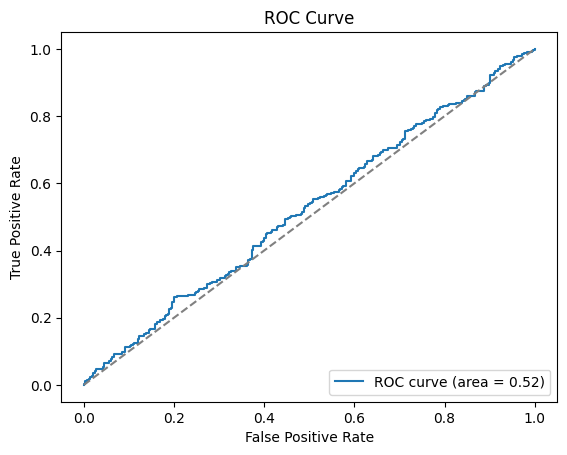

Entraînement pour le prétexte : maskedautoencoder
--- Début de l'entraînement pour maskedautoencoder ---


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `multiscale_structural_similarity_index_measure` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `multiscale_structural_similarity_index_measure` from `torchmetrics.image` instead.
  _future_warning(


Epoch 1/20, Train Loss: 0.3808, Val Loss: 0.5408
Epoch 2/20, Train Loss: 0.1843, Val Loss: 0.1334
Epoch 3/20, Train Loss: 0.0781, Val Loss: 0.1260
Epoch 4/20, Train Loss: 0.0628, Val Loss: 0.1145
Epoch 5/20, Train Loss: 0.0528, Val Loss: 0.0920
Epoch 6/20, Train Loss: 0.0375, Val Loss: 0.0580
Epoch 7/20, Train Loss: 0.0272, Val Loss: 0.0466
Epoch 8/20, Train Loss: 0.0215, Val Loss: 0.0380
Epoch 9/20, Train Loss: 0.0174, Val Loss: 0.0315
Epoch 10/20, Train Loss: 0.0144, Val Loss: 0.0263
Epoch 11/20, Train Loss: 0.0127, Val Loss: 0.0248
Epoch 12/20, Train Loss: 0.0116, Val Loss: 0.0213
Epoch 13/20, Train Loss: 0.0104, Val Loss: 0.0200
Epoch 14/20, Train Loss: 0.0096, Val Loss: 0.0190
Epoch 15/20, Train Loss: 0.0098, Val Loss: 0.0191
Epoch 16/20, Train Loss: 0.0089, Val Loss: 0.0165
Epoch 17/20, Train Loss: 0.0078, Val Loss: 0.0150
Epoch 18/20, Train Loss: 0.0073, Val Loss: 0.0147
Epoch 19/20, Train Loss: 0.0070, Val Loss: 0.0134
Epoch 20/20, Train Loss: 0.0069, Val Loss: 0.0126


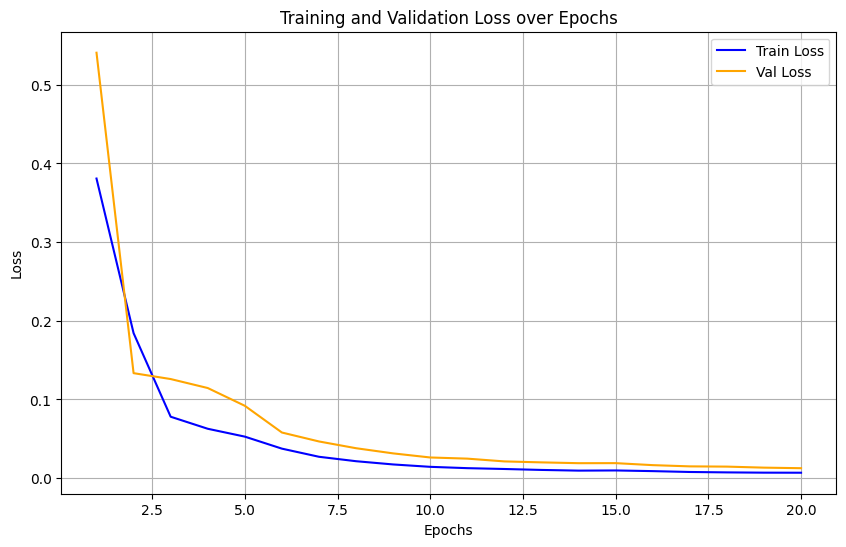

Modèle sauvegardé : engine_wiring_maskedautoencoder_model.pth
=== Évaluation pour le prétexte maskedautoencoder - Catégorie engine_wiring ===


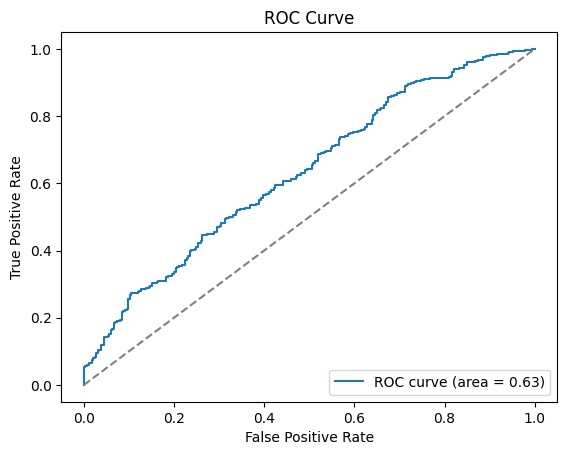

bottle - colorization: AUROC = 0.49
bottle - inpainting: AUROC = 0.41
bottle - maskedautoencoder: AUROC = 0.45
capsule - colorization: AUROC = 0.54
capsule - inpainting: AUROC = 0.45
capsule - maskedautoencoder: AUROC = 0.42
hazelnut - colorization: AUROC = 0.56
hazelnut - inpainting: AUROC = 0.57
hazelnut - maskedautoencoder: AUROC = 0.72
toothbrush - colorization: AUROC = 0.44
toothbrush - inpainting: AUROC = 0.52
toothbrush - maskedautoencoder: AUROC = 0.47
engine_wiring - colorization: AUROC = 0.65
engine_wiring - inpainting: AUROC = 0.52
engine_wiring - maskedautoencoder: AUROC = 0.63


In [ ]:
# Lancer le pipeline toute les prétextes et toutes les catégories de données
results = run_pipeline_multiple_pretexts(data_loaders_dict, param_dict=param_dict, pretexts=["colorization", "inpainting", "maskedautoencoder"],device=device)

# Afficher les résultats
for category, pretext_results in results.items():
    for pretext, result in pretext_results.items():
        print(f"{category} - {pretext}: AUROC = {result['roc_auc']:.2f}")

Cette fois-ci on peut constater une nette amélioration de l'apprentissage des modèles. En revanche pour la grande majorité des modèles, il y a une incapacité à detecter les anomalies. Au vu des courbes d'apprentissages, il est possible qu'avec bien plus d'epochs la capacité de detection d'anomalies des modèles s'améliore. On va donc tester de réentrainer un des modèles sur 50 epochs.

## Essai avec plus d'epochs sur un modèle

In [32]:
param_dict = {
    'engine_wiring': {
        'mask_size': 32,
        'num_mask' : 2,
        'mask_ratio': 1/16,
        'lr' : 5e-4,
        'num_epochs' : 50
    }
}

In [33]:
data_loaders_dict = {
    'engine_wiring': {
        'train_loader': train_engine_wiring_loader,
        'test_loader': test_engine_wiring_loader
    }
}

=== Entraînement pour la catégorie engine_wiring ===
Entraînement pour le prétexte : maskedautoencoder
--- Début de l'entraînement pour maskedautoencoder ---


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `multiscale_structural_similarity_index_measure` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `multiscale_structural_similarity_index_measure` from `torchmetrics.image` instead.
  _future_warning(


Epoch 1/50, Train Loss: 0.3634, Val Loss: 0.4857
Epoch 2/50, Train Loss: 0.1419, Val Loss: 0.1263
Epoch 3/50, Train Loss: 0.0598, Val Loss: 0.0931
Epoch 4/50, Train Loss: 0.0380, Val Loss: 0.0630
Epoch 5/50, Train Loss: 0.0283, Val Loss: 0.0480
Epoch 6/50, Train Loss: 0.0213, Val Loss: 0.0375
Epoch 7/50, Train Loss: 0.0172, Val Loss: 0.0314
Epoch 8/50, Train Loss: 0.0147, Val Loss: 0.0271
Epoch 9/50, Train Loss: 0.0129, Val Loss: 0.0247
Epoch 10/50, Train Loss: 0.0114, Val Loss: 0.0213
Epoch 11/50, Train Loss: 0.0107, Val Loss: 0.0200
Epoch 12/50, Train Loss: 0.0093, Val Loss: 0.0177
Epoch 13/50, Train Loss: 0.0084, Val Loss: 0.0161
Epoch 14/50, Train Loss: 0.0089, Val Loss: 0.0163
Epoch 15/50, Train Loss: 0.0079, Val Loss: 0.0147
Epoch 16/50, Train Loss: 0.0071, Val Loss: 0.0140
Epoch 17/50, Train Loss: 0.0069, Val Loss: 0.0128
Epoch 18/50, Train Loss: 0.0064, Val Loss: 0.0125
Epoch 19/50, Train Loss: 0.0059, Val Loss: 0.0114
Epoch 20/50, Train Loss: 0.0058, Val Loss: 0.0113
Epoch 21/

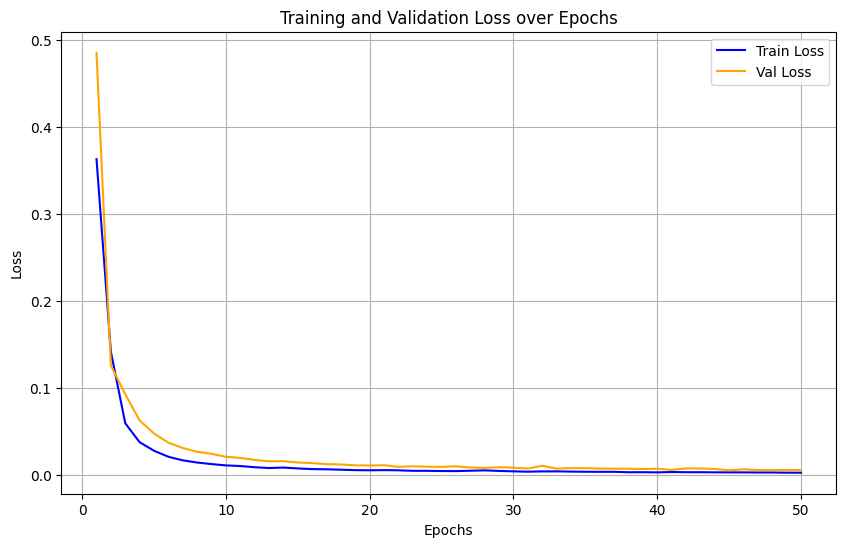

Modèle sauvegardé : engine_wiring_maskedautoencoder_model.pth
=== Évaluation pour le prétexte maskedautoencoder - Catégorie engine_wiring ===


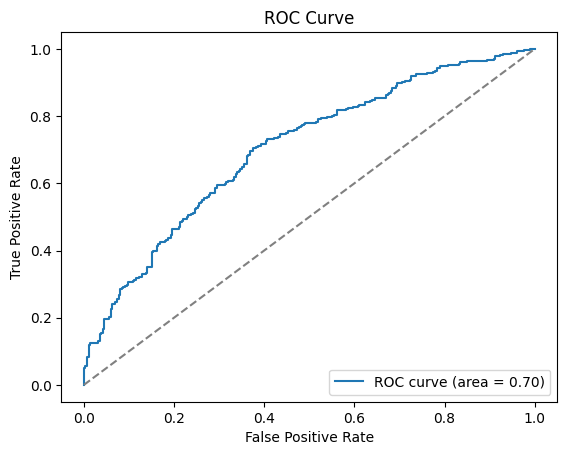

In [34]:
results = run_pipeline_multiple_pretexts(data_loaders_dict, param_dict=param_dict, pretexts=["maskedautoencoder"],device=device)

On peut constater une amélioration de AUROC (0.65 à 0.70) en passant de 20 à 50 epochs. Mais l'augmentation seule du nombre d'epochs n'est surement pas suffisante pour obtenir de bonnes performances de detection. Il faut donc réflechir en piste d'amélioration à une modification de l'architecture et/ou à une modification des pretexts.

On peut aussi notifier que malgré le fait que les modèles soient entrainés seulement sur les données sans anomalies, la perte MS-SSIM peut reconstruire les anomalies (surtout si elles ont de grandes structures) lors de l'évaluation. Ainsi combiner la MSE et la MS-SSIM peut être très intéressant, mais il ajuster le paramètre alpha qui contrôle la balance entre ces deux pertes en fonction des anomalies que l'on va rencontrer. Ainsi une optimisation du paramètres alpha pourrait améliorer aussi les performances de detection des modèles.

# Architecture Unet plus profonde avec un mécanisme d'attention intégré

Dans cette partie nous tentons d'implementer une version simplifiée des méthodes présentées dans les articles suivant :
- Li, Chun-Liang, et al. **"Cutpaste: Self-supervised learning for anomaly detection and localization."** Proceedings of the IEEE/CVF conference on computer vision and pattern recognition. 2021.
- Ristea, Nicolae-Cătălin, et al. **"Self-supervised predictive convolutional attentive block for anomaly detection."** Proceedings of the IEEE/CVF conference on computer vision and pattern recognition. 2022.

**Premier article :**
La méthode CutPaste : Une partie de l'image normale est découpée et collée à un emplacement aléatoire de l'image. Cela crée des irrégularités spatiales imitant des défauts réels. 
A noter que l'article met en place cette méthode dans l'entrainement d'un modèle qui comprend un classifier dont le but est de différentier les images normales et celles créées par CutPaste. Dans notre cas nous l'utilisons simplement comme modification initiale de l'image pour que le modèle apprenne à reconstruire l'image d'origine.

**Deuxième article :**
La méthode PCAB propose un bloc auto-supervisé appelé Predictive Convolutional Attention Block.
Le modèle est entraîné à prédire des pixels masqués dans des images en se basant sur leur contexte spatial. Cette méthode permet d'apprendre des représentations riches sans nécessiter d'étiquettes d'anomalie. Son architecture combine des blocs convolutionnels pour extraire des caractéristiques locales et intègre un mécanisme d'attention pour se concentrer sur des zones pertinentes de l'image.
A noter que sur le même principe que notre perte MS-SSIM, cette méthode pourrait être capable (si elle est mal incorporée dans le modèle) de reconstruire correctement certaines anomalies lors de l'évaluation provoquant ainsi une perte de capacité du modèle à detecter les anomalies.

## Architecture Unet avec attention

### Explication du Bloc d'attention

Le bloc d'attention combine **l'attention de canal** et **l'attention spatiale** pour mettre en valeur les informations les plus importantes dans les cartes de caractéristiques.

##### 1. Attention de canal
L'attention de canal ajuste l'importance de chaque canal dans les caractéristiques extraites.

- **Étapes :**
  1. **Pooling global adaptatif** : Résume chaque canal en une valeur moyenne ( H x W x 1 x 1 ).
  2. **Réduction dimensionnelle** : Convolution ( 1 x 1 ) pour réduire les canaux d'un facteur 1/8 avec une activation Relu.
  3. **Projection** : Convolution ( 1 x 1 ) pour revenir à la dimension d'origine puis activation sigmoide.
  4. **Pondération** : Chaque canal est multiplié par un poids (son activation sigmoïde) ce qui ajuste l'importance de chaque canal.

##### 2. Attention spatiale
L'attention spatiale met en évidence les zones importantes dans la dimension spatiale.

- **Étapes :**
  1. **Fusion des canaux** : Combine les informations de tous les canaux en créant une carte de caractéristiques spatiales avec deux "canaux" :
     - une carte contenant la **moyenne** spatiale des canaux.
     - une carte contenant le **maximum** spatial des canaux.
  2. **Convolution spatiale** : Convolution ( 7 x 7 ) pour capturer les relations locales. Suivie d'une activation sigmoide qui renvoie une carte d'attention spatiale où chaque pixel à un poid entre 0 et 1.
  3. **Pondération** : La carte de caractéristiques d'entrée est multipliée avec la carte d'attention spatiale, ajustant ainsi l'importance de chaque pixel.

##### 3. Fonctionnement global
- L'entrée traverse **l'attention de canal**, puis **l'attention spatiale**.
- Le bloc permet de mettre en avant les canaux et les zones les plus pertinentes.


In [18]:
# Bloc double convolution
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )

# Bloc d'attention (canal + spatial)
class AttentionBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()

        # Attention canal
        self.channel_att = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, in_channels // 8, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // 8, in_channels, kernel_size=1),
            nn.Sigmoid()
        )

        # Attention spatial
        self.spatial_att = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size=7, padding=3),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Attention canal
        channel_att = self.channel_att(x)
        x = x * channel_att

        # Attention spatial
        spatial_att = torch.cat([torch.mean(x, dim=1, keepdim=True), torch.max(x, dim=1, keepdim=True)[0]], dim=1)
        spatial_att = self.spatial_att(spatial_att)
        x = x * spatial_att

        return x

# Bloc DownSample
class DownSampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_block = double_conv(in_channels, out_channels)
        self.attention = AttentionBlock(out_channels)
        self.maxpool = nn.MaxPool2d(2)

    def forward(self, x):
        x_skip = self.conv_block(x)
        x_skip = self.attention(x_skip)
        x = self.maxpool(x_skip)
        return x, x_skip

# Bloc UpSample
class UpSampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_block = double_conv(in_channels, out_channels)
        self.attention = AttentionBlock(out_channels)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x, x_skip):
        x = self.upsample(x)
        x = torch.cat([x, x_skip], dim=1)
        x = self.conv_block(x)
        x = self.attention(x)
        return x

# UNet plus profond avec Attention
class UNet_with_attention(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()

        # DownSampling
        self.down1 = DownSampleBlock(in_channels, 64)
        self.down2 = DownSampleBlock(64, 128)
        self.down3 = DownSampleBlock(128, 256)
        self.down4 = DownSampleBlock(256, 512)
        self.middle_conv = double_conv(512, 1024)

        # UpSampling
        self.up4 = UpSampleBlock(1024 + 512, 512)
        self.up3 = UpSampleBlock(512 + 256, 256)
        self.up2 = UpSampleBlock(256 + 128, 128)
        self.up1 = UpSampleBlock(128 + 64, 64)

        # Dernière Convolution
        self.last_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # DownSampling
        x, x_skip1 = self.down1(x)
        x, x_skip2 = self.down2(x)
        x, x_skip3 = self.down3(x)
        x, x_skip4 = self.down4(x)

        # Couche centrale
        x = self.middle_conv(x)

        # UpSampling
        x = self.up4(x, x_skip4)
        x = self.up3(x, x_skip3)
        x = self.up2(x, x_skip2)
        x = self.up1(x, x_skip1)

        # Sortie
        out = self.last_conv(x)
        return out


## Pretext : CutPaste

In [19]:
# Cut-Paste Pretext 
class CutPasteReconstruction(nn.Module):
    def __init__(self, unet_model):
        super().__init__()
        self.unet = unet_model

    def cut_paste_transform(self, image, patch_size=32):
        # Sélection aléatoire d'une zone de l'image
        _, h, w = image.shape
        y1 = torch.randint(0, h - patch_size, (1,)).item()
        x1 = torch.randint(0, w - patch_size, (1,)).item()

        patch = image[:, y1:y1 + patch_size, x1:x1 + patch_size]

        # Sélection aléatoire d'un nouvel emplacement pour le patch
        y2 = torch.randint(0, h - patch_size, (1,)).item()
        x2 = torch.randint(0, w - patch_size, (1,)).item()

        # Créer l'image cutpaste
        cut_paste_image = image.clone()
        cut_paste_image[:, y2:y2 + patch_size, x2:x2 + patch_size] = patch

        return cut_paste_image

    def forward(self, x):
      # Appliquer la transformation Cut-Paste à chaque image du batch
      cut_paste_images = []
      for img in x:  # Traiter chaque image dans le batch
          cut_paste_image = self.cut_paste_transform(img)
          cut_paste_images.append(cut_paste_image)

      # Convertir la liste en un batch
      cut_paste_images = torch.stack(cut_paste_images)  # Shape: (N, C, H, W)

      # Reconstruire les images avec l'UNet
      reconstructed_images = self.unet(cut_paste_images)  # Shape: (N, C, H, W)

      return reconstructed_images

## Fonction d'entrainement

In [20]:
def train_ssl_model(model, train_loader, test_loader, optimizer, criterion=CombinedLoss(alpha=0.5, reduction='mean', reduction2='elementwise_mean'), device="cuda", epochs=20, accumulation_steps=2):
    """
    Entraîne un modèle SSL sur les données d'entraînement et trace les courbes de perte.

    Args:
        model (nn.Module): Modèle SSL à entraîner.
        train_loader (DataLoader): DataLoader pour les données d'entraînement.
        test_loader (DataLoader): DataLoader pour les données de validation.
        criterion (CombinedLoss): Fonction de perte combinée (MSE + MS-SSIM).
        optimizer (Optimizer): Optimiseur pour la mise à jour des poids.
        device (str): Périphérique (e.g., "cuda" ou "cpu").
        epochs (int): Nombre d'époques.
        accumulation_steps: The number of batches to accumulate gradients over.
    """
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.to(device)
        model.train()
        total_train_loss = 0

        i = 0
        for images, _ in train_loader:  # Ignore les labels
            images = images.to(device)
            optimizer.zero_grad()

            # Passage avant
            outputs = model(images)

            # Calcul de la perte
            loss = criterion(outputs, images)
            loss = loss / accumulation_steps
            loss.backward()

            # Mise à jour des poids un batch sur 2 à cause des capacités limitées en VRAM de la version gratuite des GPU de google colab
            if (i + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            total_train_loss += loss.item()
            i += 1

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Évaluation sur le jeu de validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for images, _ in test_loader:
                images = images.to(device)

                # Passage avant
                outputs = model(images)

                # Calcul de la perte
                val_loss = criterion(outputs, images)
                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(test_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Trace les pertes
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs+1), train_losses, label='Train Loss', color='blue')
    plt.plot(range(1, epochs+1), val_losses, label='Val Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

    return model

## Fonction d'évaluation

In [21]:
def evaluate_ssl_model(model, test_loader, criterion= CombinedLoss(alpha=0.5, reduction='none', reduction2='none'), device="cuda"):
    """
    Évalue un modèle SSL sur les données de test et retourne l'AUROC.

    Args:
        model (nn.Module): Modèle SSL entraîné.
        test_loader (DataLoader): DataLoader pour les données de test.
        criterion (CombinedLoss): Fonction de perte combinée utilisée pour calculer le score d'anomalie.
        device (str): Périphérique pour l'évaluation.

    Returns:
        float: AUROC pour le modèle sur les données de test.
    """
    model.to(device)
    model.eval()

    anomaly_scores = []
    true_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)

            # Prédictions et reconstruction
            outputs = model(images)

            # Calcul de la perte entre l'image reconstruite et l'image originale
            loss = criterion(outputs, images)

            anomaly_scores.extend(loss.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Calcul des métriques ROC
    fpr, tpr, _ = roc_curve(true_labels, anomaly_scores)
    roc_auc = auc(fpr, tpr)

    # Trace la courbe ROC
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc

## Pipeline d'entrainement et d'évaluation

In [22]:
def run_pipeline(data_loaders_dict, num_epochs=30, device=device):
    results = {}

    for category in data_loaders_dict.keys():
        print(f"=== Entraînement pour la catégorie : {category} ===")
        category_results = {}

        model = CutPasteReconstruction(unet_model=UNet_with_attention(in_channels=3, out_channels=3))
        criterion = CombinedLoss(alpha=0.5, reduction='mean', reduction2='elementwise_mean')

        optimizer = optim.Adam(model.parameters(), lr=1e-4)

        # Entraîner le modèle
        train_loader = data_loaders_dict[category]["train_loader"]
        test_loader = data_loaders_dict[category]["test_loader"]

        train_ssl_model(model, train_loader, test_loader, optimizer, criterion, device=device, epochs=num_epochs)

        # Sauvegarder le modèle
        model_path = f"{category}_model.pth"
        torch.save(model.state_dict(), model_path)
        print(f"Modèle sauvegardé : {model_path}")


        # Évaluer le modèle
        print(f"=== Évaluation pour la catégorie : {category} ===")
        criterion2 = CombinedLoss(alpha=0.5, reduction='none', reduction2='none')
        roc_auc = evaluate_ssl_model(model, test_loader, criterion2, device=device)

        # Stocker les résultats
        category_results = {"model": model, "roc_auc": roc_auc}

        results[category] = category_results

    return results

=== Entraînement pour la catégorie : bottle ===
Epoch 1/35, Train Loss: 0.4978, Val Loss: 0.9753
Epoch 2/35, Train Loss: 0.4825, Val Loss: 0.9502
Epoch 3/35, Train Loss: 0.4750, Val Loss: 0.9397
Epoch 4/35, Train Loss: 0.4674, Val Loss: 0.8983
Epoch 5/35, Train Loss: 0.4401, Val Loss: 0.8661
Epoch 6/35, Train Loss: 0.4269, Val Loss: 0.8108
Epoch 7/35, Train Loss: 0.3505, Val Loss: 0.5724
Epoch 8/35, Train Loss: 0.2679, Val Loss: 0.4810
Epoch 9/35, Train Loss: 0.2193, Val Loss: 0.3727
Epoch 10/35, Train Loss: 0.1412, Val Loss: 0.2028
Epoch 11/35, Train Loss: 0.0960, Val Loss: 0.1646
Epoch 12/35, Train Loss: 0.0674, Val Loss: 0.1113
Epoch 13/35, Train Loss: 0.0506, Val Loss: 0.0870
Epoch 14/35, Train Loss: 0.0435, Val Loss: 0.0789
Epoch 15/35, Train Loss: 0.0393, Val Loss: 0.0773
Epoch 16/35, Train Loss: 0.0385, Val Loss: 0.0770
Epoch 17/35, Train Loss: 0.0370, Val Loss: 0.0665
Epoch 18/35, Train Loss: 0.0347, Val Loss: 0.0672
Epoch 19/35, Train Loss: 0.0336, Val Loss: 0.0632
Epoch 20/35

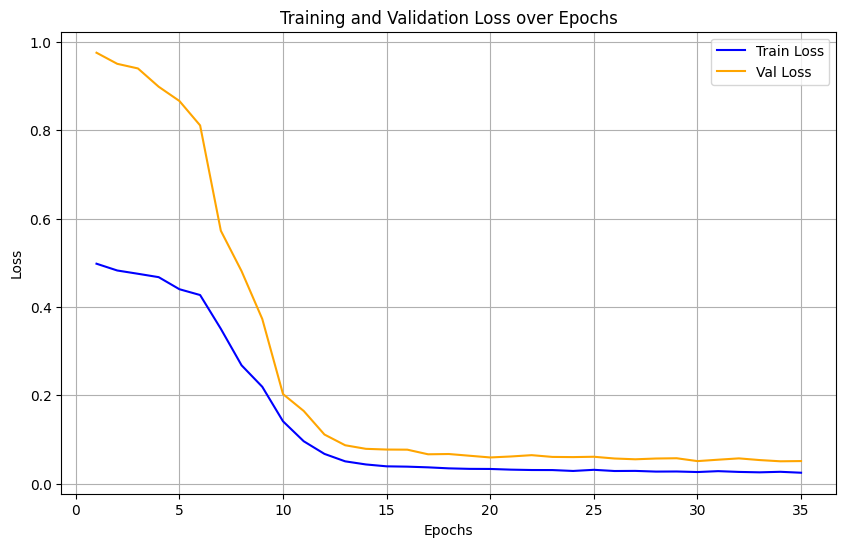

Modèle sauvegardé : bottle_model.pth
=== Évaluation pour la catégorie : bottle ===


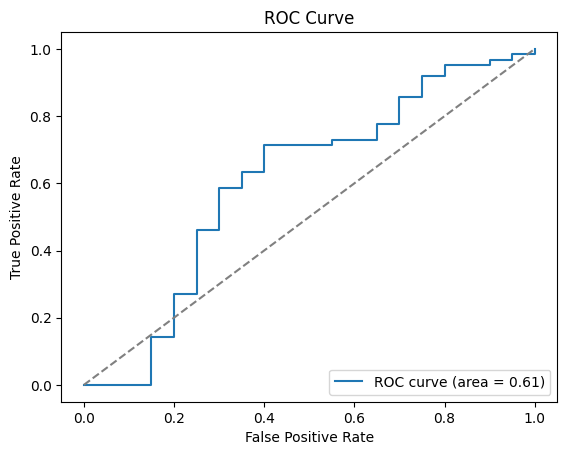

=== Entraînement pour la catégorie : capsule ===


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `multiscale_structural_similarity_index_measure` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `multiscale_structural_similarity_index_measure` from `torchmetrics.image` instead.
  _future_warning(


Epoch 1/35, Train Loss: 0.3942, Val Loss: 0.7787
Epoch 2/35, Train Loss: 0.3908, Val Loss: 0.7695
Epoch 3/35, Train Loss: 0.3848, Val Loss: 0.7523
Epoch 4/35, Train Loss: 0.3717, Val Loss: 0.7065
Epoch 5/35, Train Loss: 0.3242, Val Loss: 0.5067
Epoch 6/35, Train Loss: 0.2248, Val Loss: 0.4039
Epoch 7/35, Train Loss: 0.1944, Val Loss: 0.3617
Epoch 8/35, Train Loss: 0.1702, Val Loss: 0.2978
Epoch 9/35, Train Loss: 0.1206, Val Loss: 0.1447
Epoch 10/35, Train Loss: 0.0561, Val Loss: 0.0944
Epoch 11/35, Train Loss: 0.0463, Val Loss: 0.0838
Epoch 12/35, Train Loss: 0.0396, Val Loss: 0.0709
Epoch 13/35, Train Loss: 0.0359, Val Loss: 0.0697
Epoch 14/35, Train Loss: 0.0341, Val Loss: 0.0661
Epoch 15/35, Train Loss: 0.0331, Val Loss: 0.0681
Epoch 16/35, Train Loss: 0.0322, Val Loss: 0.0653
Epoch 17/35, Train Loss: 0.0334, Val Loss: 0.0649
Epoch 18/35, Train Loss: 0.0315, Val Loss: 0.0594
Epoch 19/35, Train Loss: 0.0307, Val Loss: 0.0600
Epoch 20/35, Train Loss: 0.0306, Val Loss: 0.0605
Epoch 21/

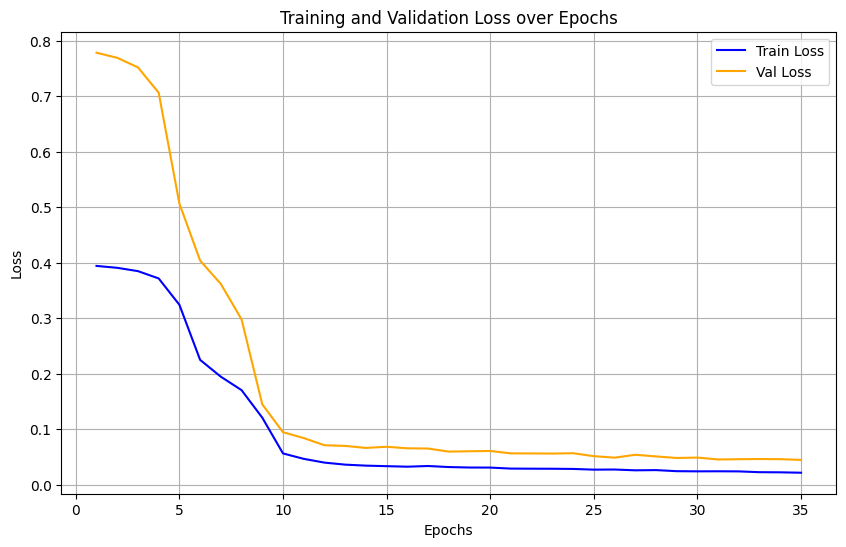

Modèle sauvegardé : capsule_model.pth
=== Évaluation pour la catégorie : capsule ===


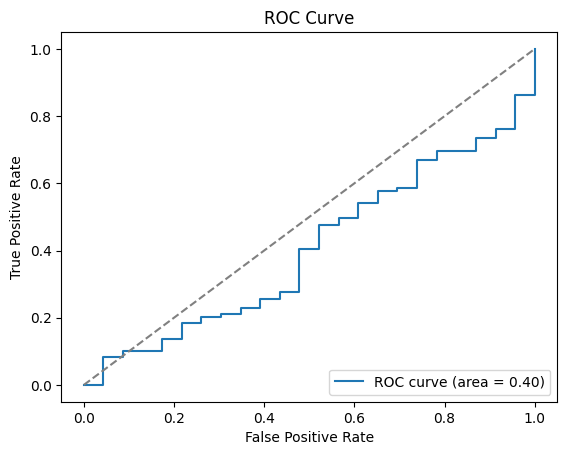

=== Entraînement pour la catégorie : hazelnut ===


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `multiscale_structural_similarity_index_measure` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `multiscale_structural_similarity_index_measure` from `torchmetrics.image` instead.
  _future_warning(


Epoch 1/35, Train Loss: 0.3065, Val Loss: 0.5786
Epoch 2/35, Train Loss: 0.2967, Val Loss: 0.5453
Epoch 3/35, Train Loss: 0.2162, Val Loss: 0.2755
Epoch 4/35, Train Loss: 0.1036, Val Loss: 0.1661
Epoch 5/35, Train Loss: 0.0707, Val Loss: 0.1277
Epoch 6/35, Train Loss: 0.0600, Val Loss: 0.1105
Epoch 7/35, Train Loss: 0.0524, Val Loss: 0.0982
Epoch 8/35, Train Loss: 0.0445, Val Loss: 0.0787
Epoch 9/35, Train Loss: 0.0332, Val Loss: 0.0572
Epoch 10/35, Train Loss: 0.0267, Val Loss: 0.0534
Epoch 11/35, Train Loss: 0.0247, Val Loss: 0.0489
Epoch 12/35, Train Loss: 0.0229, Val Loss: 0.0465
Epoch 13/35, Train Loss: 0.0216, Val Loss: 0.0443
Epoch 14/35, Train Loss: 0.0208, Val Loss: 0.0418
Epoch 15/35, Train Loss: 0.0194, Val Loss: 0.0426
Epoch 16/35, Train Loss: 0.0190, Val Loss: 0.0361
Epoch 17/35, Train Loss: 0.0174, Val Loss: 0.0368
Epoch 18/35, Train Loss: 0.0168, Val Loss: 0.0339
Epoch 19/35, Train Loss: 0.0158, Val Loss: 0.0318
Epoch 20/35, Train Loss: 0.0153, Val Loss: 0.0311
Epoch 21/

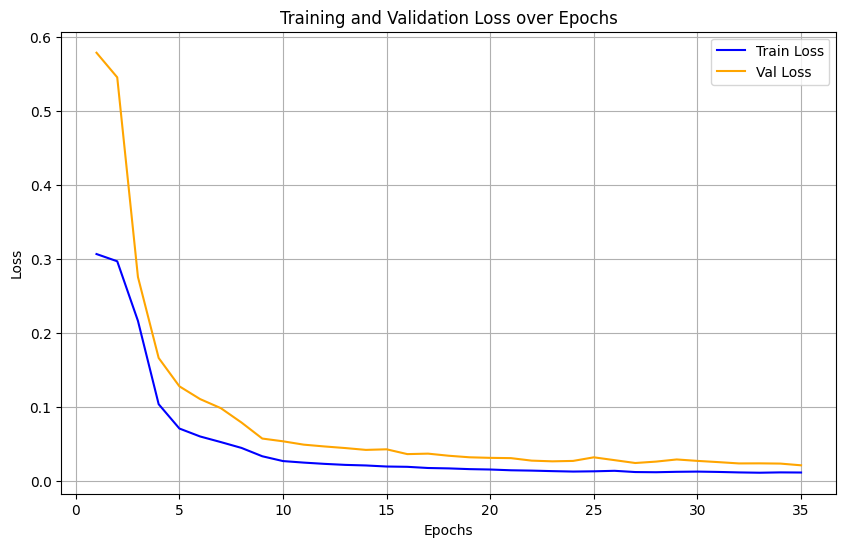

Modèle sauvegardé : hazelnut_model.pth
=== Évaluation pour la catégorie : hazelnut ===


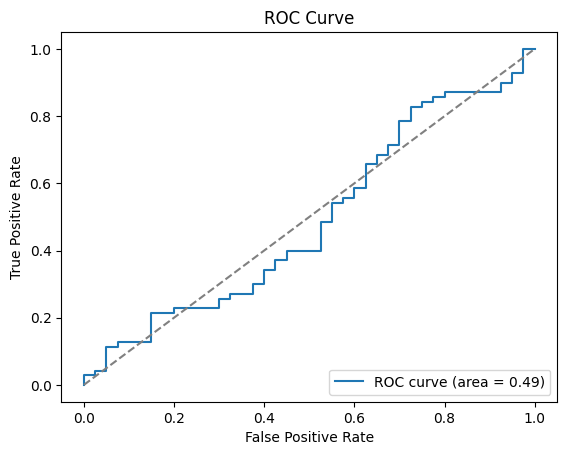

=== Entraînement pour la catégorie : toothbrush ===


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `multiscale_structural_similarity_index_measure` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `multiscale_structural_similarity_index_measure` from `torchmetrics.image` instead.
  _future_warning(


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 1.06 MiB is free. Process 5955 has 14.74 GiB memory in use. Of the allocated memory 13.71 GiB is allocated by PyTorch, and 931.51 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# Lancer le pipeline toute les prétextes et toutes les catégories de données
results = run_pipeline(data_loaders_dict, num_epochs=35, device=device)

In [23]:
data_loaders_dict = {
    'toothbrush': {
        'train_loader': train_toothbrush_loader,
        'test_loader': test_toothbrush_loader
    },
    'engine_wiring': {
        'train_loader': train_engine_wiring_loader,
        'test_loader': test_engine_wiring_loader
    }
}

=== Entraînement pour la catégorie : toothbrush ===


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `multiscale_structural_similarity_index_measure` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `multiscale_structural_similarity_index_measure` from `torchmetrics.image` instead.
  _future_warning(


Epoch 1/35, Train Loss: 0.4153, Val Loss: 0.8256
Epoch 2/35, Train Loss: 0.4135, Val Loss: 0.8232
Epoch 3/35, Train Loss: 0.4127, Val Loss: 0.8209
Epoch 4/35, Train Loss: 0.4114, Val Loss: 0.8186
Epoch 5/35, Train Loss: 0.4103, Val Loss: 0.8161
Epoch 6/35, Train Loss: 0.4090, Val Loss: 0.8133
Epoch 7/35, Train Loss: 0.4074, Val Loss: 0.8101
Epoch 8/35, Train Loss: 0.4058, Val Loss: 0.8063
Epoch 9/35, Train Loss: 0.4040, Val Loss: 0.8017
Epoch 10/35, Train Loss: 0.4016, Val Loss: 0.7962
Epoch 11/35, Train Loss: 0.3984, Val Loss: 0.7890
Epoch 12/35, Train Loss: 0.3948, Val Loss: 0.7795
Epoch 13/35, Train Loss: 0.3895, Val Loss: 0.7661
Epoch 14/35, Train Loss: 0.3823, Val Loss: 0.7445
Epoch 15/35, Train Loss: 0.3687, Val Loss: 0.6892
Epoch 16/35, Train Loss: 0.3332, Val Loss: 0.6559
Epoch 17/35, Train Loss: 0.3156, Val Loss: 0.5688
Epoch 18/35, Train Loss: 0.2851, Val Loss: 0.5386
Epoch 19/35, Train Loss: 0.2632, Val Loss: 0.4715
Epoch 20/35, Train Loss: 0.2354, Val Loss: 0.4307
Epoch 21/

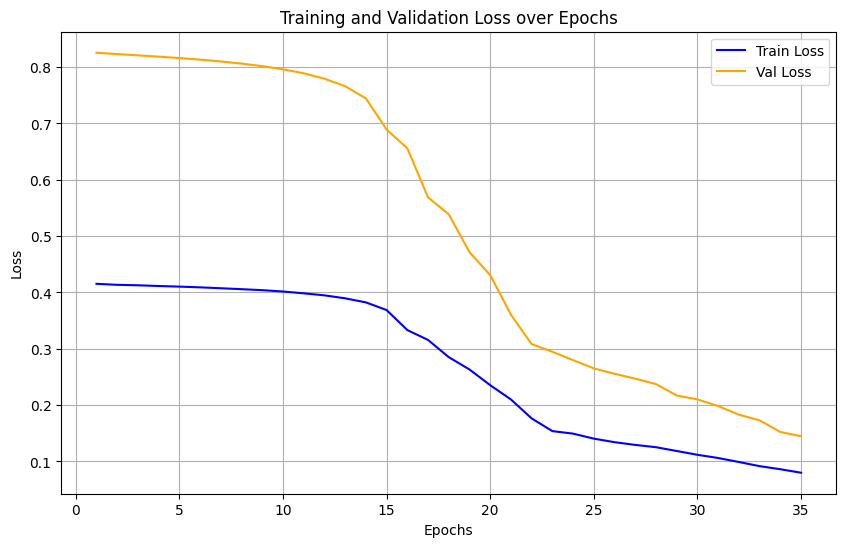

Modèle sauvegardé : toothbrush_model.pth
=== Évaluation pour la catégorie : toothbrush ===


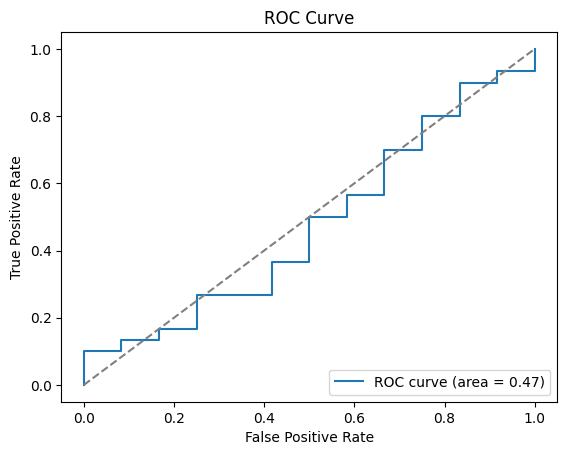

=== Entraînement pour la catégorie : engine_wiring ===


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `multiscale_structural_similarity_index_measure` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `multiscale_structural_similarity_index_measure` from `torchmetrics.image` instead.
  _future_warning(


Epoch 1/35, Train Loss: 0.5327, Val Loss: 1.0530
Epoch 2/35, Train Loss: 0.5313, Val Loss: 1.0512
Epoch 3/35, Train Loss: 0.5301, Val Loss: 1.0475
Epoch 4/35, Train Loss: 0.5273, Val Loss: 1.0384
Epoch 5/35, Train Loss: 0.5149, Val Loss: 0.9254
Epoch 6/35, Train Loss: 0.4519, Val Loss: 0.7463
Epoch 7/35, Train Loss: 0.3062, Val Loss: 0.4790
Epoch 8/35, Train Loss: 0.2213, Val Loss: 0.4028
Epoch 9/35, Train Loss: 0.1739, Val Loss: 0.2834
Epoch 10/35, Train Loss: 0.1127, Val Loss: 0.1897
Epoch 11/35, Train Loss: 0.0879, Val Loss: 0.1675
Epoch 12/35, Train Loss: 0.0790, Val Loss: 0.1524
Epoch 13/35, Train Loss: 0.0735, Val Loss: 0.1465
Epoch 14/35, Train Loss: 0.0694, Val Loss: 0.1372
Epoch 15/35, Train Loss: 0.0671, Val Loss: 0.1293
Epoch 16/35, Train Loss: 0.0646, Val Loss: 0.1269
Epoch 17/35, Train Loss: 0.0608, Val Loss: 0.1200
Epoch 18/35, Train Loss: 0.0577, Val Loss: 0.1134
Epoch 19/35, Train Loss: 0.0540, Val Loss: 0.1073
Epoch 20/35, Train Loss: 0.0508, Val Loss: 0.0957
Epoch 21/

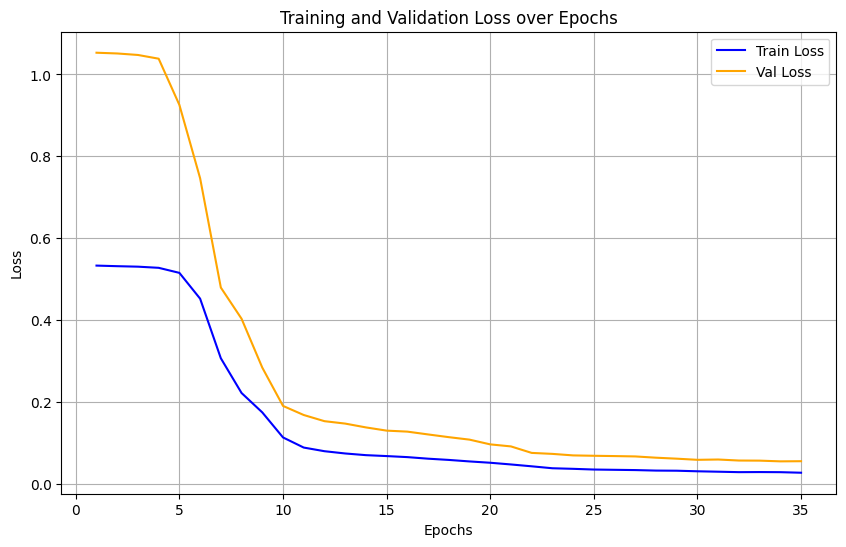

Modèle sauvegardé : engine_wiring_model.pth
=== Évaluation pour la catégorie : engine_wiring ===


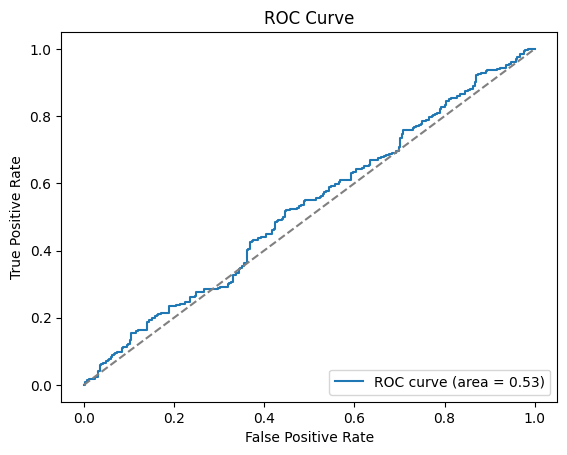

In [24]:
# Lancer le pipeline toute les prétextes et toutes les catégories de données
results = run_pipeline(data_loaders_dict, num_epochs=35, device=device)

Nous trouvons ces nouvelles méthodes très intéressantes et elles font parties de celles obtenant les meilleurs performances sur le jeu de donnée MVTecAD. En revanche le faible nombre d'epochs utilisées et notre implementation rudimentaire (qui peut aussi comporter des erreurs) de ces méthodes font que nous n'obtenons pas les résultats espérés. Nous obtenons tout de même les meilleures performances de ce notebook sur la catégorie bottle ce qui est motivant pour la recherche de pistes d'améliorations et d'adaptation des ces méthodes à chaque catégorie d'image. 